#### imports 

In [1]:
import torch
import torch.nn as nn
import os, glob
import random, csv
from torch.autograd import Variable

import visdom
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms
from PIL import Image
from tqdm.auto import tqdm
from torchvision.io import read_image
import numpy as np


from skimage import color, data, restoration




# img = read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_LR/1/0001_Set__kernel_label_1.png')
# print("Image data:\n", img)
# print(img.size())


#### crop ####

In [123]:
transform = transforms.CenterCrop((96,96))

In [143]:
for i,data in enumerate(train_loader):
        ##getting the inputs; data is a list of [inputs,labels] 
        
        t_inputs , t_labels = data
        t_inputs , t_labels = t_inputs.cuda(), t_labels.cuda()
        break
        
        


In [274]:
c = t_labels[1]
print(c)
# plt.imshow(c.cpu().permute(1,2,0))

tensor(0, device='cuda:0')


In [252]:
for i,data in enumerate(grnd_loader):
#         ##getting the inputs; data is a list of [inputs,labels] 
        
        g_inputs , g_labels = data
        g_inputs , g_labels = g_inputs.cuda(), g_labels.cuda()
        break
        

In [268]:
import random
import numpy as np
import torch.utils.data as data
import utils.utils_image as util
class DatasetSR(data.Dataset):
    '''
    # -----------------------------------------
    # Get L/H for SISR.
    # If only "paths_H" is provided, sythesize bicubicly downsampled L on-the-fly.
    # -----------------------------------------
    # e.g., SRResNet
    # -----------------------------------------
    '''
    def __init__(self):
        super(DatasetSR, self).__init__()
        self.n_channels = 3
        self.sf = 1
        self.patch_size = 96
        self.L_size = self.patch_size // self.sf
        # ------------------------------------
        # get paths of L/H
        # ------------------------------------
        self.paths_H = util.get_image_paths('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_Ensemble_GRND')
        self.paths_L = util.get_image_paths('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_Ensemble_LR')
        '''
        assert self.paths_H, 'Error: H path is empty.'
        if self.paths_L and self.paths_H:
            assert len(self.paths_L) == len(self.paths_H), 'L/H mismatch - {}, {}.'.format(len(self.paths_L), len(self.paths_H))
        '''
    def __getitem__(self, index):
        H_path = None
        # ------------------------------------
        # get H image
        # ------------------------------------
        L_path = self.paths_L[index]
        img_L = util.imread_uint(L_path, self.n_channels)
        img_L = util.uint2single(img_L)
        # ------------------------------------
        # modcrop
        # ------------------------------------
        # ------------------------------------
        # get L image
        # ------------------------------------
        if self.paths_H:
            # --------------------------------
            # directly load L image
            # --------------------------------
            H_path = self.paths_H[index]
            img_H = util.imread_uint(H_path, self.n_channels)
            img_H = util.uint2single(img_H)
            img_H = util.modcrop(img_H, self.sf)
        else:
            # --------------------------------
            # sythesize L image via matlab's bicubic
            # --------------------------------
            H, W = img_H.shape[:2]
            # img_L = util.imresize_np(img_H, 1 / self.sf, True)
        # ------------------------------------
        # if train, get L/H patch pair
        # ------------------------------------
        H, W, C = img_L.shape
        # --------------------------------
        # randomly crop the L patch
        # --------------------------------
        rnd_h = random.randint(0, max(0, H - self.L_size))
        rnd_w = random.randint(0, max(0, W - self.L_size))
        img_L = img_L[rnd_h:rnd_h + self.L_size, rnd_w:rnd_w + self.L_size, :]
        # --------------------------------
        # crop corresponding H patch
        # --------------------------------
        # rnd_h_H, rnd_w_H = int(rnd_h * self.sf), int(rnd_w * self.sf)
        # img_H = img_H[rnd_h_H:rnd_h_H + self.patch_size, rnd_w_H:rnd_w_H + self.patch_size, :]
        img_H = img_H[rnd_h:rnd_h + self.L_size, rnd_w:rnd_w + self.L_size, :]
        # --------------------------------
        # augmentation - flip and/or rotate
        # --------------------------------
        # mode = random.randint(0, 7)
        # img_L, img_H = util.augment_img(img_L, mode=mode), util.augment_img(img_H, mode=mode)
        # ------------------------------------
        # L/H pairs, HWC to CHW, numpy to tensor
        # ------------------------------------
        # img_L = img_L.copy()
        # img_H =img_H.copy()
        img_H, img_L = util.single2tensor3(img_H), util.single2tensor3(img_L)
#         giving the label as the kernel used :
        L_label = L_path[len(L_path)-5]
        if L_path is None:
            L_path = H_path
        return {'L': img_L, 'H': img_H, 'L_path': L_path, 'H_path': H_path,'L_label': L_label}
    def __len__(self):
        return len(self.paths_L)

In [269]:
###creating of the datasets 

#Set Device to Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = 6

data_set = DatasetSR()
data_loader_emb = DataLoader(data_set, batch_size=16, shuffle=False)
length = len(data_set)
print(length)
##test for the LR label 
for data in data_loader_emb:
    train_data = data['L']
    break   


cuda:0
4800


In [270]:
###Residual block ######

class BasicResidualBlock(nn.Module): 
    def __init__(self,channel_num):
        super(BasicResidualBlock,self).__init__()
        ## 3 * 3 kernel conv 
        #input and output channels == channel_num
        self.conv_block1 = nn.Sequential(nn.Conv2d(channel_num, channel_num ,3, padding=1),
                                         nn.BatchNorm2d(channel_num),nn.ReLU())
        self.conv_block2 = nn.Sequential(nn.Conv2d(channel_num, channel_num, 3, padding=1),
                                         nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3,padding = 1)
		 
              
    def forward(self,x): 
          
            ##forward 
            residual = x
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            x = x + residual 
            x = self.relu(x)
            out = self.maxpool(x)
           
            return out 

In [271]:
##Functional KES net 

class KES_Net(torch.nn.Module):
    def __init__(self):
        super(KES_Net, self).__init__()
        
        ##first block is the convolution ---size of 
        self.block_1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                    nn.ReLU(),nn.BatchNorm2d(64))                   
        
        self.BasicResidualBlock = nn.ModuleList([BasicResidualBlock(channel_num=64) for i in range(8)])
        # self.maxpool = torch.nn.MaxPool2d(kernel_size = 3,padding = 1)
        self.block_3 =  torch.nn.Sequential(torch.nn.Conv2d(in_channels =64,out_channels=256,kernel_size=1),
                                            torch.nn.BatchNorm2d(256),
                                            torch.nn.ReLU(inplace=True)
                                           )
        self.block_4 =  torch.nn.Sequential(torch.nn.Conv2d(in_channels =256,out_channels=128,kernel_size=1),
                                            torch.nn.BatchNorm2d(128),
                                            torch.nn.ReLU(inplace=True)
                                           )
        self.block_5 =  torch.nn.Sequential(torch.nn.Conv2d(in_channels =128,out_channels=121,kernel_size=1),
                                            torch.nn.BatchNorm2d(121),
                                            torch.nn.Sigmoid()
                                           )
        # self.fc2 = nn.Linear(121,1)
        
    def forward(self,x):
        x = self.block_1(x)
        for i, __ in enumerate(self.BasicResidualBlock):
            x = self.BasicResidualBlock[i](x)
       ##global average pooling  
        #x = x.mean(dim=(-2, -1))
            
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        # x = self.fc2(x)
        
        return x

In [272]:
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = KES_Net()
model.to(device)

# error = nn.L1Loss()

learning_rate = 1e-4 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Code to use the Adam Optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[100000, 160000, 180000, 192000, 200000], gamma=0.5) #milestones=[Intended Epoch * Batch Size]
print(model)

cuda:0
KES_Net(
  (block_1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (BasicResidualBlock): ModuleList(
    (0): BasicResidualBlock(
      (conv_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU()
      )
      (conv_block2): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (relu): ReLU()
      (maxpool): MaxPool2d(kernel_size=3, stride=3, padding=1, dilation=1, ceil_mode=False)
    )
    (1): BasicResidualBlock(
      (conv_block1): Sequential(
        (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
     

In [273]:
import torch.nn.functional as F
num_epochs = 3000 #5000 after half divide lr by 2
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

count = 0 
optimizer = torch.optim.SGD(model.parameters(), lr =0.0001 , momentum =0.5)
# num_epochs = 50
learning_rate = 0.1


def wiener_loss_function(image,kernel,grnd_img):
    transform = transforms.ToTensor()
    rng = np.random.default_rng()
    ##input image for the network
    image = image.to('cpu')
    image = image.detach().numpy()
    image = image[1,:]
    image = image.reshape((96,96,3))
    image = color.rgb2gray(image)
    image += 0.1 * image.std() * rng.standard_normal(image.shape)
    image = image.astype(object)
    ####this is for the kernel ----reshaping from 121,1 to 11,11
    kernel = kernel.to('cpu')
    kernel = kernel.detach().numpy()
    kernel = kernel[1,:]
    kernel = kernel.reshape((11,11))
    kernel = kernel.astype(object)
    # deconv_img = restoration.wiener(image, kernel,0.0001)
    ##deconvoluting the image with the filter ---requiring 
    deconv_img, _ = restoration.unsupervised_wiener(image, kernel)
    deconv_tensor = transform(deconv_img)
    deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)
    deconv_tensor = deconv_tensor.type(torch.DoubleTensor)
    ##ground  image --from the g_inputs 
    grnd_img = grnd_img.to('cpu')
    grnd_img = grnd_img[1,:]
    grnd_img = grnd_img.reshape((96,96,3))
    grnd_img = color.rgb2gray(grnd_img)
    grnd_img_tensor = transform(grnd_img)
    grnd_img_tensor=grnd_img_tensor.type(torch.DoubleTensor)
    # print(grnd_img)
    # plt.imshow(grnd_img)
    mse_loss = nn.MSELoss()
    loss = mse_loss(deconv_tensor,grnd_img_tensor)
    loss = loss.type(torch.DoubleTensor)
    # print(loss)
    return loss


for epoch in tqdm(range(num_epochs)):
    running_loss =0.0
    for idx,data in tqdm(enumerate(data_loader_emb)):
        labels=[]
        # , train_data in tqdm(enumerate(train_loader)):
    # for index, ((img,lab_t),(img1,lab_g)) in tqdm(enumerate(zip(train_loader,grnd_loader))):
        ##getting the inputs; data is a list of [inputs,labels] 
        # images_input = x['L']
        #labels ---L_label
        # inputs , labels = data
        # inputs , labels = inputs.cuda(), labels.cuda()
        # x = data
        ##input images for the train loader
#         images_input = img.to(device)
#         train = Variable(images_input)
        
        
        train = data['L'].to(device)
        # train = train.to(device)
        ##ground loader
        
        # ground = Variable(img1.to(device))
        labels = data['L_label']
        # labels = labels.to(device)
        ground = data['H'].to(device)
        

        # zero the parameter gradients 
        optimizer.zero_grad()
        
        # forward + backward + optimize 
        outputs = model(train)
        loss = wiener_loss_function(train,outputs,ground)
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        # loss.backward()
        
        # Optimizing the parameters
        # optimizer.step()
        scheduler.step()
        count += 1
        loss.backward()
        optimizer.step() 
        
        
        
        count += 1
#         running_loss += loss.item()
#         print ('iteration : {}, No. of Epochs [{}/{}],Learning rate :  Loss: {:.4f}'.format(count,epoch+1, num_epochs,learning_rate,loss.item()))
# print('Finished Training')

        if (count % 800 == 0):
            print("Iteration: {}, Loss: {}%, Learning Rate: {}, epoch: {}".format(count, loss.data,scheduler.get_last_lr(),epoch))
            loss_list.append(loss.data)
            iteration_list.append(count)
        if epoch % 5 == 0 or epoch ==num_epochs - 1 :
            torch.save(model.state_dict(),os.path.join("C:/Computer_Vision/Nashra_486515/Super_resolution_project/KES_Net", 'KES_Net' + str(epoch) + '.pth'))
            

  0%|          | 0/3000 [00:00<?, ?it/s]

0it [00:00, ?it/s]

C:\Users\n_babar\AppData\Local\Temp/ipykernel_22772/9450955.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)
C:\Users\n_babar\anaconda3\lib\site-packages\torch\optim\lr_scheduler.py:131: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


0it [00:00, ?it/s]

Iteration: 800, Loss: 0.2560599603094506%, Learning Rate: [0.0001], epoch: 1


0it [00:00, ?it/s]

Iteration: 1600, Loss: 0.36036659018022693%, Learning Rate: [0.0001], epoch: 2


0it [00:00, ?it/s]

Iteration: 2400, Loss: 0.17150045492290544%, Learning Rate: [0.0001], epoch: 3


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 3200, Loss: 0.2744240983708664%, Learning Rate: [0.0001], epoch: 5


0it [00:00, ?it/s]

Iteration: 4000, Loss: 0.24510284246662925%, Learning Rate: [0.0001], epoch: 6


0it [00:00, ?it/s]

Iteration: 4800, Loss: 0.4421379499586798%, Learning Rate: [0.0001], epoch: 7


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 5600, Loss: 0.3139355639864706%, Learning Rate: [0.0001], epoch: 9


0it [00:00, ?it/s]

Iteration: 6400, Loss: 0.5441598500609286%, Learning Rate: [0.0001], epoch: 10


0it [00:00, ?it/s]

Iteration: 7200, Loss: 0.4731569784948824%, Learning Rate: [0.0001], epoch: 11


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 8000, Loss: 0.25373056678486533%, Learning Rate: [0.0001], epoch: 13


0it [00:00, ?it/s]

Iteration: 8800, Loss: 0.4330899204355962%, Learning Rate: [0.0001], epoch: 14


0it [00:00, ?it/s]

Iteration: 9600, Loss: 0.34196976743122204%, Learning Rate: [0.0001], epoch: 15


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 10400, Loss: 0.12066761012693333%, Learning Rate: [0.0001], epoch: 17


0it [00:00, ?it/s]

Iteration: 11200, Loss: 0.2435426454904068%, Learning Rate: [0.0001], epoch: 18


0it [00:00, ?it/s]

Iteration: 12000, Loss: 0.31828611546786395%, Learning Rate: [0.0001], epoch: 19


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 12800, Loss: 0.3265181394018872%, Learning Rate: [0.0001], epoch: 21


0it [00:00, ?it/s]

Iteration: 13600, Loss: 0.44194902535928965%, Learning Rate: [0.0001], epoch: 22


0it [00:00, ?it/s]

Iteration: 14400, Loss: 0.2517864548122629%, Learning Rate: [0.0001], epoch: 23


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 15200, Loss: 0.2981726510862433%, Learning Rate: [0.0001], epoch: 25


0it [00:00, ?it/s]

Iteration: 16000, Loss: 0.30797147004557907%, Learning Rate: [0.0001], epoch: 26


0it [00:00, ?it/s]

Iteration: 16800, Loss: 0.22781407051558616%, Learning Rate: [0.0001], epoch: 27


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 17600, Loss: 0.29757296600034816%, Learning Rate: [0.0001], epoch: 29


0it [00:00, ?it/s]

Iteration: 18400, Loss: 0.2403493122390672%, Learning Rate: [0.0001], epoch: 30


0it [00:00, ?it/s]

Iteration: 19200, Loss: 0.2510798203324951%, Learning Rate: [0.0001], epoch: 31


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 20000, Loss: 0.31675710422998704%, Learning Rate: [0.0001], epoch: 33


0it [00:00, ?it/s]

Iteration: 20800, Loss: 0.39452767016715473%, Learning Rate: [0.0001], epoch: 34


0it [00:00, ?it/s]

Iteration: 21600, Loss: 0.30494671067497997%, Learning Rate: [0.0001], epoch: 35


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 22400, Loss: 0.2755340217780201%, Learning Rate: [0.0001], epoch: 37


0it [00:00, ?it/s]

Iteration: 23200, Loss: 0.25532944830030113%, Learning Rate: [0.0001], epoch: 38


0it [00:00, ?it/s]

Iteration: 24000, Loss: 0.13637540170565807%, Learning Rate: [0.0001], epoch: 39


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 24800, Loss: 0.13548902636949484%, Learning Rate: [0.0001], epoch: 41


0it [00:00, ?it/s]

Iteration: 25600, Loss: 0.322362528062722%, Learning Rate: [0.0001], epoch: 42


0it [00:00, ?it/s]

Iteration: 26400, Loss: 0.40310821526428675%, Learning Rate: [0.0001], epoch: 43


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 27200, Loss: 0.27733206905271207%, Learning Rate: [0.0001], epoch: 45


0it [00:00, ?it/s]

Iteration: 28000, Loss: 0.25687431975793523%, Learning Rate: [0.0001], epoch: 46


0it [00:00, ?it/s]

Iteration: 28800, Loss: 0.31487605554948406%, Learning Rate: [0.0001], epoch: 47


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 29600, Loss: 0.18753823474927453%, Learning Rate: [0.0001], epoch: 49


0it [00:00, ?it/s]

Iteration: 30400, Loss: 0.36190018539511015%, Learning Rate: [0.0001], epoch: 50


0it [00:00, ?it/s]

Iteration: 31200, Loss: 0.12721014636875536%, Learning Rate: [0.0001], epoch: 51


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 32000, Loss: 0.2641651241641224%, Learning Rate: [0.0001], epoch: 53


0it [00:00, ?it/s]

Iteration: 32800, Loss: 0.22459566208813891%, Learning Rate: [0.0001], epoch: 54


0it [00:00, ?it/s]

Iteration: 33600, Loss: 0.3010089390667341%, Learning Rate: [0.0001], epoch: 55


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 34400, Loss: 0.2793724625013657%, Learning Rate: [0.0001], epoch: 57


0it [00:00, ?it/s]

Iteration: 35200, Loss: 0.21578054371208452%, Learning Rate: [0.0001], epoch: 58


0it [00:00, ?it/s]

Iteration: 36000, Loss: 0.14628985368012953%, Learning Rate: [0.0001], epoch: 59


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 36800, Loss: 0.09129249815287074%, Learning Rate: [0.0001], epoch: 61


0it [00:00, ?it/s]

Iteration: 37600, Loss: 0.46922344582426756%, Learning Rate: [0.0001], epoch: 62


0it [00:00, ?it/s]

Iteration: 38400, Loss: 0.3838109478335407%, Learning Rate: [0.0001], epoch: 63


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 39200, Loss: 0.21448749386485697%, Learning Rate: [0.0001], epoch: 65


0it [00:00, ?it/s]

Iteration: 40000, Loss: 0.2628641637942259%, Learning Rate: [0.0001], epoch: 66


0it [00:00, ?it/s]

Iteration: 40800, Loss: 0.12815052643671845%, Learning Rate: [0.0001], epoch: 67


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 41600, Loss: 0.23102767547799058%, Learning Rate: [0.0001], epoch: 69


0it [00:00, ?it/s]

Iteration: 42400, Loss: 0.26018025614485596%, Learning Rate: [0.0001], epoch: 70


0it [00:00, ?it/s]

Iteration: 43200, Loss: 0.24564290724247012%, Learning Rate: [0.0001], epoch: 71


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 44000, Loss: 0.30837051504021196%, Learning Rate: [0.0001], epoch: 73


0it [00:00, ?it/s]

Iteration: 44800, Loss: 0.2639710890193001%, Learning Rate: [0.0001], epoch: 74


0it [00:00, ?it/s]

Iteration: 45600, Loss: 0.2444060194266604%, Learning Rate: [0.0001], epoch: 75


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 46400, Loss: 0.24110274803238033%, Learning Rate: [0.0001], epoch: 77


0it [00:00, ?it/s]

Iteration: 47200, Loss: 0.1259911025822547%, Learning Rate: [0.0001], epoch: 78


0it [00:00, ?it/s]

Iteration: 48000, Loss: 0.21895061053618184%, Learning Rate: [0.0001], epoch: 79


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 48800, Loss: 0.14933812445375358%, Learning Rate: [0.0001], epoch: 81


0it [00:00, ?it/s]

Iteration: 49600, Loss: 0.2744441228388667%, Learning Rate: [0.0001], epoch: 82


0it [00:00, ?it/s]

Iteration: 50400, Loss: 0.42284232166484703%, Learning Rate: [0.0001], epoch: 83


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 51200, Loss: 0.18214915728990222%, Learning Rate: [0.0001], epoch: 85


0it [00:00, ?it/s]

Iteration: 52000, Loss: 0.2319961768813968%, Learning Rate: [0.0001], epoch: 86


0it [00:00, ?it/s]

Iteration: 52800, Loss: 0.12619005957948518%, Learning Rate: [0.0001], epoch: 87


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 53600, Loss: 0.11892638339793143%, Learning Rate: [0.0001], epoch: 89


0it [00:00, ?it/s]

Iteration: 54400, Loss: 0.3106334983369427%, Learning Rate: [0.0001], epoch: 90


0it [00:00, ?it/s]

Iteration: 55200, Loss: 0.3326790799637953%, Learning Rate: [0.0001], epoch: 91


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 56000, Loss: 0.30219978032874173%, Learning Rate: [0.0001], epoch: 93


0it [00:00, ?it/s]

Iteration: 56800, Loss: 0.32347719734053526%, Learning Rate: [0.0001], epoch: 94


0it [00:00, ?it/s]

Iteration: 57600, Loss: 0.38557853636269857%, Learning Rate: [0.0001], epoch: 95


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 58400, Loss: 0.2976726232282322%, Learning Rate: [0.0001], epoch: 97


0it [00:00, ?it/s]

Iteration: 59200, Loss: 0.27185741305233113%, Learning Rate: [0.0001], epoch: 98


0it [00:00, ?it/s]

Iteration: 60000, Loss: 0.389484085429168%, Learning Rate: [0.0001], epoch: 99


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 60800, Loss: 0.3168198373469507%, Learning Rate: [0.0001], epoch: 101


0it [00:00, ?it/s]

Iteration: 61600, Loss: 0.5757575150899621%, Learning Rate: [0.0001], epoch: 102


0it [00:00, ?it/s]

Iteration: 62400, Loss: 0.2421091204948699%, Learning Rate: [0.0001], epoch: 103


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 63200, Loss: 0.2899287978448678%, Learning Rate: [0.0001], epoch: 105


0it [00:00, ?it/s]

Iteration: 64000, Loss: 0.14206630507660217%, Learning Rate: [0.0001], epoch: 106


0it [00:00, ?it/s]

Iteration: 64800, Loss: 0.26772158666786783%, Learning Rate: [0.0001], epoch: 107


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 65600, Loss: 0.2950434096348279%, Learning Rate: [0.0001], epoch: 109


0it [00:00, ?it/s]

Iteration: 66400, Loss: 0.24863322922536657%, Learning Rate: [0.0001], epoch: 110


0it [00:00, ?it/s]

Iteration: 67200, Loss: 0.3135318178384782%, Learning Rate: [0.0001], epoch: 111


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 68000, Loss: 0.21262461330040827%, Learning Rate: [0.0001], epoch: 113


0it [00:00, ?it/s]

Iteration: 68800, Loss: 0.1357899304956517%, Learning Rate: [0.0001], epoch: 114


0it [00:00, ?it/s]

Iteration: 69600, Loss: 0.2756441100637537%, Learning Rate: [0.0001], epoch: 115


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 70400, Loss: 0.2547662216314983%, Learning Rate: [0.0001], epoch: 117


0it [00:00, ?it/s]

Iteration: 71200, Loss: 0.25255308704058727%, Learning Rate: [0.0001], epoch: 118


0it [00:00, ?it/s]

Iteration: 72000, Loss: 0.3052433550964829%, Learning Rate: [0.0001], epoch: 119


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 72800, Loss: 0.23897958983423415%, Learning Rate: [0.0001], epoch: 121


0it [00:00, ?it/s]

Iteration: 73600, Loss: 0.28607157775427433%, Learning Rate: [0.0001], epoch: 122


0it [00:00, ?it/s]

Iteration: 74400, Loss: 0.24175258111038728%, Learning Rate: [0.0001], epoch: 123


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 75200, Loss: 0.333532138683226%, Learning Rate: [0.0001], epoch: 125


0it [00:00, ?it/s]

Iteration: 76000, Loss: 0.25599358348460677%, Learning Rate: [0.0001], epoch: 126


0it [00:00, ?it/s]

Iteration: 76800, Loss: 0.2670357996566423%, Learning Rate: [0.0001], epoch: 127


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 77600, Loss: 0.16828665753696528%, Learning Rate: [0.0001], epoch: 129


0it [00:00, ?it/s]

Iteration: 78400, Loss: 0.2638934610808789%, Learning Rate: [0.0001], epoch: 130


0it [00:00, ?it/s]

Iteration: 79200, Loss: 0.23673760243800335%, Learning Rate: [0.0001], epoch: 131


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 80000, Loss: 0.31993545980477767%, Learning Rate: [0.0001], epoch: 133


0it [00:00, ?it/s]

Iteration: 80800, Loss: 0.23243288204754553%, Learning Rate: [0.0001], epoch: 134


0it [00:00, ?it/s]

Iteration: 81600, Loss: 0.37089876889952833%, Learning Rate: [0.0001], epoch: 135


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 82400, Loss: 0.2714564823200228%, Learning Rate: [0.0001], epoch: 137


0it [00:00, ?it/s]

Iteration: 83200, Loss: 0.244119930696865%, Learning Rate: [0.0001], epoch: 138


0it [00:00, ?it/s]

Iteration: 84000, Loss: 0.2659867527543118%, Learning Rate: [0.0001], epoch: 139


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 84800, Loss: 0.26429900591142796%, Learning Rate: [0.0001], epoch: 141


0it [00:00, ?it/s]

Iteration: 85600, Loss: 0.3847830702034602%, Learning Rate: [0.0001], epoch: 142


0it [00:00, ?it/s]

Iteration: 86400, Loss: 0.22502406586051318%, Learning Rate: [0.0001], epoch: 143


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 87200, Loss: 0.28277444643445127%, Learning Rate: [0.0001], epoch: 145


0it [00:00, ?it/s]

Iteration: 88000, Loss: 0.22572516852534083%, Learning Rate: [0.0001], epoch: 146


0it [00:00, ?it/s]

Iteration: 88800, Loss: 0.17388921031235377%, Learning Rate: [0.0001], epoch: 147


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 89600, Loss: 0.1323491418777166%, Learning Rate: [0.0001], epoch: 149


0it [00:00, ?it/s]

Iteration: 90400, Loss: 0.29387911127625677%, Learning Rate: [0.0001], epoch: 150


0it [00:00, ?it/s]

Iteration: 91200, Loss: 0.23707048242480985%, Learning Rate: [0.0001], epoch: 151


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 92000, Loss: 0.3211380436106666%, Learning Rate: [0.0001], epoch: 153


0it [00:00, ?it/s]

Iteration: 92800, Loss: 0.24261183307284406%, Learning Rate: [0.0001], epoch: 154


0it [00:00, ?it/s]

Iteration: 93600, Loss: 0.19318155467652004%, Learning Rate: [0.0001], epoch: 155


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 94400, Loss: 0.2741510419906728%, Learning Rate: [0.0001], epoch: 157


0it [00:00, ?it/s]

Iteration: 95200, Loss: 0.32135996118802473%, Learning Rate: [0.0001], epoch: 158


0it [00:00, ?it/s]

Iteration: 96000, Loss: 0.3376182853331929%, Learning Rate: [0.0001], epoch: 159


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 96800, Loss: 0.2625731077813902%, Learning Rate: [0.0001], epoch: 161


0it [00:00, ?it/s]

Iteration: 97600, Loss: 0.3230237717528873%, Learning Rate: [0.0001], epoch: 162


0it [00:00, ?it/s]

Iteration: 98400, Loss: 0.33013508807176495%, Learning Rate: [0.0001], epoch: 163


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 99200, Loss: 0.21669141217770155%, Learning Rate: [0.0001], epoch: 165


0it [00:00, ?it/s]

Iteration: 100000, Loss: 0.3505293023095704%, Learning Rate: [0.0001], epoch: 166


0it [00:00, ?it/s]

Iteration: 100800, Loss: 0.2594268949216753%, Learning Rate: [0.0001], epoch: 167


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 101600, Loss: 0.17051021894280913%, Learning Rate: [0.0001], epoch: 169


0it [00:00, ?it/s]

Iteration: 102400, Loss: 0.35908016884026117%, Learning Rate: [0.0001], epoch: 170


0it [00:00, ?it/s]

Iteration: 103200, Loss: 0.28963369515537113%, Learning Rate: [0.0001], epoch: 171


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 104000, Loss: 0.24158155102688741%, Learning Rate: [0.0001], epoch: 173


0it [00:00, ?it/s]

Iteration: 104800, Loss: 0.14259402102689364%, Learning Rate: [0.0001], epoch: 174


0it [00:00, ?it/s]

Iteration: 105600, Loss: 0.36063906970085646%, Learning Rate: [0.0001], epoch: 175


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 106400, Loss: 0.22179409727834296%, Learning Rate: [0.0001], epoch: 177


0it [00:00, ?it/s]

Iteration: 107200, Loss: 0.32581866703438195%, Learning Rate: [0.0001], epoch: 178


0it [00:00, ?it/s]

Iteration: 108000, Loss: 0.32807501854729476%, Learning Rate: [0.0001], epoch: 179


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 108800, Loss: 0.30564434103976684%, Learning Rate: [0.0001], epoch: 181


0it [00:00, ?it/s]

Iteration: 109600, Loss: 0.48917079829962734%, Learning Rate: [0.0001], epoch: 182


0it [00:00, ?it/s]

Iteration: 110400, Loss: 0.34995886515201496%, Learning Rate: [0.0001], epoch: 183


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 111200, Loss: 0.26058271191516447%, Learning Rate: [0.0001], epoch: 185


0it [00:00, ?it/s]

Iteration: 112000, Loss: 0.2701987559789723%, Learning Rate: [0.0001], epoch: 186


0it [00:00, ?it/s]

Iteration: 112800, Loss: 0.2896156309925078%, Learning Rate: [0.0001], epoch: 187


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 113600, Loss: 0.08627656760123911%, Learning Rate: [0.0001], epoch: 189


0it [00:00, ?it/s]

Iteration: 114400, Loss: 0.2318101993979806%, Learning Rate: [0.0001], epoch: 190


0it [00:00, ?it/s]

Iteration: 115200, Loss: 0.4213570390493493%, Learning Rate: [0.0001], epoch: 191


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 116000, Loss: 0.3312109211174096%, Learning Rate: [0.0001], epoch: 193


0it [00:00, ?it/s]

Iteration: 116800, Loss: 0.2938508922133748%, Learning Rate: [0.0001], epoch: 194


0it [00:00, ?it/s]

Iteration: 117600, Loss: 0.47097673048522143%, Learning Rate: [0.0001], epoch: 195


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 118400, Loss: 0.20805309295478025%, Learning Rate: [0.0001], epoch: 197


0it [00:00, ?it/s]

Iteration: 119200, Loss: 0.5929731271087673%, Learning Rate: [0.0001], epoch: 198


0it [00:00, ?it/s]

Iteration: 120000, Loss: 0.386944554690101%, Learning Rate: [0.0001], epoch: 199


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 120800, Loss: 0.2536267874458606%, Learning Rate: [0.0001], epoch: 201


0it [00:00, ?it/s]

Iteration: 121600, Loss: 0.4112685819819802%, Learning Rate: [0.0001], epoch: 202


0it [00:00, ?it/s]

Iteration: 122400, Loss: 0.3151604523485225%, Learning Rate: [0.0001], epoch: 203


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 123200, Loss: 0.30841379499016736%, Learning Rate: [0.0001], epoch: 205


0it [00:00, ?it/s]

Iteration: 124000, Loss: 0.2662024352126966%, Learning Rate: [0.0001], epoch: 206


0it [00:00, ?it/s]

Iteration: 124800, Loss: 0.23773222836195393%, Learning Rate: [0.0001], epoch: 207


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 125600, Loss: 0.29923645788877085%, Learning Rate: [0.0001], epoch: 209


0it [00:00, ?it/s]

Iteration: 126400, Loss: 0.350449254081041%, Learning Rate: [0.0001], epoch: 210


0it [00:00, ?it/s]

Iteration: 127200, Loss: 0.34286678414964966%, Learning Rate: [0.0001], epoch: 211


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 128000, Loss: 0.25921017833981325%, Learning Rate: [0.0001], epoch: 213


0it [00:00, ?it/s]

Iteration: 128800, Loss: 0.5260703430131383%, Learning Rate: [0.0001], epoch: 214


0it [00:00, ?it/s]

Iteration: 129600, Loss: 0.1814112880701413%, Learning Rate: [0.0001], epoch: 215


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 130400, Loss: 0.2542347270534823%, Learning Rate: [0.0001], epoch: 217


0it [00:00, ?it/s]

Iteration: 131200, Loss: 0.4629857090953446%, Learning Rate: [0.0001], epoch: 218


0it [00:00, ?it/s]

Iteration: 132000, Loss: 0.305606940340227%, Learning Rate: [0.0001], epoch: 219


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 132800, Loss: 0.3157243957056531%, Learning Rate: [0.0001], epoch: 221


0it [00:00, ?it/s]

Iteration: 133600, Loss: 0.08882271896978634%, Learning Rate: [0.0001], epoch: 222


0it [00:00, ?it/s]

Iteration: 134400, Loss: 0.34987752939512706%, Learning Rate: [0.0001], epoch: 223


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 135200, Loss: 0.2756864473578604%, Learning Rate: [0.0001], epoch: 225


0it [00:00, ?it/s]

Iteration: 136000, Loss: 0.28015248865893577%, Learning Rate: [0.0001], epoch: 226


0it [00:00, ?it/s]

Iteration: 136800, Loss: 0.3746201044460723%, Learning Rate: [0.0001], epoch: 227


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 137600, Loss: 0.28800019324282117%, Learning Rate: [0.0001], epoch: 229


0it [00:00, ?it/s]

Iteration: 138400, Loss: 0.31109547050181807%, Learning Rate: [0.0001], epoch: 230


0it [00:00, ?it/s]

Iteration: 139200, Loss: 0.3848665294932129%, Learning Rate: [0.0001], epoch: 231


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 140000, Loss: 0.29870989947026694%, Learning Rate: [0.0001], epoch: 233


0it [00:00, ?it/s]

Iteration: 140800, Loss: 0.41984819519722255%, Learning Rate: [0.0001], epoch: 234


0it [00:00, ?it/s]

Iteration: 141600, Loss: 0.12412709533003458%, Learning Rate: [0.0001], epoch: 235


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 142400, Loss: 0.0830214320708956%, Learning Rate: [0.0001], epoch: 237


0it [00:00, ?it/s]

Iteration: 143200, Loss: 0.2768706997046885%, Learning Rate: [0.0001], epoch: 238


0it [00:00, ?it/s]

Iteration: 144000, Loss: 0.27119573942718234%, Learning Rate: [0.0001], epoch: 239


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 144800, Loss: 0.09811012684526499%, Learning Rate: [0.0001], epoch: 241


0it [00:00, ?it/s]

Iteration: 145600, Loss: 0.24504329910963346%, Learning Rate: [0.0001], epoch: 242


0it [00:00, ?it/s]

Iteration: 146400, Loss: 0.3854555311340831%, Learning Rate: [0.0001], epoch: 243


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 147200, Loss: 0.35455606249848404%, Learning Rate: [0.0001], epoch: 245


0it [00:00, ?it/s]

Iteration: 148000, Loss: 0.4737418516841493%, Learning Rate: [0.0001], epoch: 246


0it [00:00, ?it/s]

Iteration: 148800, Loss: 0.35964825637109826%, Learning Rate: [0.0001], epoch: 247


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 149600, Loss: 0.17403505220165882%, Learning Rate: [0.0001], epoch: 249


0it [00:00, ?it/s]

Iteration: 150400, Loss: 0.28850040146858924%, Learning Rate: [0.0001], epoch: 250


0it [00:00, ?it/s]

Iteration: 151200, Loss: 0.3470266257388326%, Learning Rate: [0.0001], epoch: 251


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 152000, Loss: 0.18180280107877703%, Learning Rate: [0.0001], epoch: 253


0it [00:00, ?it/s]

Iteration: 152800, Loss: 0.3463223911771575%, Learning Rate: [0.0001], epoch: 254


0it [00:00, ?it/s]

Iteration: 153600, Loss: 0.3403507839337899%, Learning Rate: [0.0001], epoch: 255


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 154400, Loss: 0.3466194426312341%, Learning Rate: [0.0001], epoch: 257


0it [00:00, ?it/s]

Iteration: 155200, Loss: 0.2867665919203543%, Learning Rate: [0.0001], epoch: 258


0it [00:00, ?it/s]

Iteration: 156000, Loss: 0.33427357380502476%, Learning Rate: [0.0001], epoch: 259


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 156800, Loss: 0.2891638607212068%, Learning Rate: [0.0001], epoch: 261


0it [00:00, ?it/s]

Iteration: 157600, Loss: 0.1354854309827501%, Learning Rate: [0.0001], epoch: 262


0it [00:00, ?it/s]

Iteration: 158400, Loss: 0.35474559488410395%, Learning Rate: [0.0001], epoch: 263


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 159200, Loss: 0.27619077654233704%, Learning Rate: [0.0001], epoch: 265


0it [00:00, ?it/s]

Iteration: 160000, Loss: 0.27454885442768684%, Learning Rate: [0.0001], epoch: 266


0it [00:00, ?it/s]

Iteration: 160800, Loss: 0.3403012957349047%, Learning Rate: [0.0001], epoch: 267


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 161600, Loss: 0.27349748162502696%, Learning Rate: [0.0001], epoch: 269


0it [00:00, ?it/s]

Iteration: 162400, Loss: 0.36842082001233045%, Learning Rate: [0.0001], epoch: 270


0it [00:00, ?it/s]

Iteration: 163200, Loss: 0.3643513700149983%, Learning Rate: [0.0001], epoch: 271


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 164000, Loss: 0.279913171348115%, Learning Rate: [0.0001], epoch: 273


0it [00:00, ?it/s]

Iteration: 164800, Loss: 0.2396698339149625%, Learning Rate: [0.0001], epoch: 274


0it [00:00, ?it/s]

Iteration: 165600, Loss: 0.3700405635194712%, Learning Rate: [0.0001], epoch: 275


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 166400, Loss: 0.2148916549033567%, Learning Rate: [0.0001], epoch: 277


0it [00:00, ?it/s]

Iteration: 167200, Loss: 0.4037587023861364%, Learning Rate: [0.0001], epoch: 278


0it [00:00, ?it/s]

Iteration: 168000, Loss: 0.30107881252613916%, Learning Rate: [0.0001], epoch: 279


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 168800, Loss: 0.30808616799717947%, Learning Rate: [0.0001], epoch: 281


0it [00:00, ?it/s]

Iteration: 169600, Loss: 0.28630054139112054%, Learning Rate: [0.0001], epoch: 282


0it [00:00, ?it/s]

Iteration: 170400, Loss: 0.1449257932855116%, Learning Rate: [0.0001], epoch: 283


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 171200, Loss: 0.21845138754760318%, Learning Rate: [0.0001], epoch: 285


0it [00:00, ?it/s]

Iteration: 172000, Loss: 0.22320965510951363%, Learning Rate: [0.0001], epoch: 286


0it [00:00, ?it/s]

Iteration: 172800, Loss: 0.35683375308031323%, Learning Rate: [0.0001], epoch: 287


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 173600, Loss: 0.11895750783882948%, Learning Rate: [0.0001], epoch: 289


0it [00:00, ?it/s]

Iteration: 174400, Loss: 0.2840759355511518%, Learning Rate: [0.0001], epoch: 290


0it [00:00, ?it/s]

Iteration: 175200, Loss: 0.2894646387526346%, Learning Rate: [0.0001], epoch: 291


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 176000, Loss: 0.3566111810078738%, Learning Rate: [0.0001], epoch: 293


0it [00:00, ?it/s]

Iteration: 176800, Loss: 0.5181155576737262%, Learning Rate: [0.0001], epoch: 294


0it [00:00, ?it/s]

Iteration: 177600, Loss: 0.30563553056887316%, Learning Rate: [0.0001], epoch: 295


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 178400, Loss: 0.1094131090701128%, Learning Rate: [0.0001], epoch: 297


0it [00:00, ?it/s]

Iteration: 179200, Loss: 0.3341265089114202%, Learning Rate: [0.0001], epoch: 298


0it [00:00, ?it/s]

Iteration: 180000, Loss: 0.3802084403699655%, Learning Rate: [0.0001], epoch: 299


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 180800, Loss: 0.2585088209795916%, Learning Rate: [0.0001], epoch: 301


0it [00:00, ?it/s]

Iteration: 181600, Loss: 0.29185190975087516%, Learning Rate: [0.0001], epoch: 302


0it [00:00, ?it/s]

Iteration: 182400, Loss: 0.26288631391930933%, Learning Rate: [0.0001], epoch: 303


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 183200, Loss: 0.3318691413615864%, Learning Rate: [0.0001], epoch: 305


0it [00:00, ?it/s]

Iteration: 184000, Loss: 0.39839059049269465%, Learning Rate: [0.0001], epoch: 306


0it [00:00, ?it/s]

Iteration: 184800, Loss: 0.3991805994009323%, Learning Rate: [0.0001], epoch: 307


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 185600, Loss: 0.26122281078578824%, Learning Rate: [0.0001], epoch: 309


0it [00:00, ?it/s]

Iteration: 186400, Loss: 0.35601483614321333%, Learning Rate: [0.0001], epoch: 310


0it [00:00, ?it/s]

Iteration: 187200, Loss: 0.3695911555966447%, Learning Rate: [0.0001], epoch: 311


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 188000, Loss: 0.29962475876797573%, Learning Rate: [0.0001], epoch: 313


0it [00:00, ?it/s]

Iteration: 188800, Loss: 0.14348039673418983%, Learning Rate: [0.0001], epoch: 314


0it [00:00, ?it/s]

Iteration: 189600, Loss: 0.41954868675536666%, Learning Rate: [0.0001], epoch: 315


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 190400, Loss: 0.18457997291312%, Learning Rate: [0.0001], epoch: 317


0it [00:00, ?it/s]

Iteration: 191200, Loss: 0.4835976877938142%, Learning Rate: [0.0001], epoch: 318


0it [00:00, ?it/s]

Iteration: 192000, Loss: 0.4659075949888616%, Learning Rate: [0.0001], epoch: 319


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 192800, Loss: 0.25255751167738094%, Learning Rate: [0.0001], epoch: 321


0it [00:00, ?it/s]

Iteration: 193600, Loss: 0.2537882449152737%, Learning Rate: [0.0001], epoch: 322


0it [00:00, ?it/s]

Iteration: 194400, Loss: 0.36944817147296116%, Learning Rate: [0.0001], epoch: 323


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 195200, Loss: 0.27102006313578836%, Learning Rate: [0.0001], epoch: 325


0it [00:00, ?it/s]

Iteration: 196000, Loss: 0.06258474712279144%, Learning Rate: [0.0001], epoch: 326


0it [00:00, ?it/s]

Iteration: 196800, Loss: 0.21586356788178276%, Learning Rate: [0.0001], epoch: 327


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 197600, Loss: 0.10344199938038313%, Learning Rate: [0.0001], epoch: 329


0it [00:00, ?it/s]

Iteration: 198400, Loss: 0.1842932161048928%, Learning Rate: [0.0001], epoch: 330


0it [00:00, ?it/s]

Iteration: 199200, Loss: 0.15024042649211566%, Learning Rate: [0.0001], epoch: 331


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 200000, Loss: 0.10479985642594507%, Learning Rate: [5e-05], epoch: 333


0it [00:00, ?it/s]

Iteration: 200800, Loss: 0.571152080609676%, Learning Rate: [5e-05], epoch: 334


0it [00:00, ?it/s]

Iteration: 201600, Loss: 0.253450152468094%, Learning Rate: [5e-05], epoch: 335


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 202400, Loss: 0.35314536509564465%, Learning Rate: [5e-05], epoch: 337


0it [00:00, ?it/s]

Iteration: 203200, Loss: 0.433664568238459%, Learning Rate: [5e-05], epoch: 338


0it [00:00, ?it/s]

Iteration: 204000, Loss: 0.4158428700785175%, Learning Rate: [5e-05], epoch: 339


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 204800, Loss: 0.300892367130852%, Learning Rate: [5e-05], epoch: 341


0it [00:00, ?it/s]

Iteration: 205600, Loss: 0.2525760052179259%, Learning Rate: [5e-05], epoch: 342


0it [00:00, ?it/s]

Iteration: 206400, Loss: 0.28732342561249163%, Learning Rate: [5e-05], epoch: 343


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 207200, Loss: 0.11855583228048457%, Learning Rate: [5e-05], epoch: 345


0it [00:00, ?it/s]

Iteration: 208000, Loss: 0.1743390197150787%, Learning Rate: [5e-05], epoch: 346


0it [00:00, ?it/s]

Iteration: 208800, Loss: 0.37480782699012205%, Learning Rate: [5e-05], epoch: 347


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 209600, Loss: 0.1757988743219501%, Learning Rate: [5e-05], epoch: 349


0it [00:00, ?it/s]

Iteration: 210400, Loss: 0.28231946439201844%, Learning Rate: [5e-05], epoch: 350


0it [00:00, ?it/s]

Iteration: 211200, Loss: 0.36718400836396137%, Learning Rate: [5e-05], epoch: 351


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 212000, Loss: 0.19280687251034326%, Learning Rate: [5e-05], epoch: 353


0it [00:00, ?it/s]

Iteration: 212800, Loss: 0.39961066224991165%, Learning Rate: [5e-05], epoch: 354


0it [00:00, ?it/s]

Iteration: 213600, Loss: 0.3171304723447339%, Learning Rate: [5e-05], epoch: 355


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 214400, Loss: 0.33198086644971697%, Learning Rate: [5e-05], epoch: 357


0it [00:00, ?it/s]

Iteration: 215200, Loss: 0.23378244373345622%, Learning Rate: [5e-05], epoch: 358


0it [00:00, ?it/s]

Iteration: 216000, Loss: 0.36644617927221756%, Learning Rate: [5e-05], epoch: 359


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 216800, Loss: 0.22440642522465717%, Learning Rate: [5e-05], epoch: 361


0it [00:00, ?it/s]

Iteration: 217600, Loss: 0.36957624760561675%, Learning Rate: [5e-05], epoch: 362


0it [00:00, ?it/s]

Iteration: 218400, Loss: 0.12710325188111313%, Learning Rate: [5e-05], epoch: 363


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 219200, Loss: 0.1504755315636522%, Learning Rate: [5e-05], epoch: 365


0it [00:00, ?it/s]

Iteration: 220000, Loss: 0.26527006938518094%, Learning Rate: [5e-05], epoch: 366


0it [00:00, ?it/s]

Iteration: 220800, Loss: 0.44298750344490734%, Learning Rate: [5e-05], epoch: 367


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 221600, Loss: 0.24351478529184833%, Learning Rate: [5e-05], epoch: 369


0it [00:00, ?it/s]

Iteration: 222400, Loss: 0.24067664371978104%, Learning Rate: [5e-05], epoch: 370


0it [00:00, ?it/s]

Iteration: 223200, Loss: 0.2748521774177052%, Learning Rate: [5e-05], epoch: 371


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 224000, Loss: 0.2572095444402879%, Learning Rate: [5e-05], epoch: 373


0it [00:00, ?it/s]

Iteration: 224800, Loss: 0.3135952221186233%, Learning Rate: [5e-05], epoch: 374


0it [00:00, ?it/s]

Iteration: 225600, Loss: 0.24970997145761187%, Learning Rate: [5e-05], epoch: 375


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 226400, Loss: 0.3751638793401899%, Learning Rate: [5e-05], epoch: 377


0it [00:00, ?it/s]

Iteration: 227200, Loss: 0.3346895912576129%, Learning Rate: [5e-05], epoch: 378


0it [00:00, ?it/s]

Iteration: 228000, Loss: 0.18101136573186904%, Learning Rate: [5e-05], epoch: 379


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 228800, Loss: 0.2810767964228441%, Learning Rate: [5e-05], epoch: 381


0it [00:00, ?it/s]

Iteration: 229600, Loss: 0.3185676632291515%, Learning Rate: [5e-05], epoch: 382


0it [00:00, ?it/s]

Iteration: 230400, Loss: 0.4117992137057882%, Learning Rate: [5e-05], epoch: 383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 231200, Loss: 0.31116255026457973%, Learning Rate: [5e-05], epoch: 385


0it [00:00, ?it/s]

Iteration: 232000, Loss: 0.3630884515345812%, Learning Rate: [5e-05], epoch: 386


0it [00:00, ?it/s]

Iteration: 232800, Loss: 0.3634471183232846%, Learning Rate: [5e-05], epoch: 387


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 233600, Loss: 0.26198780258114135%, Learning Rate: [5e-05], epoch: 389


0it [00:00, ?it/s]

Iteration: 234400, Loss: 0.368900716678061%, Learning Rate: [5e-05], epoch: 390


0it [00:00, ?it/s]

Iteration: 235200, Loss: 0.40047141227687333%, Learning Rate: [5e-05], epoch: 391


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 236000, Loss: 0.3310266068432851%, Learning Rate: [5e-05], epoch: 393


0it [00:00, ?it/s]

Iteration: 236800, Loss: 0.11314593836491027%, Learning Rate: [5e-05], epoch: 394


0it [00:00, ?it/s]

Iteration: 237600, Loss: 0.37719745958696554%, Learning Rate: [5e-05], epoch: 395


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 238400, Loss: 0.16729277111893015%, Learning Rate: [5e-05], epoch: 397


0it [00:00, ?it/s]

Iteration: 239200, Loss: 0.26746627249055616%, Learning Rate: [5e-05], epoch: 398


0it [00:00, ?it/s]

Iteration: 240000, Loss: 0.25997362960287207%, Learning Rate: [5e-05], epoch: 399


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 240800, Loss: 0.1938730345977491%, Learning Rate: [5e-05], epoch: 401


0it [00:00, ?it/s]

Iteration: 241600, Loss: 0.05149978099879219%, Learning Rate: [5e-05], epoch: 402


0it [00:00, ?it/s]

Iteration: 242400, Loss: 0.38810052459713384%, Learning Rate: [5e-05], epoch: 403


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 243200, Loss: 0.10691324827260937%, Learning Rate: [5e-05], epoch: 405


0it [00:00, ?it/s]

Iteration: 244000, Loss: 0.3248701643300038%, Learning Rate: [5e-05], epoch: 406


0it [00:00, ?it/s]

Iteration: 244800, Loss: 0.45161431381593087%, Learning Rate: [5e-05], epoch: 407


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 245600, Loss: 0.24247796978071115%, Learning Rate: [5e-05], epoch: 409


0it [00:00, ?it/s]

Iteration: 246400, Loss: 0.33326136150609853%, Learning Rate: [5e-05], epoch: 410


0it [00:00, ?it/s]

Iteration: 247200, Loss: 0.30964540292237885%, Learning Rate: [5e-05], epoch: 411


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 248000, Loss: 0.27004643552817886%, Learning Rate: [5e-05], epoch: 413


0it [00:00, ?it/s]

Iteration: 248800, Loss: 0.5564147325371693%, Learning Rate: [5e-05], epoch: 414


0it [00:00, ?it/s]

Iteration: 249600, Loss: 0.3772256669795316%, Learning Rate: [5e-05], epoch: 415


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 250400, Loss: 0.37387311235735665%, Learning Rate: [5e-05], epoch: 417


0it [00:00, ?it/s]

Iteration: 251200, Loss: 0.38131388855361287%, Learning Rate: [5e-05], epoch: 418


0it [00:00, ?it/s]

Iteration: 252000, Loss: 0.33647771517375724%, Learning Rate: [5e-05], epoch: 419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 252800, Loss: 0.2622196464090686%, Learning Rate: [5e-05], epoch: 421


0it [00:00, ?it/s]

Iteration: 253600, Loss: 0.1962300074838675%, Learning Rate: [5e-05], epoch: 422


0it [00:00, ?it/s]

Iteration: 254400, Loss: 0.36280846307294484%, Learning Rate: [5e-05], epoch: 423


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 255200, Loss: 0.2648422675919144%, Learning Rate: [5e-05], epoch: 425


0it [00:00, ?it/s]

Iteration: 256000, Loss: 0.3105790244398658%, Learning Rate: [5e-05], epoch: 426


0it [00:00, ?it/s]

Iteration: 256800, Loss: 0.39932218130187613%, Learning Rate: [5e-05], epoch: 427


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 257600, Loss: 0.31747842674741605%, Learning Rate: [5e-05], epoch: 429


0it [00:00, ?it/s]

Iteration: 258400, Loss: 0.23586515566992095%, Learning Rate: [5e-05], epoch: 430


0it [00:00, ?it/s]

Iteration: 259200, Loss: 0.27693600089573045%, Learning Rate: [5e-05], epoch: 431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 260000, Loss: 0.18238990325417093%, Learning Rate: [5e-05], epoch: 433


0it [00:00, ?it/s]

Iteration: 260800, Loss: 0.4799328201987174%, Learning Rate: [5e-05], epoch: 434


0it [00:00, ?it/s]

Iteration: 261600, Loss: 0.3842461026805202%, Learning Rate: [5e-05], epoch: 435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 262400, Loss: 0.12314496680330606%, Learning Rate: [5e-05], epoch: 437


0it [00:00, ?it/s]

Iteration: 263200, Loss: 0.13545878593924365%, Learning Rate: [5e-05], epoch: 438


0it [00:00, ?it/s]

Iteration: 264000, Loss: 0.29834220856535354%, Learning Rate: [5e-05], epoch: 439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 264800, Loss: 0.16981396125546494%, Learning Rate: [5e-05], epoch: 441


0it [00:00, ?it/s]

Iteration: 265600, Loss: 0.3163265371985353%, Learning Rate: [5e-05], epoch: 442


0it [00:00, ?it/s]

Iteration: 266400, Loss: 0.2508278156410254%, Learning Rate: [5e-05], epoch: 443


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 267200, Loss: 0.31622017591908397%, Learning Rate: [5e-05], epoch: 445


0it [00:00, ?it/s]

Iteration: 268000, Loss: 0.4916515363547058%, Learning Rate: [5e-05], epoch: 446


0it [00:00, ?it/s]

Iteration: 268800, Loss: 0.2720297618923326%, Learning Rate: [5e-05], epoch: 447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 269600, Loss: 0.22010929086205694%, Learning Rate: [5e-05], epoch: 449


0it [00:00, ?it/s]

Iteration: 270400, Loss: 0.28037212076639045%, Learning Rate: [5e-05], epoch: 450


0it [00:00, ?it/s]

Iteration: 271200, Loss: 0.4471003990322308%, Learning Rate: [5e-05], epoch: 451


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 272000, Loss: 0.24126774765236936%, Learning Rate: [5e-05], epoch: 453


0it [00:00, ?it/s]

Iteration: 272800, Loss: 0.2666268341860884%, Learning Rate: [5e-05], epoch: 454


0it [00:00, ?it/s]

Iteration: 273600, Loss: 0.237580858833225%, Learning Rate: [5e-05], epoch: 455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 274400, Loss: 0.3363287076200722%, Learning Rate: [5e-05], epoch: 457


0it [00:00, ?it/s]

Iteration: 275200, Loss: 0.24060323990179544%, Learning Rate: [5e-05], epoch: 458


0it [00:00, ?it/s]

Iteration: 276000, Loss: 0.2984846178692619%, Learning Rate: [5e-05], epoch: 459


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 276800, Loss: 0.35901864479582957%, Learning Rate: [5e-05], epoch: 461


0it [00:00, ?it/s]

Iteration: 277600, Loss: 0.2781015388458781%, Learning Rate: [5e-05], epoch: 462


0it [00:00, ?it/s]

Iteration: 278400, Loss: 0.385179250257104%, Learning Rate: [5e-05], epoch: 463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 279200, Loss: 0.2386118998146286%, Learning Rate: [5e-05], epoch: 465


0it [00:00, ?it/s]

Iteration: 280000, Loss: 0.2531555802986744%, Learning Rate: [5e-05], epoch: 466


0it [00:00, ?it/s]

Iteration: 280800, Loss: 0.289169602390865%, Learning Rate: [5e-05], epoch: 467


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 281600, Loss: 0.2754552314932898%, Learning Rate: [5e-05], epoch: 469


0it [00:00, ?it/s]

Iteration: 282400, Loss: 0.2871786362591694%, Learning Rate: [5e-05], epoch: 470


0it [00:00, ?it/s]

Iteration: 283200, Loss: 0.3859269753636841%, Learning Rate: [5e-05], epoch: 471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 284000, Loss: 0.2523747520376053%, Learning Rate: [5e-05], epoch: 473


0it [00:00, ?it/s]

Iteration: 284800, Loss: 0.41222543030443326%, Learning Rate: [5e-05], epoch: 474


0it [00:00, ?it/s]

Iteration: 285600, Loss: 0.39498315358066993%, Learning Rate: [5e-05], epoch: 475


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 286400, Loss: 0.2965191566672807%, Learning Rate: [5e-05], epoch: 477


0it [00:00, ?it/s]

Iteration: 287200, Loss: 0.2569988290909024%, Learning Rate: [5e-05], epoch: 478


0it [00:00, ?it/s]

Iteration: 288000, Loss: 0.4126944715984776%, Learning Rate: [5e-05], epoch: 479


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 288800, Loss: 0.3080187918175912%, Learning Rate: [5e-05], epoch: 481


0it [00:00, ?it/s]

Iteration: 289600, Loss: 0.24354644160275893%, Learning Rate: [5e-05], epoch: 482


0it [00:00, ?it/s]

Iteration: 290400, Loss: 0.30211398299926506%, Learning Rate: [5e-05], epoch: 483


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 291200, Loss: 0.28302441095892555%, Learning Rate: [5e-05], epoch: 485


0it [00:00, ?it/s]

Iteration: 292000, Loss: 0.08784282713945665%, Learning Rate: [5e-05], epoch: 486


0it [00:00, ?it/s]

Iteration: 292800, Loss: 0.3726119896859816%, Learning Rate: [5e-05], epoch: 487


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 293600, Loss: 0.09102748243124381%, Learning Rate: [5e-05], epoch: 489


0it [00:00, ?it/s]

Iteration: 294400, Loss: 0.5203894844172207%, Learning Rate: [5e-05], epoch: 490


0it [00:00, ?it/s]

Iteration: 295200, Loss: 0.14894799828722238%, Learning Rate: [5e-05], epoch: 491


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 296000, Loss: 0.2452060907223118%, Learning Rate: [5e-05], epoch: 493


0it [00:00, ?it/s]

Iteration: 296800, Loss: 0.30962578574774313%, Learning Rate: [5e-05], epoch: 494


0it [00:00, ?it/s]

Iteration: 297600, Loss: 0.4106079800115998%, Learning Rate: [5e-05], epoch: 495


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 298400, Loss: 0.32163340357769965%, Learning Rate: [5e-05], epoch: 497


0it [00:00, ?it/s]

Iteration: 299200, Loss: 0.3388485778331867%, Learning Rate: [5e-05], epoch: 498


0it [00:00, ?it/s]

Iteration: 300000, Loss: 0.30557460367520994%, Learning Rate: [5e-05], epoch: 499


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 300800, Loss: 0.4298092420466841%, Learning Rate: [5e-05], epoch: 501


0it [00:00, ?it/s]

Iteration: 301600, Loss: 0.3215491371719936%, Learning Rate: [5e-05], epoch: 502


0it [00:00, ?it/s]

Iteration: 302400, Loss: 0.43536754842997333%, Learning Rate: [5e-05], epoch: 503


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 303200, Loss: 0.37523938228583026%, Learning Rate: [5e-05], epoch: 505


0it [00:00, ?it/s]

Iteration: 304000, Loss: 0.23875068738442598%, Learning Rate: [5e-05], epoch: 506


0it [00:00, ?it/s]

Iteration: 304800, Loss: 0.29335073938368383%, Learning Rate: [5e-05], epoch: 507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 305600, Loss: 0.209756572417298%, Learning Rate: [5e-05], epoch: 509


0it [00:00, ?it/s]

Iteration: 306400, Loss: 0.05028418078605518%, Learning Rate: [5e-05], epoch: 510


0it [00:00, ?it/s]

Iteration: 307200, Loss: 0.2525157548372783%, Learning Rate: [5e-05], epoch: 511


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 308000, Loss: 0.123756836972628%, Learning Rate: [5e-05], epoch: 513


0it [00:00, ?it/s]

Iteration: 308800, Loss: 0.3109146394717153%, Learning Rate: [5e-05], epoch: 514


0it [00:00, ?it/s]

Iteration: 309600, Loss: 0.3161355048411385%, Learning Rate: [5e-05], epoch: 515


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 310400, Loss: 0.19218129035529197%, Learning Rate: [5e-05], epoch: 517


0it [00:00, ?it/s]

Iteration: 311200, Loss: 0.3242182896422576%, Learning Rate: [5e-05], epoch: 518


0it [00:00, ?it/s]

Iteration: 312000, Loss: 0.22827503631725557%, Learning Rate: [5e-05], epoch: 519


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 312800, Loss: 0.2567236893943929%, Learning Rate: [5e-05], epoch: 521


0it [00:00, ?it/s]

Iteration: 313600, Loss: 0.12217094024493945%, Learning Rate: [5e-05], epoch: 522


0it [00:00, ?it/s]

Iteration: 314400, Loss: 0.368546391557176%, Learning Rate: [5e-05], epoch: 523


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 315200, Loss: 0.2946937723480738%, Learning Rate: [5e-05], epoch: 525


0it [00:00, ?it/s]

Iteration: 316000, Loss: 0.44681388975993985%, Learning Rate: [5e-05], epoch: 526


0it [00:00, ?it/s]

Iteration: 316800, Loss: 0.38125394662228307%, Learning Rate: [5e-05], epoch: 527


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 317600, Loss: 0.25223903532902514%, Learning Rate: [5e-05], epoch: 529


0it [00:00, ?it/s]

Iteration: 318400, Loss: 0.25039373174034985%, Learning Rate: [5e-05], epoch: 530


0it [00:00, ?it/s]

Iteration: 319200, Loss: 0.3239986000380161%, Learning Rate: [5e-05], epoch: 531


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 320000, Loss: 0.10249453722271007%, Learning Rate: [2.5e-05], epoch: 533


0it [00:00, ?it/s]

Iteration: 320800, Loss: 0.40334620942045224%, Learning Rate: [2.5e-05], epoch: 534


0it [00:00, ?it/s]

Iteration: 321600, Loss: 0.25250594895180756%, Learning Rate: [2.5e-05], epoch: 535


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 322400, Loss: 0.14633395698335%, Learning Rate: [2.5e-05], epoch: 537


0it [00:00, ?it/s]

Iteration: 323200, Loss: 0.3682982408297714%, Learning Rate: [2.5e-05], epoch: 538


0it [00:00, ?it/s]

Iteration: 324000, Loss: 0.27551065306551314%, Learning Rate: [2.5e-05], epoch: 539


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 324800, Loss: 0.3279598812093565%, Learning Rate: [2.5e-05], epoch: 541


0it [00:00, ?it/s]

Iteration: 325600, Loss: 0.2764850305284626%, Learning Rate: [2.5e-05], epoch: 542


0it [00:00, ?it/s]

Iteration: 326400, Loss: 0.27489026962536783%, Learning Rate: [2.5e-05], epoch: 543


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 327200, Loss: 0.25620946739019407%, Learning Rate: [2.5e-05], epoch: 545


0it [00:00, ?it/s]

Iteration: 328000, Loss: 0.2246291650365511%, Learning Rate: [2.5e-05], epoch: 546


0it [00:00, ?it/s]

Iteration: 328800, Loss: 0.38956565803299603%, Learning Rate: [2.5e-05], epoch: 547


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 329600, Loss: 0.25751585683189837%, Learning Rate: [2.5e-05], epoch: 549


0it [00:00, ?it/s]

Iteration: 330400, Loss: 0.25875271151987317%, Learning Rate: [2.5e-05], epoch: 550


0it [00:00, ?it/s]

Iteration: 331200, Loss: 0.29730797541216253%, Learning Rate: [2.5e-05], epoch: 551


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 332000, Loss: 0.09072816905181241%, Learning Rate: [2.5e-05], epoch: 553


0it [00:00, ?it/s]

Iteration: 332800, Loss: 0.35905770267595866%, Learning Rate: [2.5e-05], epoch: 554


0it [00:00, ?it/s]

Iteration: 333600, Loss: 0.22184016809315465%, Learning Rate: [2.5e-05], epoch: 555


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 334400, Loss: 0.2557159373451381%, Learning Rate: [2.5e-05], epoch: 557


0it [00:00, ?it/s]

Iteration: 335200, Loss: 0.25320507229432265%, Learning Rate: [2.5e-05], epoch: 558


0it [00:00, ?it/s]

Iteration: 336000, Loss: 0.3672302291695402%, Learning Rate: [2.5e-05], epoch: 559


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 336800, Loss: 0.33095553672325495%, Learning Rate: [2.5e-05], epoch: 561


0it [00:00, ?it/s]

Iteration: 337600, Loss: 0.30639377745030305%, Learning Rate: [2.5e-05], epoch: 562


0it [00:00, ?it/s]

Iteration: 338400, Loss: 0.28398597707511175%, Learning Rate: [2.5e-05], epoch: 563


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 339200, Loss: 0.13382625964212697%, Learning Rate: [2.5e-05], epoch: 565


0it [00:00, ?it/s]

Iteration: 340000, Loss: 0.41142473919915473%, Learning Rate: [2.5e-05], epoch: 566


0it [00:00, ?it/s]

Iteration: 340800, Loss: 0.16125442411607482%, Learning Rate: [2.5e-05], epoch: 567


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 341600, Loss: 0.17487534479113373%, Learning Rate: [2.5e-05], epoch: 569


0it [00:00, ?it/s]

Iteration: 342400, Loss: 0.27213941072851133%, Learning Rate: [2.5e-05], epoch: 570


0it [00:00, ?it/s]

Iteration: 343200, Loss: 0.4928635053029617%, Learning Rate: [2.5e-05], epoch: 571


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 344000, Loss: 0.14063154466225433%, Learning Rate: [2.5e-05], epoch: 573


0it [00:00, ?it/s]

Iteration: 344800, Loss: 0.33157000559056915%, Learning Rate: [2.5e-05], epoch: 574


0it [00:00, ?it/s]

Iteration: 345600, Loss: 0.492551161780128%, Learning Rate: [2.5e-05], epoch: 575


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 346400, Loss: 0.25705002236718916%, Learning Rate: [2.5e-05], epoch: 577


0it [00:00, ?it/s]

Iteration: 347200, Loss: 0.25696565503664676%, Learning Rate: [2.5e-05], epoch: 578


0it [00:00, ?it/s]

Iteration: 348000, Loss: 0.23122783175839892%, Learning Rate: [2.5e-05], epoch: 579


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 348800, Loss: 0.22081730337885386%, Learning Rate: [2.5e-05], epoch: 581


0it [00:00, ?it/s]

Iteration: 349600, Loss: 0.2627891897200001%, Learning Rate: [2.5e-05], epoch: 582


0it [00:00, ?it/s]

Iteration: 350400, Loss: 0.34234037495325703%, Learning Rate: [2.5e-05], epoch: 583


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 351200, Loss: 0.1357060448406163%, Learning Rate: [2.5e-05], epoch: 585


0it [00:00, ?it/s]

Iteration: 352000, Loss: 0.43085199723287065%, Learning Rate: [2.5e-05], epoch: 586


0it [00:00, ?it/s]

Iteration: 352800, Loss: 0.3201747925677541%, Learning Rate: [2.5e-05], epoch: 587


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 353600, Loss: 0.20469553717916886%, Learning Rate: [2.5e-05], epoch: 589


0it [00:00, ?it/s]

Iteration: 354400, Loss: 0.3633115686323012%, Learning Rate: [2.5e-05], epoch: 590


0it [00:00, ?it/s]

Iteration: 355200, Loss: 0.40729407031194254%, Learning Rate: [2.5e-05], epoch: 591


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 356000, Loss: 0.2792746507737261%, Learning Rate: [2.5e-05], epoch: 593


0it [00:00, ?it/s]

Iteration: 356800, Loss: 0.40478878939581586%, Learning Rate: [2.5e-05], epoch: 594


0it [00:00, ?it/s]

Iteration: 357600, Loss: 0.4257201139660769%, Learning Rate: [2.5e-05], epoch: 595


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 358400, Loss: 0.10459370226829237%, Learning Rate: [2.5e-05], epoch: 597


0it [00:00, ?it/s]

Iteration: 359200, Loss: 0.2745885687643661%, Learning Rate: [2.5e-05], epoch: 598


0it [00:00, ?it/s]

Iteration: 360000, Loss: 0.39412670267803673%, Learning Rate: [1.25e-05], epoch: 599


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 360800, Loss: 0.2705661974603284%, Learning Rate: [1.25e-05], epoch: 601


0it [00:00, ?it/s]

Iteration: 361600, Loss: 0.2547342773512438%, Learning Rate: [1.25e-05], epoch: 602


0it [00:00, ?it/s]

Iteration: 362400, Loss: 0.44299691015375076%, Learning Rate: [1.25e-05], epoch: 603


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 363200, Loss: 0.22393392839648418%, Learning Rate: [1.25e-05], epoch: 605


0it [00:00, ?it/s]

Iteration: 364000, Loss: 0.27829623904771195%, Learning Rate: [1.25e-05], epoch: 606


0it [00:00, ?it/s]

Iteration: 364800, Loss: 0.25077050428766623%, Learning Rate: [1.25e-05], epoch: 607


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 365600, Loss: 0.2010681029443985%, Learning Rate: [1.25e-05], epoch: 609


0it [00:00, ?it/s]

Iteration: 366400, Loss: 0.20980963202096886%, Learning Rate: [1.25e-05], epoch: 610


0it [00:00, ?it/s]

Iteration: 367200, Loss: 0.16753854705414772%, Learning Rate: [1.25e-05], epoch: 611


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 368000, Loss: 0.2378170626450724%, Learning Rate: [1.25e-05], epoch: 613


0it [00:00, ?it/s]

Iteration: 368800, Loss: 0.4185755763992399%, Learning Rate: [1.25e-05], epoch: 614


0it [00:00, ?it/s]

Iteration: 369600, Loss: 0.2660776343411842%, Learning Rate: [1.25e-05], epoch: 615


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 370400, Loss: 0.31463113727391656%, Learning Rate: [1.25e-05], epoch: 617


0it [00:00, ?it/s]

Iteration: 371200, Loss: 0.33767285311523515%, Learning Rate: [1.25e-05], epoch: 618


0it [00:00, ?it/s]

Iteration: 372000, Loss: 0.12056515186385384%, Learning Rate: [1.25e-05], epoch: 619


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 372800, Loss: 0.30281212047101935%, Learning Rate: [1.25e-05], epoch: 621


0it [00:00, ?it/s]

Iteration: 373600, Loss: 0.36554535488304923%, Learning Rate: [1.25e-05], epoch: 622


0it [00:00, ?it/s]

Iteration: 374400, Loss: 0.3581146739629091%, Learning Rate: [1.25e-05], epoch: 623


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 375200, Loss: 0.30912996255447606%, Learning Rate: [1.25e-05], epoch: 625


0it [00:00, ?it/s]

Iteration: 376000, Loss: 0.32506775050671954%, Learning Rate: [1.25e-05], epoch: 626


0it [00:00, ?it/s]

Iteration: 376800, Loss: 0.45670703601976254%, Learning Rate: [1.25e-05], epoch: 627


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 377600, Loss: 0.10389976459526679%, Learning Rate: [1.25e-05], epoch: 629


0it [00:00, ?it/s]

Iteration: 378400, Loss: 0.24168124750382486%, Learning Rate: [1.25e-05], epoch: 630


0it [00:00, ?it/s]

Iteration: 379200, Loss: 0.21291206568314872%, Learning Rate: [1.25e-05], epoch: 631


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 380000, Loss: 0.18773201929890163%, Learning Rate: [1.25e-05], epoch: 633


0it [00:00, ?it/s]

Iteration: 380800, Loss: 0.4266851154789243%, Learning Rate: [1.25e-05], epoch: 634


0it [00:00, ?it/s]

Iteration: 381600, Loss: 0.34145425439220545%, Learning Rate: [1.25e-05], epoch: 635


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 382400, Loss: 0.21936308782582836%, Learning Rate: [1.25e-05], epoch: 637


0it [00:00, ?it/s]

Iteration: 383200, Loss: 0.2828680273955713%, Learning Rate: [1.25e-05], epoch: 638


0it [00:00, ?it/s]

Iteration: 384000, Loss: 0.26778634382579397%, Learning Rate: [6.25e-06], epoch: 639


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 384800, Loss: 0.11499915209404704%, Learning Rate: [6.25e-06], epoch: 641


0it [00:00, ?it/s]

Iteration: 385600, Loss: 0.3296129269881097%, Learning Rate: [6.25e-06], epoch: 642


0it [00:00, ?it/s]

Iteration: 386400, Loss: 0.28713790543343837%, Learning Rate: [6.25e-06], epoch: 643


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 387200, Loss: 0.2301173129930229%, Learning Rate: [6.25e-06], epoch: 645


0it [00:00, ?it/s]

Iteration: 388000, Loss: 0.4149576792950648%, Learning Rate: [6.25e-06], epoch: 646


0it [00:00, ?it/s]

Iteration: 388800, Loss: 0.4433907235061258%, Learning Rate: [6.25e-06], epoch: 647


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 389600, Loss: 0.2335877553832622%, Learning Rate: [6.25e-06], epoch: 649


0it [00:00, ?it/s]

Iteration: 390400, Loss: 0.3853560727760501%, Learning Rate: [6.25e-06], epoch: 650


0it [00:00, ?it/s]

Iteration: 391200, Loss: 0.1791675860669834%, Learning Rate: [6.25e-06], epoch: 651


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 392000, Loss: 0.26998799184602695%, Learning Rate: [6.25e-06], epoch: 653


0it [00:00, ?it/s]

Iteration: 392800, Loss: 0.2708975400766902%, Learning Rate: [6.25e-06], epoch: 654


0it [00:00, ?it/s]

Iteration: 393600, Loss: 0.38628359183369493%, Learning Rate: [6.25e-06], epoch: 655


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 394400, Loss: 0.2681964224576557%, Learning Rate: [6.25e-06], epoch: 657


0it [00:00, ?it/s]

Iteration: 395200, Loss: 0.3536464771207438%, Learning Rate: [6.25e-06], epoch: 658


0it [00:00, ?it/s]

Iteration: 396000, Loss: 0.39771791345570306%, Learning Rate: [6.25e-06], epoch: 659


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 396800, Loss: 0.2769495429009302%, Learning Rate: [6.25e-06], epoch: 661


0it [00:00, ?it/s]

Iteration: 397600, Loss: 0.25986529491564864%, Learning Rate: [6.25e-06], epoch: 662


0it [00:00, ?it/s]

Iteration: 398400, Loss: 0.4129817640817441%, Learning Rate: [6.25e-06], epoch: 663


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 399200, Loss: 0.17227298382696155%, Learning Rate: [6.25e-06], epoch: 665


0it [00:00, ?it/s]

Iteration: 400000, Loss: 0.4140055507138833%, Learning Rate: [3.125e-06], epoch: 666


0it [00:00, ?it/s]

Iteration: 400800, Loss: 0.36418957945420094%, Learning Rate: [3.125e-06], epoch: 667


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 401600, Loss: 0.09875218280586907%, Learning Rate: [3.125e-06], epoch: 669


0it [00:00, ?it/s]

Iteration: 402400, Loss: 0.5553704789120089%, Learning Rate: [3.125e-06], epoch: 670


0it [00:00, ?it/s]

Iteration: 403200, Loss: 0.27316997811500865%, Learning Rate: [3.125e-06], epoch: 671


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 404000, Loss: 0.15132128309805803%, Learning Rate: [3.125e-06], epoch: 673


0it [00:00, ?it/s]

Iteration: 404800, Loss: 0.28918929599180143%, Learning Rate: [3.125e-06], epoch: 674


0it [00:00, ?it/s]

Iteration: 405600, Loss: 0.2292316422039711%, Learning Rate: [3.125e-06], epoch: 675


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 406400, Loss: 0.25806240248343887%, Learning Rate: [3.125e-06], epoch: 677


0it [00:00, ?it/s]

Iteration: 407200, Loss: 0.22038065692117048%, Learning Rate: [3.125e-06], epoch: 678


0it [00:00, ?it/s]

Iteration: 408000, Loss: 0.3692728672880239%, Learning Rate: [3.125e-06], epoch: 679


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 408800, Loss: 0.23376695122728103%, Learning Rate: [3.125e-06], epoch: 681


0it [00:00, ?it/s]

Iteration: 409600, Loss: 0.2597895745092873%, Learning Rate: [3.125e-06], epoch: 682


0it [00:00, ?it/s]

Iteration: 410400, Loss: 0.38789390905425236%, Learning Rate: [3.125e-06], epoch: 683


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 411200, Loss: 0.2936659421337071%, Learning Rate: [3.125e-06], epoch: 685


0it [00:00, ?it/s]

Iteration: 412000, Loss: 0.3226545050972307%, Learning Rate: [3.125e-06], epoch: 686


0it [00:00, ?it/s]

Iteration: 412800, Loss: 0.4225827446371517%, Learning Rate: [3.125e-06], epoch: 687


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 413600, Loss: 0.10423804239371741%, Learning Rate: [3.125e-06], epoch: 689


0it [00:00, ?it/s]

Iteration: 414400, Loss: 0.35115169420980863%, Learning Rate: [3.125e-06], epoch: 690


0it [00:00, ?it/s]

Iteration: 415200, Loss: 0.36248703262194637%, Learning Rate: [3.125e-06], epoch: 691


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 416000, Loss: 0.26137474692157325%, Learning Rate: [3.125e-06], epoch: 693


0it [00:00, ?it/s]

Iteration: 416800, Loss: 0.3074488608646003%, Learning Rate: [3.125e-06], epoch: 694


0it [00:00, ?it/s]

Iteration: 417600, Loss: 0.29579914768834453%, Learning Rate: [3.125e-06], epoch: 695


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 418400, Loss: 0.2052104996043513%, Learning Rate: [3.125e-06], epoch: 697


0it [00:00, ?it/s]

Iteration: 419200, Loss: 0.26079292303030954%, Learning Rate: [3.125e-06], epoch: 698


0it [00:00, ?it/s]

Iteration: 420000, Loss: 0.3991883200050234%, Learning Rate: [3.125e-06], epoch: 699


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 420800, Loss: 0.328127691993197%, Learning Rate: [3.125e-06], epoch: 701


0it [00:00, ?it/s]

Iteration: 421600, Loss: 0.3333229457816066%, Learning Rate: [3.125e-06], epoch: 702


0it [00:00, ?it/s]

Iteration: 422400, Loss: 0.15019961087935613%, Learning Rate: [3.125e-06], epoch: 703


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 423200, Loss: 0.2833097543940173%, Learning Rate: [3.125e-06], epoch: 705


0it [00:00, ?it/s]

Iteration: 424000, Loss: 0.33355064487819097%, Learning Rate: [3.125e-06], epoch: 706


0it [00:00, ?it/s]

Iteration: 424800, Loss: 0.3072069961388125%, Learning Rate: [3.125e-06], epoch: 707


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 425600, Loss: 0.2281121120208606%, Learning Rate: [3.125e-06], epoch: 709


0it [00:00, ?it/s]

Iteration: 426400, Loss: 0.2202335724805945%, Learning Rate: [3.125e-06], epoch: 710


0it [00:00, ?it/s]

Iteration: 427200, Loss: 0.4983521480844191%, Learning Rate: [3.125e-06], epoch: 711


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 428000, Loss: 0.0967837126384117%, Learning Rate: [3.125e-06], epoch: 713


0it [00:00, ?it/s]

Iteration: 428800, Loss: 0.12235100053309263%, Learning Rate: [3.125e-06], epoch: 714


0it [00:00, ?it/s]

Iteration: 429600, Loss: 0.4085435924004467%, Learning Rate: [3.125e-06], epoch: 715


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 430400, Loss: 0.2624753246068091%, Learning Rate: [3.125e-06], epoch: 717


0it [00:00, ?it/s]

Iteration: 431200, Loss: 0.35368106384136166%, Learning Rate: [3.125e-06], epoch: 718


0it [00:00, ?it/s]

Iteration: 432000, Loss: 0.25763826816760926%, Learning Rate: [3.125e-06], epoch: 719


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 432800, Loss: 0.277332526927519%, Learning Rate: [3.125e-06], epoch: 721


0it [00:00, ?it/s]

Iteration: 433600, Loss: 0.35486826878305294%, Learning Rate: [3.125e-06], epoch: 722


0it [00:00, ?it/s]

Iteration: 434400, Loss: 0.26566785069229787%, Learning Rate: [3.125e-06], epoch: 723


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 435200, Loss: 0.15469096061688303%, Learning Rate: [3.125e-06], epoch: 725


0it [00:00, ?it/s]

Iteration: 436000, Loss: 0.3196433870107649%, Learning Rate: [3.125e-06], epoch: 726


0it [00:00, ?it/s]

Iteration: 436800, Loss: 0.37955805623638067%, Learning Rate: [3.125e-06], epoch: 727


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 437600, Loss: 0.27928505221941285%, Learning Rate: [3.125e-06], epoch: 729


0it [00:00, ?it/s]

Iteration: 438400, Loss: 0.25499761478377964%, Learning Rate: [3.125e-06], epoch: 730


0it [00:00, ?it/s]

Iteration: 439200, Loss: 0.3605230830854719%, Learning Rate: [3.125e-06], epoch: 731


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 440000, Loss: 0.3370315434249467%, Learning Rate: [3.125e-06], epoch: 733


0it [00:00, ?it/s]

Iteration: 440800, Loss: 0.3386380234260488%, Learning Rate: [3.125e-06], epoch: 734


0it [00:00, ?it/s]

Iteration: 441600, Loss: 0.36316532550622377%, Learning Rate: [3.125e-06], epoch: 735


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 442400, Loss: 0.18794917935315666%, Learning Rate: [3.125e-06], epoch: 737


0it [00:00, ?it/s]

Iteration: 443200, Loss: 0.296217670491625%, Learning Rate: [3.125e-06], epoch: 738


0it [00:00, ?it/s]

Iteration: 444000, Loss: 0.28870693928246693%, Learning Rate: [3.125e-06], epoch: 739


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 444800, Loss: 0.20717344261709358%, Learning Rate: [3.125e-06], epoch: 741


0it [00:00, ?it/s]

Iteration: 445600, Loss: 0.48477664094490625%, Learning Rate: [3.125e-06], epoch: 742


0it [00:00, ?it/s]

Iteration: 446400, Loss: 0.20415725250314243%, Learning Rate: [3.125e-06], epoch: 743


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 447200, Loss: 0.3756434380866001%, Learning Rate: [3.125e-06], epoch: 745


0it [00:00, ?it/s]

Iteration: 448000, Loss: 0.39034316400817765%, Learning Rate: [3.125e-06], epoch: 746


0it [00:00, ?it/s]

Iteration: 448800, Loss: 0.3986086313833229%, Learning Rate: [3.125e-06], epoch: 747


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 449600, Loss: 0.3185857031990131%, Learning Rate: [3.125e-06], epoch: 749


0it [00:00, ?it/s]

Iteration: 450400, Loss: 0.29454079701139374%, Learning Rate: [3.125e-06], epoch: 750


0it [00:00, ?it/s]

Iteration: 451200, Loss: 0.29325074804628304%, Learning Rate: [3.125e-06], epoch: 751


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 452000, Loss: 0.21633037060178675%, Learning Rate: [3.125e-06], epoch: 753


0it [00:00, ?it/s]

Iteration: 452800, Loss: 0.3782169690050678%, Learning Rate: [3.125e-06], epoch: 754


0it [00:00, ?it/s]

Iteration: 453600, Loss: 0.18616849593252394%, Learning Rate: [3.125e-06], epoch: 755


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 454400, Loss: 0.12388342279754694%, Learning Rate: [3.125e-06], epoch: 757


0it [00:00, ?it/s]

Iteration: 455200, Loss: 0.48724776578940243%, Learning Rate: [3.125e-06], epoch: 758


0it [00:00, ?it/s]

Iteration: 456000, Loss: 0.3638977793657849%, Learning Rate: [3.125e-06], epoch: 759


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 456800, Loss: 0.3122718524833644%, Learning Rate: [3.125e-06], epoch: 761


0it [00:00, ?it/s]

Iteration: 457600, Loss: 0.19299031283270204%, Learning Rate: [3.125e-06], epoch: 762


0it [00:00, ?it/s]

Iteration: 458400, Loss: 0.3742568406322483%, Learning Rate: [3.125e-06], epoch: 763


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 459200, Loss: 0.12942251849097147%, Learning Rate: [3.125e-06], epoch: 765


0it [00:00, ?it/s]

Iteration: 460000, Loss: 0.33348666686608697%, Learning Rate: [3.125e-06], epoch: 766


0it [00:00, ?it/s]

Iteration: 460800, Loss: 0.3902141353479355%, Learning Rate: [3.125e-06], epoch: 767


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 461600, Loss: 0.23384696549709622%, Learning Rate: [3.125e-06], epoch: 769


0it [00:00, ?it/s]

Iteration: 462400, Loss: 0.31510454403770605%, Learning Rate: [3.125e-06], epoch: 770


0it [00:00, ?it/s]

Iteration: 463200, Loss: 0.4723226651985455%, Learning Rate: [3.125e-06], epoch: 771


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 464000, Loss: 0.14151708891365472%, Learning Rate: [3.125e-06], epoch: 773


0it [00:00, ?it/s]

Iteration: 464800, Loss: 0.3319574056917159%, Learning Rate: [3.125e-06], epoch: 774


0it [00:00, ?it/s]

Iteration: 465600, Loss: 0.47489108452250167%, Learning Rate: [3.125e-06], epoch: 775


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 466400, Loss: 0.272285538875616%, Learning Rate: [3.125e-06], epoch: 777


0it [00:00, ?it/s]

Iteration: 467200, Loss: 0.3617866102355314%, Learning Rate: [3.125e-06], epoch: 778


0it [00:00, ?it/s]

Iteration: 468000, Loss: 0.263710801184203%, Learning Rate: [3.125e-06], epoch: 779


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 468800, Loss: 0.21975725243195932%, Learning Rate: [3.125e-06], epoch: 781


0it [00:00, ?it/s]

Iteration: 469600, Loss: 0.30115805825785924%, Learning Rate: [3.125e-06], epoch: 782


0it [00:00, ?it/s]

Iteration: 470400, Loss: 0.2941258939735346%, Learning Rate: [3.125e-06], epoch: 783


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 471200, Loss: 0.16826724998093245%, Learning Rate: [3.125e-06], epoch: 785


0it [00:00, ?it/s]

Iteration: 472000, Loss: 0.27094533023793105%, Learning Rate: [3.125e-06], epoch: 786


0it [00:00, ?it/s]

Iteration: 472800, Loss: 0.17526152848726434%, Learning Rate: [3.125e-06], epoch: 787


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 473600, Loss: 0.23415394977792847%, Learning Rate: [3.125e-06], epoch: 789


0it [00:00, ?it/s]

Iteration: 474400, Loss: 0.23218458252328647%, Learning Rate: [3.125e-06], epoch: 790


0it [00:00, ?it/s]

Iteration: 475200, Loss: 0.33541850762771586%, Learning Rate: [3.125e-06], epoch: 791


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 476000, Loss: 0.34532545910075557%, Learning Rate: [3.125e-06], epoch: 793


0it [00:00, ?it/s]

Iteration: 476800, Loss: 0.2759869065804681%, Learning Rate: [3.125e-06], epoch: 794


0it [00:00, ?it/s]

Iteration: 477600, Loss: 0.23558496555777544%, Learning Rate: [3.125e-06], epoch: 795


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 478400, Loss: 0.36634351339196974%, Learning Rate: [3.125e-06], epoch: 797


0it [00:00, ?it/s]

Iteration: 479200, Loss: 0.24657877767974096%, Learning Rate: [3.125e-06], epoch: 798


0it [00:00, ?it/s]

Iteration: 480000, Loss: 0.4443344045135415%, Learning Rate: [3.125e-06], epoch: 799


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 480800, Loss: 0.22063044884936023%, Learning Rate: [3.125e-06], epoch: 801


0it [00:00, ?it/s]

Iteration: 481600, Loss: 0.33005858714760605%, Learning Rate: [3.125e-06], epoch: 802


0it [00:00, ?it/s]

Iteration: 482400, Loss: 0.4256003533563122%, Learning Rate: [3.125e-06], epoch: 803


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 483200, Loss: 0.2694323886048043%, Learning Rate: [3.125e-06], epoch: 805


0it [00:00, ?it/s]

Iteration: 484000, Loss: 0.20441631160572513%, Learning Rate: [3.125e-06], epoch: 806


0it [00:00, ?it/s]

Iteration: 484800, Loss: 0.45409538242277353%, Learning Rate: [3.125e-06], epoch: 807


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 485600, Loss: 0.3508976510437527%, Learning Rate: [3.125e-06], epoch: 809


0it [00:00, ?it/s]

Iteration: 486400, Loss: 0.5490397209065327%, Learning Rate: [3.125e-06], epoch: 810


0it [00:00, ?it/s]

Iteration: 487200, Loss: 0.23263756447752104%, Learning Rate: [3.125e-06], epoch: 811


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 488000, Loss: 0.3648731196009197%, Learning Rate: [3.125e-06], epoch: 813


0it [00:00, ?it/s]

Iteration: 488800, Loss: 0.2643830379691955%, Learning Rate: [3.125e-06], epoch: 814


0it [00:00, ?it/s]

Iteration: 489600, Loss: 0.40459547751107816%, Learning Rate: [3.125e-06], epoch: 815


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 490400, Loss: 0.17239533557566483%, Learning Rate: [3.125e-06], epoch: 817


0it [00:00, ?it/s]

Iteration: 491200, Loss: 0.306435592656151%, Learning Rate: [3.125e-06], epoch: 818


0it [00:00, ?it/s]

Iteration: 492000, Loss: 0.24301903034059885%, Learning Rate: [3.125e-06], epoch: 819


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 492800, Loss: 0.1414388362912147%, Learning Rate: [3.125e-06], epoch: 821


0it [00:00, ?it/s]

Iteration: 493600, Loss: 0.06536353021912242%, Learning Rate: [3.125e-06], epoch: 822


0it [00:00, ?it/s]

Iteration: 494400, Loss: 0.27648714822195264%, Learning Rate: [3.125e-06], epoch: 823


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 495200, Loss: 0.2800414953418629%, Learning Rate: [3.125e-06], epoch: 825


0it [00:00, ?it/s]

Iteration: 496000, Loss: 0.22030972560408313%, Learning Rate: [3.125e-06], epoch: 826


0it [00:00, ?it/s]

Iteration: 496800, Loss: 0.1233189941663478%, Learning Rate: [3.125e-06], epoch: 827


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 497600, Loss: 0.2782134456023182%, Learning Rate: [3.125e-06], epoch: 829


0it [00:00, ?it/s]

Iteration: 498400, Loss: 0.26349372730786924%, Learning Rate: [3.125e-06], epoch: 830


0it [00:00, ?it/s]

Iteration: 499200, Loss: 0.3263995173107345%, Learning Rate: [3.125e-06], epoch: 831


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 500000, Loss: 0.33790356423778417%, Learning Rate: [3.125e-06], epoch: 833


0it [00:00, ?it/s]

Iteration: 500800, Loss: 0.21996391903215648%, Learning Rate: [3.125e-06], epoch: 834


0it [00:00, ?it/s]

Iteration: 501600, Loss: 0.35603505892307896%, Learning Rate: [3.125e-06], epoch: 835


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 502400, Loss: 0.30420195365903746%, Learning Rate: [3.125e-06], epoch: 837


0it [00:00, ?it/s]

Iteration: 503200, Loss: 0.3451602103966774%, Learning Rate: [3.125e-06], epoch: 838


0it [00:00, ?it/s]

Iteration: 504000, Loss: 0.381130889898222%, Learning Rate: [3.125e-06], epoch: 839


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 504800, Loss: 0.11685917369064563%, Learning Rate: [3.125e-06], epoch: 841


0it [00:00, ?it/s]

Iteration: 505600, Loss: 0.5592062555618676%, Learning Rate: [3.125e-06], epoch: 842


0it [00:00, ?it/s]

Iteration: 506400, Loss: 0.19557971099364804%, Learning Rate: [3.125e-06], epoch: 843


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 507200, Loss: 0.22674572859532077%, Learning Rate: [3.125e-06], epoch: 845


0it [00:00, ?it/s]

Iteration: 508000, Loss: 0.5742253298839645%, Learning Rate: [3.125e-06], epoch: 846


0it [00:00, ?it/s]

Iteration: 508800, Loss: 0.3015072321974968%, Learning Rate: [3.125e-06], epoch: 847


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 509600, Loss: 0.2979137008057428%, Learning Rate: [3.125e-06], epoch: 849


0it [00:00, ?it/s]

Iteration: 510400, Loss: 0.41569746658305323%, Learning Rate: [3.125e-06], epoch: 850


0it [00:00, ?it/s]

Iteration: 511200, Loss: 0.3066375084314314%, Learning Rate: [3.125e-06], epoch: 851


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 512000, Loss: 0.3083328029172059%, Learning Rate: [3.125e-06], epoch: 853


0it [00:00, ?it/s]

Iteration: 512800, Loss: 0.2563265412941557%, Learning Rate: [3.125e-06], epoch: 854


0it [00:00, ?it/s]

Iteration: 513600, Loss: 0.3184200287312221%, Learning Rate: [3.125e-06], epoch: 855


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 514400, Loss: 0.29527645402153474%, Learning Rate: [3.125e-06], epoch: 857


0it [00:00, ?it/s]

Iteration: 515200, Loss: 0.32344698554029316%, Learning Rate: [3.125e-06], epoch: 858


0it [00:00, ?it/s]

Iteration: 516000, Loss: 0.3528210288457573%, Learning Rate: [3.125e-06], epoch: 859


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 516800, Loss: 0.20750180464187767%, Learning Rate: [3.125e-06], epoch: 861


0it [00:00, ?it/s]

Iteration: 517600, Loss: 0.1775716149786582%, Learning Rate: [3.125e-06], epoch: 862


0it [00:00, ?it/s]

Iteration: 518400, Loss: 0.28511018605058375%, Learning Rate: [3.125e-06], epoch: 863


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 519200, Loss: 0.34389544840142167%, Learning Rate: [3.125e-06], epoch: 865


0it [00:00, ?it/s]

Iteration: 520000, Loss: 0.2330070620595729%, Learning Rate: [3.125e-06], epoch: 866


0it [00:00, ?it/s]

Iteration: 520800, Loss: 0.38968509536736795%, Learning Rate: [3.125e-06], epoch: 867


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 521600, Loss: 0.27689717382068335%, Learning Rate: [3.125e-06], epoch: 869


0it [00:00, ?it/s]

Iteration: 522400, Loss: 0.2977096598360966%, Learning Rate: [3.125e-06], epoch: 870


0it [00:00, ?it/s]

Iteration: 523200, Loss: 0.3645033799252267%, Learning Rate: [3.125e-06], epoch: 871


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 524000, Loss: 0.27931365613653797%, Learning Rate: [3.125e-06], epoch: 873


0it [00:00, ?it/s]

Iteration: 524800, Loss: 0.38256654337693685%, Learning Rate: [3.125e-06], epoch: 874


0it [00:00, ?it/s]

Iteration: 525600, Loss: 0.1600850689880166%, Learning Rate: [3.125e-06], epoch: 875


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 526400, Loss: 0.3093773804247846%, Learning Rate: [3.125e-06], epoch: 877


0it [00:00, ?it/s]

Iteration: 527200, Loss: 0.3089857137580481%, Learning Rate: [3.125e-06], epoch: 878


0it [00:00, ?it/s]

Iteration: 528000, Loss: 0.29936627695271756%, Learning Rate: [3.125e-06], epoch: 879


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 528800, Loss: 0.2847082259149832%, Learning Rate: [3.125e-06], epoch: 881


0it [00:00, ?it/s]

Iteration: 529600, Loss: 0.3420772670169646%, Learning Rate: [3.125e-06], epoch: 882


0it [00:00, ?it/s]

Iteration: 530400, Loss: 0.3160273122549035%, Learning Rate: [3.125e-06], epoch: 883


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 531200, Loss: 0.2521170260670471%, Learning Rate: [3.125e-06], epoch: 885


0it [00:00, ?it/s]

Iteration: 532000, Loss: 0.3146431345395754%, Learning Rate: [3.125e-06], epoch: 886


0it [00:00, ?it/s]

Iteration: 532800, Loss: 0.38792006685022923%, Learning Rate: [3.125e-06], epoch: 887


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 533600, Loss: 0.2980605729134025%, Learning Rate: [3.125e-06], epoch: 889


0it [00:00, ?it/s]

Iteration: 534400, Loss: 0.2579360783813249%, Learning Rate: [3.125e-06], epoch: 890


0it [00:00, ?it/s]

Iteration: 535200, Loss: 0.14254561196270066%, Learning Rate: [3.125e-06], epoch: 891


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 536000, Loss: 0.28174637509499145%, Learning Rate: [3.125e-06], epoch: 893


0it [00:00, ?it/s]

Iteration: 536800, Loss: 0.2763523786053709%, Learning Rate: [3.125e-06], epoch: 894


0it [00:00, ?it/s]

Iteration: 537600, Loss: 0.391934327288234%, Learning Rate: [3.125e-06], epoch: 895


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 538400, Loss: 0.3349737555881765%, Learning Rate: [3.125e-06], epoch: 897


0it [00:00, ?it/s]

Iteration: 539200, Loss: 0.3491111852014472%, Learning Rate: [3.125e-06], epoch: 898


0it [00:00, ?it/s]

Iteration: 540000, Loss: 0.36059115457138124%, Learning Rate: [3.125e-06], epoch: 899


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 540800, Loss: 0.2851394469067803%, Learning Rate: [3.125e-06], epoch: 901


0it [00:00, ?it/s]

Iteration: 541600, Loss: 0.2704603022399744%, Learning Rate: [3.125e-06], epoch: 902


0it [00:00, ?it/s]

Iteration: 542400, Loss: 0.30630648289246015%, Learning Rate: [3.125e-06], epoch: 903


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 543200, Loss: 0.16222462741188795%, Learning Rate: [3.125e-06], epoch: 905


0it [00:00, ?it/s]

Iteration: 544000, Loss: 0.29490023645771835%, Learning Rate: [3.125e-06], epoch: 906


0it [00:00, ?it/s]

Iteration: 544800, Loss: 0.30682158832561207%, Learning Rate: [3.125e-06], epoch: 907


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 545600, Loss: 0.3043448010275559%, Learning Rate: [3.125e-06], epoch: 909


0it [00:00, ?it/s]

Iteration: 546400, Loss: 0.05726830568948988%, Learning Rate: [3.125e-06], epoch: 910


0it [00:00, ?it/s]

Iteration: 547200, Loss: 0.3527392811617681%, Learning Rate: [3.125e-06], epoch: 911


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 548000, Loss: 0.17899222695378814%, Learning Rate: [3.125e-06], epoch: 913


0it [00:00, ?it/s]

Iteration: 548800, Loss: 0.23386418122946637%, Learning Rate: [3.125e-06], epoch: 914


0it [00:00, ?it/s]

Iteration: 549600, Loss: 0.39296309813109054%, Learning Rate: [3.125e-06], epoch: 915


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 550400, Loss: 0.3038366437125415%, Learning Rate: [3.125e-06], epoch: 917


0it [00:00, ?it/s]

Iteration: 551200, Loss: 0.15685392109349477%, Learning Rate: [3.125e-06], epoch: 918


0it [00:00, ?it/s]

Iteration: 552000, Loss: 0.30999125039590636%, Learning Rate: [3.125e-06], epoch: 919


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 552800, Loss: 0.09230550541379004%, Learning Rate: [3.125e-06], epoch: 921


0it [00:00, ?it/s]

Iteration: 553600, Loss: 0.2606393651025376%, Learning Rate: [3.125e-06], epoch: 922


0it [00:00, ?it/s]

Iteration: 554400, Loss: 0.1556794251375806%, Learning Rate: [3.125e-06], epoch: 923


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 555200, Loss: 0.2882990515553158%, Learning Rate: [3.125e-06], epoch: 925


0it [00:00, ?it/s]

Iteration: 556000, Loss: 0.25610334305675936%, Learning Rate: [3.125e-06], epoch: 926


0it [00:00, ?it/s]

Iteration: 556800, Loss: 0.2367075182360271%, Learning Rate: [3.125e-06], epoch: 927


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 557600, Loss: 0.20607468785708474%, Learning Rate: [3.125e-06], epoch: 929


0it [00:00, ?it/s]

Iteration: 558400, Loss: 0.25673206942426313%, Learning Rate: [3.125e-06], epoch: 930


0it [00:00, ?it/s]

Iteration: 559200, Loss: 0.20940129262201024%, Learning Rate: [3.125e-06], epoch: 931


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 560000, Loss: 0.2484265705187672%, Learning Rate: [3.125e-06], epoch: 933


0it [00:00, ?it/s]

Iteration: 560800, Loss: 0.3480467954734276%, Learning Rate: [3.125e-06], epoch: 934


0it [00:00, ?it/s]

Iteration: 561600, Loss: 0.3323374218659876%, Learning Rate: [3.125e-06], epoch: 935


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 562400, Loss: 0.23363640558661528%, Learning Rate: [3.125e-06], epoch: 937


0it [00:00, ?it/s]

Iteration: 563200, Loss: 0.2630306844449253%, Learning Rate: [3.125e-06], epoch: 938


0it [00:00, ?it/s]

Iteration: 564000, Loss: 0.3680507090282216%, Learning Rate: [3.125e-06], epoch: 939


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 564800, Loss: 0.38392421123214554%, Learning Rate: [3.125e-06], epoch: 941


0it [00:00, ?it/s]

Iteration: 565600, Loss: 0.25624468914795095%, Learning Rate: [3.125e-06], epoch: 942


0it [00:00, ?it/s]

Iteration: 566400, Loss: 0.2851092795508247%, Learning Rate: [3.125e-06], epoch: 943


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 567200, Loss: 0.28859818867050807%, Learning Rate: [3.125e-06], epoch: 945


0it [00:00, ?it/s]

Iteration: 568000, Loss: 0.30116320629236615%, Learning Rate: [3.125e-06], epoch: 946


0it [00:00, ?it/s]

Iteration: 568800, Loss: 0.41989394573278677%, Learning Rate: [3.125e-06], epoch: 947


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 569600, Loss: 0.2766521942126372%, Learning Rate: [3.125e-06], epoch: 949


0it [00:00, ?it/s]

Iteration: 570400, Loss: 0.23911505706589356%, Learning Rate: [3.125e-06], epoch: 950


0it [00:00, ?it/s]

Iteration: 571200, Loss: 0.36776378965086554%, Learning Rate: [3.125e-06], epoch: 951


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 572000, Loss: 0.12375534820831977%, Learning Rate: [3.125e-06], epoch: 953


0it [00:00, ?it/s]

Iteration: 572800, Loss: 0.3548762523637727%, Learning Rate: [3.125e-06], epoch: 954


0it [00:00, ?it/s]

Iteration: 573600, Loss: 0.3892192616283906%, Learning Rate: [3.125e-06], epoch: 955


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 574400, Loss: 0.28739115351175615%, Learning Rate: [3.125e-06], epoch: 957


0it [00:00, ?it/s]

Iteration: 575200, Loss: 0.39128117818477015%, Learning Rate: [3.125e-06], epoch: 958


0it [00:00, ?it/s]

Iteration: 576000, Loss: 0.29118822634097075%, Learning Rate: [3.125e-06], epoch: 959


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 576800, Loss: 0.30903464265674885%, Learning Rate: [3.125e-06], epoch: 961


0it [00:00, ?it/s]

Iteration: 577600, Loss: 0.37331628042047155%, Learning Rate: [3.125e-06], epoch: 962


0it [00:00, ?it/s]

Iteration: 578400, Loss: 0.41259988607299425%, Learning Rate: [3.125e-06], epoch: 963


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 579200, Loss: 0.2862381361007379%, Learning Rate: [3.125e-06], epoch: 965


0it [00:00, ?it/s]

Iteration: 580000, Loss: 0.23361231445483494%, Learning Rate: [3.125e-06], epoch: 966


0it [00:00, ?it/s]

Iteration: 580800, Loss: 0.16903467872766498%, Learning Rate: [3.125e-06], epoch: 967


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 581600, Loss: 0.333276495232645%, Learning Rate: [3.125e-06], epoch: 969


0it [00:00, ?it/s]

Iteration: 582400, Loss: 0.363437677628479%, Learning Rate: [3.125e-06], epoch: 970


0it [00:00, ?it/s]

Iteration: 583200, Loss: 0.3765811719625676%, Learning Rate: [3.125e-06], epoch: 971


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 584000, Loss: 0.25652332143918716%, Learning Rate: [3.125e-06], epoch: 973


0it [00:00, ?it/s]

Iteration: 584800, Loss: 0.47692202686278695%, Learning Rate: [3.125e-06], epoch: 974


0it [00:00, ?it/s]

Iteration: 585600, Loss: 0.28828223008243703%, Learning Rate: [3.125e-06], epoch: 975


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 586400, Loss: 0.16564232306389248%, Learning Rate: [3.125e-06], epoch: 977


0it [00:00, ?it/s]

Iteration: 587200, Loss: 0.20957863126551457%, Learning Rate: [3.125e-06], epoch: 978


0it [00:00, ?it/s]

Iteration: 588000, Loss: 0.30301922030579703%, Learning Rate: [3.125e-06], epoch: 979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 588800, Loss: 0.2594750294470098%, Learning Rate: [3.125e-06], epoch: 981


0it [00:00, ?it/s]

Iteration: 589600, Loss: 0.2661146915784268%, Learning Rate: [3.125e-06], epoch: 982


0it [00:00, ?it/s]

Iteration: 590400, Loss: 0.38482527474082057%, Learning Rate: [3.125e-06], epoch: 983


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 591200, Loss: 0.28437139461704153%, Learning Rate: [3.125e-06], epoch: 985


0it [00:00, ?it/s]

Iteration: 592000, Loss: 0.2668681809628757%, Learning Rate: [3.125e-06], epoch: 986


0it [00:00, ?it/s]

Iteration: 592800, Loss: 0.2475948513927497%, Learning Rate: [3.125e-06], epoch: 987


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 593600, Loss: 0.10794820860631144%, Learning Rate: [3.125e-06], epoch: 989


0it [00:00, ?it/s]

Iteration: 594400, Loss: 0.3895785961140955%, Learning Rate: [3.125e-06], epoch: 990


0it [00:00, ?it/s]

Iteration: 595200, Loss: 0.32923836928028033%, Learning Rate: [3.125e-06], epoch: 991


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 596000, Loss: 0.12014892742109466%, Learning Rate: [3.125e-06], epoch: 993


0it [00:00, ?it/s]

Iteration: 596800, Loss: 0.24836675361326632%, Learning Rate: [3.125e-06], epoch: 994


0it [00:00, ?it/s]

Iteration: 597600, Loss: 0.26384984529590466%, Learning Rate: [3.125e-06], epoch: 995


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 598400, Loss: 0.288041600261457%, Learning Rate: [3.125e-06], epoch: 997


0it [00:00, ?it/s]

Iteration: 599200, Loss: 0.41372987342588147%, Learning Rate: [3.125e-06], epoch: 998


0it [00:00, ?it/s]

Iteration: 600000, Loss: 0.279784295921495%, Learning Rate: [3.125e-06], epoch: 999


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 600800, Loss: 0.2754805706556452%, Learning Rate: [3.125e-06], epoch: 1001


0it [00:00, ?it/s]

Iteration: 601600, Loss: 0.26552761753818344%, Learning Rate: [3.125e-06], epoch: 1002


0it [00:00, ?it/s]

Iteration: 602400, Loss: 0.2941777588094375%, Learning Rate: [3.125e-06], epoch: 1003


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 603200, Loss: 0.19350572544527259%, Learning Rate: [3.125e-06], epoch: 1005


0it [00:00, ?it/s]

Iteration: 604000, Loss: 0.32421383430963213%, Learning Rate: [3.125e-06], epoch: 1006


0it [00:00, ?it/s]

Iteration: 604800, Loss: 0.35399244279703296%, Learning Rate: [3.125e-06], epoch: 1007


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 605600, Loss: 0.2763418181762585%, Learning Rate: [3.125e-06], epoch: 1009


0it [00:00, ?it/s]

Iteration: 606400, Loss: 0.31323547230762994%, Learning Rate: [3.125e-06], epoch: 1010


0it [00:00, ?it/s]

Iteration: 607200, Loss: 0.29553569893622733%, Learning Rate: [3.125e-06], epoch: 1011


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 608000, Loss: 0.33270876023447193%, Learning Rate: [3.125e-06], epoch: 1013


0it [00:00, ?it/s]

Iteration: 608800, Loss: 0.049954617072476296%, Learning Rate: [3.125e-06], epoch: 1014


0it [00:00, ?it/s]

Iteration: 609600, Loss: 0.35701100178977907%, Learning Rate: [3.125e-06], epoch: 1015


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 610400, Loss: 0.3026636750724338%, Learning Rate: [3.125e-06], epoch: 1017


0it [00:00, ?it/s]

Iteration: 611200, Loss: 0.5619128409286138%, Learning Rate: [3.125e-06], epoch: 1018


0it [00:00, ?it/s]

Iteration: 612000, Loss: 0.16093280645282113%, Learning Rate: [3.125e-06], epoch: 1019


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 612800, Loss: 0.2818515708054258%, Learning Rate: [3.125e-06], epoch: 1021


0it [00:00, ?it/s]

Iteration: 613600, Loss: 0.2562398277631104%, Learning Rate: [3.125e-06], epoch: 1022


0it [00:00, ?it/s]

Iteration: 614400, Loss: 0.1508242051394569%, Learning Rate: [3.125e-06], epoch: 1023


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 615200, Loss: 0.2997388142096809%, Learning Rate: [3.125e-06], epoch: 1025


0it [00:00, ?it/s]

Iteration: 616000, Loss: 0.25639253383582145%, Learning Rate: [3.125e-06], epoch: 1026


0it [00:00, ?it/s]

Iteration: 616800, Loss: 0.2688397879171495%, Learning Rate: [3.125e-06], epoch: 1027


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 617600, Loss: 0.24258783605918874%, Learning Rate: [3.125e-06], epoch: 1029


0it [00:00, ?it/s]

Iteration: 618400, Loss: 0.4868290047203198%, Learning Rate: [3.125e-06], epoch: 1030


0it [00:00, ?it/s]

Iteration: 619200, Loss: 0.3004378412708844%, Learning Rate: [3.125e-06], epoch: 1031


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 620000, Loss: 0.11866091083582767%, Learning Rate: [3.125e-06], epoch: 1033


0it [00:00, ?it/s]

Iteration: 620800, Loss: 0.29659486513419964%, Learning Rate: [3.125e-06], epoch: 1034


0it [00:00, ?it/s]

Iteration: 621600, Loss: 0.33939583523981687%, Learning Rate: [3.125e-06], epoch: 1035


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 622400, Loss: 0.211603099116426%, Learning Rate: [3.125e-06], epoch: 1037


0it [00:00, ?it/s]

Iteration: 623200, Loss: 0.36620391152423515%, Learning Rate: [3.125e-06], epoch: 1038


0it [00:00, ?it/s]

Iteration: 624000, Loss: 0.32303353874724494%, Learning Rate: [3.125e-06], epoch: 1039


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 624800, Loss: 0.3116593519034414%, Learning Rate: [3.125e-06], epoch: 1041


0it [00:00, ?it/s]

Iteration: 625600, Loss: 0.30201680025762484%, Learning Rate: [3.125e-06], epoch: 1042


0it [00:00, ?it/s]

Iteration: 626400, Loss: 0.3548307786876178%, Learning Rate: [3.125e-06], epoch: 1043


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 627200, Loss: 0.422160097042736%, Learning Rate: [3.125e-06], epoch: 1045


0it [00:00, ?it/s]

Iteration: 628000, Loss: 0.2920226655351957%, Learning Rate: [3.125e-06], epoch: 1046


0it [00:00, ?it/s]

Iteration: 628800, Loss: 0.2859903566371062%, Learning Rate: [3.125e-06], epoch: 1047


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 629600, Loss: 0.2480645890645697%, Learning Rate: [3.125e-06], epoch: 1049


0it [00:00, ?it/s]

Iteration: 630400, Loss: 0.23765993875722424%, Learning Rate: [3.125e-06], epoch: 1050


0it [00:00, ?it/s]

Iteration: 631200, Loss: 0.3334177753518921%, Learning Rate: [3.125e-06], epoch: 1051


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 632000, Loss: 0.2075976140780772%, Learning Rate: [3.125e-06], epoch: 1053


0it [00:00, ?it/s]

Iteration: 632800, Loss: 0.29308881723114416%, Learning Rate: [3.125e-06], epoch: 1054


0it [00:00, ?it/s]

Iteration: 633600, Loss: 0.3416152581603494%, Learning Rate: [3.125e-06], epoch: 1055


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 634400, Loss: 0.36009152953228907%, Learning Rate: [3.125e-06], epoch: 1057


0it [00:00, ?it/s]

Iteration: 635200, Loss: 0.3028175799912337%, Learning Rate: [3.125e-06], epoch: 1058


0it [00:00, ?it/s]

Iteration: 636000, Loss: 0.399572269011367%, Learning Rate: [3.125e-06], epoch: 1059


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 636800, Loss: 0.2686495778450568%, Learning Rate: [3.125e-06], epoch: 1061


0it [00:00, ?it/s]

Iteration: 637600, Loss: 0.23509576297342827%, Learning Rate: [3.125e-06], epoch: 1062


0it [00:00, ?it/s]

Iteration: 638400, Loss: 0.44227504386544547%, Learning Rate: [3.125e-06], epoch: 1063


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 639200, Loss: 0.28976147618930376%, Learning Rate: [3.125e-06], epoch: 1065


0it [00:00, ?it/s]

Iteration: 640000, Loss: 0.27721726021020954%, Learning Rate: [3.125e-06], epoch: 1066


0it [00:00, ?it/s]

Iteration: 640800, Loss: 0.3222517215424542%, Learning Rate: [3.125e-06], epoch: 1067


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 641600, Loss: 0.30924388080700205%, Learning Rate: [3.125e-06], epoch: 1069


0it [00:00, ?it/s]

Iteration: 642400, Loss: 0.2522789458537208%, Learning Rate: [3.125e-06], epoch: 1070


0it [00:00, ?it/s]

Iteration: 643200, Loss: 0.4344096939945763%, Learning Rate: [3.125e-06], epoch: 1071


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 644000, Loss: 0.3173601717932816%, Learning Rate: [3.125e-06], epoch: 1073


0it [00:00, ?it/s]

Iteration: 644800, Loss: 0.20247895737973035%, Learning Rate: [3.125e-06], epoch: 1074


0it [00:00, ?it/s]

Iteration: 645600, Loss: 0.3332066197208957%, Learning Rate: [3.125e-06], epoch: 1075


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 646400, Loss: 0.2871392608789128%, Learning Rate: [3.125e-06], epoch: 1077


0it [00:00, ?it/s]

Iteration: 647200, Loss: 0.39278754572101926%, Learning Rate: [3.125e-06], epoch: 1078


0it [00:00, ?it/s]

Iteration: 648000, Loss: 0.18501346298676058%, Learning Rate: [3.125e-06], epoch: 1079


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 648800, Loss: 0.3005795650496929%, Learning Rate: [3.125e-06], epoch: 1081


0it [00:00, ?it/s]

Iteration: 649600, Loss: 0.31237119828244714%, Learning Rate: [3.125e-06], epoch: 1082


0it [00:00, ?it/s]

Iteration: 650400, Loss: 0.3031672685808988%, Learning Rate: [3.125e-06], epoch: 1083


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 651200, Loss: 0.21338907691040673%, Learning Rate: [3.125e-06], epoch: 1085


0it [00:00, ?it/s]

Iteration: 652000, Loss: 0.3931513905698834%, Learning Rate: [3.125e-06], epoch: 1086


0it [00:00, ?it/s]

Iteration: 652800, Loss: 0.1701886136398013%, Learning Rate: [3.125e-06], epoch: 1087


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 653600, Loss: 0.3029192623739772%, Learning Rate: [3.125e-06], epoch: 1089


0it [00:00, ?it/s]

Iteration: 654400, Loss: 0.3577567297353622%, Learning Rate: [3.125e-06], epoch: 1090


0it [00:00, ?it/s]

Iteration: 655200, Loss: 0.16882683081173275%, Learning Rate: [3.125e-06], epoch: 1091


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 656000, Loss: 0.2051904265562587%, Learning Rate: [3.125e-06], epoch: 1093


0it [00:00, ?it/s]

Iteration: 656800, Loss: 0.3011437386966216%, Learning Rate: [3.125e-06], epoch: 1094


0it [00:00, ?it/s]

Iteration: 657600, Loss: 0.24612812378276935%, Learning Rate: [3.125e-06], epoch: 1095


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 658400, Loss: 0.30020014551505086%, Learning Rate: [3.125e-06], epoch: 1097


0it [00:00, ?it/s]

Iteration: 659200, Loss: 0.25235184980672515%, Learning Rate: [3.125e-06], epoch: 1098


0it [00:00, ?it/s]

Iteration: 660000, Loss: 0.30995187188671813%, Learning Rate: [3.125e-06], epoch: 1099


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 660800, Loss: 0.2403527666914016%, Learning Rate: [3.125e-06], epoch: 1101


0it [00:00, ?it/s]

Iteration: 661600, Loss: 0.148645590173495%, Learning Rate: [3.125e-06], epoch: 1102


0it [00:00, ?it/s]

Iteration: 662400, Loss: 0.30934998327325025%, Learning Rate: [3.125e-06], epoch: 1103


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 663200, Loss: 0.15472860169721078%, Learning Rate: [3.125e-06], epoch: 1105


0it [00:00, ?it/s]

Iteration: 664000, Loss: 0.20911520382196372%, Learning Rate: [3.125e-06], epoch: 1106


0it [00:00, ?it/s]

Iteration: 664800, Loss: 0.2676536216582596%, Learning Rate: [3.125e-06], epoch: 1107


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 665600, Loss: 0.2727138140323586%, Learning Rate: [3.125e-06], epoch: 1109


0it [00:00, ?it/s]

Iteration: 666400, Loss: 0.24190301286892174%, Learning Rate: [3.125e-06], epoch: 1110


0it [00:00, ?it/s]

Iteration: 667200, Loss: 0.31359847108064254%, Learning Rate: [3.125e-06], epoch: 1111


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 668000, Loss: 0.2788972058949116%, Learning Rate: [3.125e-06], epoch: 1113


0it [00:00, ?it/s]

Iteration: 668800, Loss: 0.25308654538982256%, Learning Rate: [3.125e-06], epoch: 1114


0it [00:00, ?it/s]

Iteration: 669600, Loss: 0.1606614023501812%, Learning Rate: [3.125e-06], epoch: 1115


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 670400, Loss: 0.08926215434418089%, Learning Rate: [3.125e-06], epoch: 1117


0it [00:00, ?it/s]

Iteration: 671200, Loss: 0.5377767631711368%, Learning Rate: [3.125e-06], epoch: 1118


0it [00:00, ?it/s]

Iteration: 672000, Loss: 0.23578617442152375%, Learning Rate: [3.125e-06], epoch: 1119


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 672800, Loss: 0.2825576295664145%, Learning Rate: [3.125e-06], epoch: 1121


0it [00:00, ?it/s]

Iteration: 673600, Loss: 0.17849639644575774%, Learning Rate: [3.125e-06], epoch: 1122


0it [00:00, ?it/s]

Iteration: 674400, Loss: 0.2903783620168036%, Learning Rate: [3.125e-06], epoch: 1123


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 675200, Loss: 0.12892773032132984%, Learning Rate: [3.125e-06], epoch: 1125


0it [00:00, ?it/s]

Iteration: 676000, Loss: 0.5361509423070105%, Learning Rate: [3.125e-06], epoch: 1126


0it [00:00, ?it/s]

Iteration: 676800, Loss: 0.3238167018911136%, Learning Rate: [3.125e-06], epoch: 1127


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 677600, Loss: 0.10015316757240154%, Learning Rate: [3.125e-06], epoch: 1129


0it [00:00, ?it/s]

Iteration: 678400, Loss: 0.2991390710257075%, Learning Rate: [3.125e-06], epoch: 1130


0it [00:00, ?it/s]

Iteration: 679200, Loss: 0.3884304070577025%, Learning Rate: [3.125e-06], epoch: 1131


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 680000, Loss: 0.2619096111205631%, Learning Rate: [3.125e-06], epoch: 1133


0it [00:00, ?it/s]

Iteration: 680800, Loss: 0.2633132881977518%, Learning Rate: [3.125e-06], epoch: 1134


0it [00:00, ?it/s]

Iteration: 681600, Loss: 0.3399485279938113%, Learning Rate: [3.125e-06], epoch: 1135


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 682400, Loss: 0.352667331711492%, Learning Rate: [3.125e-06], epoch: 1137


0it [00:00, ?it/s]

Iteration: 683200, Loss: 0.314789172853484%, Learning Rate: [3.125e-06], epoch: 1138


0it [00:00, ?it/s]

Iteration: 684000, Loss: 0.36048045023510156%, Learning Rate: [3.125e-06], epoch: 1139


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 684800, Loss: 0.2709455597812205%, Learning Rate: [3.125e-06], epoch: 1141


0it [00:00, ?it/s]

Iteration: 685600, Loss: 0.2847493044510329%, Learning Rate: [3.125e-06], epoch: 1142


0it [00:00, ?it/s]

Iteration: 686400, Loss: 0.3687544546952207%, Learning Rate: [3.125e-06], epoch: 1143


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 687200, Loss: 0.1701502166985087%, Learning Rate: [3.125e-06], epoch: 1145


0it [00:00, ?it/s]

Iteration: 688000, Loss: 0.3260086753440784%, Learning Rate: [3.125e-06], epoch: 1146


0it [00:00, ?it/s]

Iteration: 688800, Loss: 0.31970048068777807%, Learning Rate: [3.125e-06], epoch: 1147


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 689600, Loss: 0.32113395499188196%, Learning Rate: [3.125e-06], epoch: 1149


0it [00:00, ?it/s]

Iteration: 690400, Loss: 0.34457489445733835%, Learning Rate: [3.125e-06], epoch: 1150


0it [00:00, ?it/s]

Iteration: 691200, Loss: 0.14308254827082617%, Learning Rate: [3.125e-06], epoch: 1151


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 692000, Loss: 0.25063768139707016%, Learning Rate: [3.125e-06], epoch: 1153


0it [00:00, ?it/s]

Iteration: 692800, Loss: 0.4782336282215508%, Learning Rate: [3.125e-06], epoch: 1154


0it [00:00, ?it/s]

Iteration: 693600, Loss: 0.32101888285089875%, Learning Rate: [3.125e-06], epoch: 1155


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 694400, Loss: 0.277985405341059%, Learning Rate: [3.125e-06], epoch: 1157


0it [00:00, ?it/s]

Iteration: 695200, Loss: 0.2277709698953336%, Learning Rate: [3.125e-06], epoch: 1158


0it [00:00, ?it/s]

Iteration: 696000, Loss: 0.4453394263159155%, Learning Rate: [3.125e-06], epoch: 1159


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 696800, Loss: 0.18618675923986486%, Learning Rate: [3.125e-06], epoch: 1161


0it [00:00, ?it/s]

Iteration: 697600, Loss: 0.2669390546137939%, Learning Rate: [3.125e-06], epoch: 1162


0it [00:00, ?it/s]

Iteration: 698400, Loss: 0.4281870009650036%, Learning Rate: [3.125e-06], epoch: 1163


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 699200, Loss: 0.2133857370465736%, Learning Rate: [3.125e-06], epoch: 1165


0it [00:00, ?it/s]

Iteration: 700000, Loss: 0.48779102686134274%, Learning Rate: [3.125e-06], epoch: 1166


0it [00:00, ?it/s]

Iteration: 700800, Loss: 0.2325682891448752%, Learning Rate: [3.125e-06], epoch: 1167


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 701600, Loss: 0.21231556894209702%, Learning Rate: [3.125e-06], epoch: 1169


0it [00:00, ?it/s]

Iteration: 702400, Loss: 0.07462421128902305%, Learning Rate: [3.125e-06], epoch: 1170


0it [00:00, ?it/s]

Iteration: 703200, Loss: 0.3646205608104899%, Learning Rate: [3.125e-06], epoch: 1171


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 704000, Loss: 0.21343635709903255%, Learning Rate: [3.125e-06], epoch: 1173


0it [00:00, ?it/s]

Iteration: 704800, Loss: 0.3713255836195558%, Learning Rate: [3.125e-06], epoch: 1174


0it [00:00, ?it/s]

Iteration: 705600, Loss: 0.4114420209360979%, Learning Rate: [3.125e-06], epoch: 1175


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 706400, Loss: 0.23751770127222965%, Learning Rate: [3.125e-06], epoch: 1177


0it [00:00, ?it/s]

Iteration: 707200, Loss: 0.30555966379632743%, Learning Rate: [3.125e-06], epoch: 1178


0it [00:00, ?it/s]

Iteration: 708000, Loss: 0.42041308146172324%, Learning Rate: [3.125e-06], epoch: 1179


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 708800, Loss: 0.19459700542200395%, Learning Rate: [3.125e-06], epoch: 1181


0it [00:00, ?it/s]

Iteration: 709600, Loss: 0.24605886553687142%, Learning Rate: [3.125e-06], epoch: 1182


0it [00:00, ?it/s]

Iteration: 710400, Loss: 0.38868297565374993%, Learning Rate: [3.125e-06], epoch: 1183


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 711200, Loss: 0.36573866978973185%, Learning Rate: [3.125e-06], epoch: 1185


0it [00:00, ?it/s]

Iteration: 712000, Loss: 0.0891371959240346%, Learning Rate: [3.125e-06], epoch: 1186


0it [00:00, ?it/s]

Iteration: 712800, Loss: 0.2635504767872626%, Learning Rate: [3.125e-06], epoch: 1187


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 713600, Loss: 0.2364080404443222%, Learning Rate: [3.125e-06], epoch: 1189


0it [00:00, ?it/s]

Iteration: 714400, Loss: 0.2696856360529746%, Learning Rate: [3.125e-06], epoch: 1190


0it [00:00, ?it/s]

Iteration: 715200, Loss: 0.1455142177556938%, Learning Rate: [3.125e-06], epoch: 1191


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 716000, Loss: 0.12188534917289834%, Learning Rate: [3.125e-06], epoch: 1193


0it [00:00, ?it/s]

Iteration: 716800, Loss: 0.34809595676974764%, Learning Rate: [3.125e-06], epoch: 1194


0it [00:00, ?it/s]

Iteration: 717600, Loss: 0.275466646632396%, Learning Rate: [3.125e-06], epoch: 1195


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 718400, Loss: 0.2906514621705776%, Learning Rate: [3.125e-06], epoch: 1197


0it [00:00, ?it/s]

Iteration: 719200, Loss: 0.375170216324251%, Learning Rate: [3.125e-06], epoch: 1198


0it [00:00, ?it/s]

Iteration: 720000, Loss: 0.35273745938941986%, Learning Rate: [3.125e-06], epoch: 1199


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 720800, Loss: 0.27608227111303996%, Learning Rate: [3.125e-06], epoch: 1201


0it [00:00, ?it/s]

Iteration: 721600, Loss: 0.22144043281401615%, Learning Rate: [3.125e-06], epoch: 1202


0it [00:00, ?it/s]

Iteration: 722400, Loss: 0.3852064825073881%, Learning Rate: [3.125e-06], epoch: 1203


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 723200, Loss: 0.3128456069417623%, Learning Rate: [3.125e-06], epoch: 1205


0it [00:00, ?it/s]

Iteration: 724000, Loss: 0.2604530138407934%, Learning Rate: [3.125e-06], epoch: 1206


0it [00:00, ?it/s]

Iteration: 724800, Loss: 0.2814640174071418%, Learning Rate: [3.125e-06], epoch: 1207


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 725600, Loss: 0.22183607516610376%, Learning Rate: [3.125e-06], epoch: 1209


0it [00:00, ?it/s]

Iteration: 726400, Loss: 0.2066356305613054%, Learning Rate: [3.125e-06], epoch: 1210


0it [00:00, ?it/s]

Iteration: 727200, Loss: 0.24399042264257365%, Learning Rate: [3.125e-06], epoch: 1211


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 728000, Loss: 0.13335383643589924%, Learning Rate: [3.125e-06], epoch: 1213


0it [00:00, ?it/s]

Iteration: 728800, Loss: 0.2942087355019425%, Learning Rate: [3.125e-06], epoch: 1214


0it [00:00, ?it/s]

Iteration: 729600, Loss: 0.15939593942062283%, Learning Rate: [3.125e-06], epoch: 1215


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 730400, Loss: 0.08684273422434295%, Learning Rate: [3.125e-06], epoch: 1217


0it [00:00, ?it/s]

Iteration: 731200, Loss: 0.31331553821615654%, Learning Rate: [3.125e-06], epoch: 1218


0it [00:00, ?it/s]

Iteration: 732000, Loss: 0.2005679825549933%, Learning Rate: [3.125e-06], epoch: 1219


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 732800, Loss: 0.2913445657628417%, Learning Rate: [3.125e-06], epoch: 1221


0it [00:00, ?it/s]

Iteration: 733600, Loss: 0.25441322938842065%, Learning Rate: [3.125e-06], epoch: 1222


0it [00:00, ?it/s]

Iteration: 734400, Loss: 0.40296111372363924%, Learning Rate: [3.125e-06], epoch: 1223


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 735200, Loss: 0.26363177077511846%, Learning Rate: [3.125e-06], epoch: 1225


0it [00:00, ?it/s]

Iteration: 736000, Loss: 0.22296395703033875%, Learning Rate: [3.125e-06], epoch: 1226


0it [00:00, ?it/s]

Iteration: 736800, Loss: 0.16302223154623566%, Learning Rate: [3.125e-06], epoch: 1227


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 737600, Loss: 0.3169860603499852%, Learning Rate: [3.125e-06], epoch: 1229


0it [00:00, ?it/s]

Iteration: 738400, Loss: 0.5879835599084744%, Learning Rate: [3.125e-06], epoch: 1230


0it [00:00, ?it/s]

Iteration: 739200, Loss: 0.3798350271091809%, Learning Rate: [3.125e-06], epoch: 1231


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 740000, Loss: 0.14070212871085058%, Learning Rate: [3.125e-06], epoch: 1233


0it [00:00, ?it/s]

Iteration: 740800, Loss: 0.2806503802726091%, Learning Rate: [3.125e-06], epoch: 1234


0it [00:00, ?it/s]

Iteration: 741600, Loss: 0.31799070059016216%, Learning Rate: [3.125e-06], epoch: 1235


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 742400, Loss: 0.24983895305068435%, Learning Rate: [3.125e-06], epoch: 1237


0it [00:00, ?it/s]

Iteration: 743200, Loss: 0.3768286361672902%, Learning Rate: [3.125e-06], epoch: 1238


0it [00:00, ?it/s]

Iteration: 744000, Loss: 0.20549103806257896%, Learning Rate: [3.125e-06], epoch: 1239


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 744800, Loss: 0.09623621300146883%, Learning Rate: [3.125e-06], epoch: 1241


0it [00:00, ?it/s]

Iteration: 745600, Loss: 0.36225865955881953%, Learning Rate: [3.125e-06], epoch: 1242


0it [00:00, ?it/s]

Iteration: 746400, Loss: 0.36488518313876783%, Learning Rate: [3.125e-06], epoch: 1243


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 747200, Loss: 0.3122668662047263%, Learning Rate: [3.125e-06], epoch: 1245


0it [00:00, ?it/s]

Iteration: 748000, Loss: 0.3156300414406017%, Learning Rate: [3.125e-06], epoch: 1246


0it [00:00, ?it/s]

Iteration: 748800, Loss: 0.4100725969323784%, Learning Rate: [3.125e-06], epoch: 1247


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 749600, Loss: 0.27533310661146826%, Learning Rate: [3.125e-06], epoch: 1249


0it [00:00, ?it/s]

Iteration: 750400, Loss: 0.3411706193281969%, Learning Rate: [3.125e-06], epoch: 1250


0it [00:00, ?it/s]

Iteration: 751200, Loss: 0.3871935577921654%, Learning Rate: [3.125e-06], epoch: 1251


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 752000, Loss: 0.28672143745517914%, Learning Rate: [3.125e-06], epoch: 1253


0it [00:00, ?it/s]

Iteration: 752800, Loss: 0.2360340462674272%, Learning Rate: [3.125e-06], epoch: 1254


0it [00:00, ?it/s]

Iteration: 753600, Loss: 0.4352011037361814%, Learning Rate: [3.125e-06], epoch: 1255


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 754400, Loss: 0.2615858308866501%, Learning Rate: [3.125e-06], epoch: 1257


0it [00:00, ?it/s]

Iteration: 755200, Loss: 0.2650291788099659%, Learning Rate: [3.125e-06], epoch: 1258


0it [00:00, ?it/s]

Iteration: 756000, Loss: 0.2289537319786264%, Learning Rate: [3.125e-06], epoch: 1259


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 756800, Loss: 0.2524198136496166%, Learning Rate: [3.125e-06], epoch: 1261


0it [00:00, ?it/s]

Iteration: 757600, Loss: 0.2512690613550095%, Learning Rate: [3.125e-06], epoch: 1262


0it [00:00, ?it/s]

Iteration: 758400, Loss: 0.4037423643918134%, Learning Rate: [3.125e-06], epoch: 1263


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 759200, Loss: 0.25270524781515263%, Learning Rate: [3.125e-06], epoch: 1265


0it [00:00, ?it/s]

Iteration: 760000, Loss: 0.46625629605766594%, Learning Rate: [3.125e-06], epoch: 1266


0it [00:00, ?it/s]

Iteration: 760800, Loss: 0.31503611788991087%, Learning Rate: [3.125e-06], epoch: 1267


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 761600, Loss: 0.12999811055725827%, Learning Rate: [3.125e-06], epoch: 1269


0it [00:00, ?it/s]

Iteration: 762400, Loss: 0.32078934848916046%, Learning Rate: [3.125e-06], epoch: 1270


0it [00:00, ?it/s]

Iteration: 763200, Loss: 0.3486584501548842%, Learning Rate: [3.125e-06], epoch: 1271


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 764000, Loss: 0.1362252984667197%, Learning Rate: [3.125e-06], epoch: 1273


0it [00:00, ?it/s]

Iteration: 764800, Loss: 0.2461833701419193%, Learning Rate: [3.125e-06], epoch: 1274


0it [00:00, ?it/s]

Iteration: 765600, Loss: 0.4366493211955132%, Learning Rate: [3.125e-06], epoch: 1275


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 766400, Loss: 0.2890249787753301%, Learning Rate: [3.125e-06], epoch: 1277


0it [00:00, ?it/s]

Iteration: 767200, Loss: 0.27259980746955237%, Learning Rate: [3.125e-06], epoch: 1278


0it [00:00, ?it/s]

Iteration: 768000, Loss: 0.4540961393590549%, Learning Rate: [3.125e-06], epoch: 1279


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 768800, Loss: 0.2606351998448624%, Learning Rate: [3.125e-06], epoch: 1281


0it [00:00, ?it/s]

Iteration: 769600, Loss: 0.21635089817002282%, Learning Rate: [3.125e-06], epoch: 1282


0it [00:00, ?it/s]

Iteration: 770400, Loss: 0.36876831014054096%, Learning Rate: [3.125e-06], epoch: 1283


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 771200, Loss: 0.2775488020077392%, Learning Rate: [3.125e-06], epoch: 1285


0it [00:00, ?it/s]

Iteration: 772000, Loss: 0.26528693218901744%, Learning Rate: [3.125e-06], epoch: 1286


0it [00:00, ?it/s]

Iteration: 772800, Loss: 0.26432744553104154%, Learning Rate: [3.125e-06], epoch: 1287


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 773600, Loss: 0.2918907847531326%, Learning Rate: [3.125e-06], epoch: 1289


0it [00:00, ?it/s]

Iteration: 774400, Loss: 0.3354278096033501%, Learning Rate: [3.125e-06], epoch: 1290


0it [00:00, ?it/s]

Iteration: 775200, Loss: 0.42562038359812976%, Learning Rate: [3.125e-06], epoch: 1291


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 776000, Loss: 0.09320980732423122%, Learning Rate: [3.125e-06], epoch: 1293


0it [00:00, ?it/s]

Iteration: 776800, Loss: 0.5118066684049998%, Learning Rate: [3.125e-06], epoch: 1294


0it [00:00, ?it/s]

Iteration: 777600, Loss: 0.3628127983693897%, Learning Rate: [3.125e-06], epoch: 1295


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 778400, Loss: 0.1560147916939527%, Learning Rate: [3.125e-06], epoch: 1297


0it [00:00, ?it/s]

Iteration: 779200, Loss: 0.23836195088069292%, Learning Rate: [3.125e-06], epoch: 1298


0it [00:00, ?it/s]

Iteration: 780000, Loss: 0.44754484648353166%, Learning Rate: [3.125e-06], epoch: 1299


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 780800, Loss: 0.3361530331952564%, Learning Rate: [3.125e-06], epoch: 1301


0it [00:00, ?it/s]

Iteration: 781600, Loss: 0.2753599003750031%, Learning Rate: [3.125e-06], epoch: 1302


0it [00:00, ?it/s]

Iteration: 782400, Loss: 0.4015240140420495%, Learning Rate: [3.125e-06], epoch: 1303


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 783200, Loss: 0.15874909945576177%, Learning Rate: [3.125e-06], epoch: 1305


0it [00:00, ?it/s]

Iteration: 784000, Loss: 0.17769199495183946%, Learning Rate: [3.125e-06], epoch: 1306


0it [00:00, ?it/s]

Iteration: 784800, Loss: 0.3654183366431152%, Learning Rate: [3.125e-06], epoch: 1307


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 785600, Loss: 0.1443983515373632%, Learning Rate: [3.125e-06], epoch: 1309


0it [00:00, ?it/s]

Iteration: 786400, Loss: 0.31857381745280744%, Learning Rate: [3.125e-06], epoch: 1310


0it [00:00, ?it/s]

Iteration: 787200, Loss: 0.294417199619766%, Learning Rate: [3.125e-06], epoch: 1311


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 788000, Loss: 0.1678785930358599%, Learning Rate: [3.125e-06], epoch: 1313


0it [00:00, ?it/s]

Iteration: 788800, Loss: 0.30522028820367125%, Learning Rate: [3.125e-06], epoch: 1314


0it [00:00, ?it/s]

Iteration: 789600, Loss: 0.36805620968178043%, Learning Rate: [3.125e-06], epoch: 1315


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 790400, Loss: 0.2596624248308154%, Learning Rate: [3.125e-06], epoch: 1317


0it [00:00, ?it/s]

Iteration: 791200, Loss: 0.24075636270511014%, Learning Rate: [3.125e-06], epoch: 1318


0it [00:00, ?it/s]

Iteration: 792000, Loss: 0.36579401282226964%, Learning Rate: [3.125e-06], epoch: 1319


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 792800, Loss: 0.25200190865485034%, Learning Rate: [3.125e-06], epoch: 1321


0it [00:00, ?it/s]

Iteration: 793600, Loss: 0.2650208254382349%, Learning Rate: [3.125e-06], epoch: 1322


0it [00:00, ?it/s]

Iteration: 794400, Loss: 0.1670790353338065%, Learning Rate: [3.125e-06], epoch: 1323


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 795200, Loss: 0.28477844428821103%, Learning Rate: [3.125e-06], epoch: 1325


0it [00:00, ?it/s]

Iteration: 796000, Loss: 0.33325096783879804%, Learning Rate: [3.125e-06], epoch: 1326


0it [00:00, ?it/s]

Iteration: 796800, Loss: 0.4024746269144191%, Learning Rate: [3.125e-06], epoch: 1327


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 797600, Loss: 0.16491917308876633%, Learning Rate: [3.125e-06], epoch: 1329


0it [00:00, ?it/s]

Iteration: 798400, Loss: 0.059916145399998316%, Learning Rate: [3.125e-06], epoch: 1330


0it [00:00, ?it/s]

Iteration: 799200, Loss: 0.21040314839845936%, Learning Rate: [3.125e-06], epoch: 1331


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 800000, Loss: 0.08606917037707287%, Learning Rate: [3.125e-06], epoch: 1333


0it [00:00, ?it/s]

Iteration: 800800, Loss: 0.25532787044045774%, Learning Rate: [3.125e-06], epoch: 1334


0it [00:00, ?it/s]

Iteration: 801600, Loss: 0.3958468890248106%, Learning Rate: [3.125e-06], epoch: 1335


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 802400, Loss: 0.2568067535468887%, Learning Rate: [3.125e-06], epoch: 1337


0it [00:00, ?it/s]

Iteration: 803200, Loss: 0.294158660801697%, Learning Rate: [3.125e-06], epoch: 1338


0it [00:00, ?it/s]

Iteration: 804000, Loss: 0.2281261030492271%, Learning Rate: [3.125e-06], epoch: 1339


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 804800, Loss: 0.3083653990467425%, Learning Rate: [3.125e-06], epoch: 1341


0it [00:00, ?it/s]

Iteration: 805600, Loss: 0.35350640687122414%, Learning Rate: [3.125e-06], epoch: 1342


0it [00:00, ?it/s]

Iteration: 806400, Loss: 0.3840209310727497%, Learning Rate: [3.125e-06], epoch: 1343


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 807200, Loss: 0.2821783762436414%, Learning Rate: [3.125e-06], epoch: 1345


0it [00:00, ?it/s]

Iteration: 808000, Loss: 0.3645702919458979%, Learning Rate: [3.125e-06], epoch: 1346


0it [00:00, ?it/s]

Iteration: 808800, Loss: 0.43808885736237496%, Learning Rate: [3.125e-06], epoch: 1347


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 809600, Loss: 0.32200739617914137%, Learning Rate: [3.125e-06], epoch: 1349


0it [00:00, ?it/s]

Iteration: 810400, Loss: 0.5035317368186528%, Learning Rate: [3.125e-06], epoch: 1350


0it [00:00, ?it/s]

Iteration: 811200, Loss: 0.34675051200297513%, Learning Rate: [3.125e-06], epoch: 1351


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 812000, Loss: 0.14457338454149163%, Learning Rate: [3.125e-06], epoch: 1353


0it [00:00, ?it/s]

Iteration: 812800, Loss: 0.23574049062500407%, Learning Rate: [3.125e-06], epoch: 1354


0it [00:00, ?it/s]

Iteration: 813600, Loss: 0.2909627511363576%, Learning Rate: [3.125e-06], epoch: 1355


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 814400, Loss: 0.21051391853487514%, Learning Rate: [3.125e-06], epoch: 1357


0it [00:00, ?it/s]

Iteration: 815200, Loss: 0.29677859767673287%, Learning Rate: [3.125e-06], epoch: 1358


0it [00:00, ?it/s]

Iteration: 816000, Loss: 0.30040581803545785%, Learning Rate: [3.125e-06], epoch: 1359


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 816800, Loss: 0.10140962250946756%, Learning Rate: [3.125e-06], epoch: 1361


0it [00:00, ?it/s]

Iteration: 817600, Loss: 0.08856516628663894%, Learning Rate: [3.125e-06], epoch: 1362


0it [00:00, ?it/s]

Iteration: 818400, Loss: 0.3157482381566499%, Learning Rate: [3.125e-06], epoch: 1363


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 819200, Loss: 0.15886913520235493%, Learning Rate: [3.125e-06], epoch: 1365


0it [00:00, ?it/s]

Iteration: 820000, Loss: 0.2945134623876447%, Learning Rate: [3.125e-06], epoch: 1366


0it [00:00, ?it/s]

Iteration: 820800, Loss: 0.23776693626826692%, Learning Rate: [3.125e-06], epoch: 1367


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 821600, Loss: 0.19161063616966928%, Learning Rate: [3.125e-06], epoch: 1369


0it [00:00, ?it/s]

Iteration: 822400, Loss: 0.570107297186626%, Learning Rate: [3.125e-06], epoch: 1370


0it [00:00, ?it/s]

Iteration: 823200, Loss: 0.3354431920489324%, Learning Rate: [3.125e-06], epoch: 1371


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 824000, Loss: 0.15172941320132283%, Learning Rate: [3.125e-06], epoch: 1373


0it [00:00, ?it/s]

Iteration: 824800, Loss: 0.5189188716658618%, Learning Rate: [3.125e-06], epoch: 1374


0it [00:00, ?it/s]

Iteration: 825600, Loss: 0.3466773529925025%, Learning Rate: [3.125e-06], epoch: 1375


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 826400, Loss: 0.2588031014806471%, Learning Rate: [3.125e-06], epoch: 1377


0it [00:00, ?it/s]

Iteration: 827200, Loss: 0.5907212942332132%, Learning Rate: [3.125e-06], epoch: 1378


0it [00:00, ?it/s]

Iteration: 828000, Loss: 0.3461240069132152%, Learning Rate: [3.125e-06], epoch: 1379


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 828800, Loss: 0.28774265733391524%, Learning Rate: [3.125e-06], epoch: 1381


0it [00:00, ?it/s]

Iteration: 829600, Loss: 0.23462636257044422%, Learning Rate: [3.125e-06], epoch: 1382


0it [00:00, ?it/s]

Iteration: 830400, Loss: 0.38134276534358874%, Learning Rate: [3.125e-06], epoch: 1383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 831200, Loss: 0.36389077203959036%, Learning Rate: [3.125e-06], epoch: 1385


0it [00:00, ?it/s]

Iteration: 832000, Loss: 0.28293154078211297%, Learning Rate: [3.125e-06], epoch: 1386


0it [00:00, ?it/s]

Iteration: 832800, Loss: 0.24065520516743208%, Learning Rate: [3.125e-06], epoch: 1387


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 833600, Loss: 0.2384502437078838%, Learning Rate: [3.125e-06], epoch: 1389


0it [00:00, ?it/s]

Iteration: 834400, Loss: 0.39569448711359345%, Learning Rate: [3.125e-06], epoch: 1390


0it [00:00, ?it/s]

Iteration: 835200, Loss: 0.4263484042049897%, Learning Rate: [3.125e-06], epoch: 1391


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 836000, Loss: 0.286208576715656%, Learning Rate: [3.125e-06], epoch: 1393


0it [00:00, ?it/s]

Iteration: 836800, Loss: 0.29099645350520204%, Learning Rate: [3.125e-06], epoch: 1394


0it [00:00, ?it/s]

Iteration: 837600, Loss: 0.3068075319967329%, Learning Rate: [3.125e-06], epoch: 1395


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 838400, Loss: 0.10544287967263907%, Learning Rate: [3.125e-06], epoch: 1397


0it [00:00, ?it/s]

Iteration: 839200, Loss: 0.22863886008164094%, Learning Rate: [3.125e-06], epoch: 1398


0it [00:00, ?it/s]

Iteration: 840000, Loss: 0.18472494603601736%, Learning Rate: [3.125e-06], epoch: 1399


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 840800, Loss: 0.2692543857381723%, Learning Rate: [3.125e-06], epoch: 1401


0it [00:00, ?it/s]

Iteration: 841600, Loss: 0.17796367080699727%, Learning Rate: [3.125e-06], epoch: 1402


0it [00:00, ?it/s]

Iteration: 842400, Loss: 0.3192901058244584%, Learning Rate: [3.125e-06], epoch: 1403


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 843200, Loss: 0.2013741918810275%, Learning Rate: [3.125e-06], epoch: 1405


0it [00:00, ?it/s]

Iteration: 844000, Loss: 0.15629649873086976%, Learning Rate: [3.125e-06], epoch: 1406


0it [00:00, ?it/s]

Iteration: 844800, Loss: 0.3330195956695861%, Learning Rate: [3.125e-06], epoch: 1407


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 845600, Loss: 0.19923414040175938%, Learning Rate: [3.125e-06], epoch: 1409


0it [00:00, ?it/s]

Iteration: 846400, Loss: 0.22792428875840148%, Learning Rate: [3.125e-06], epoch: 1410


0it [00:00, ?it/s]

Iteration: 847200, Loss: 0.4127063737997932%, Learning Rate: [3.125e-06], epoch: 1411


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 848000, Loss: 0.21028791688593626%, Learning Rate: [3.125e-06], epoch: 1413


0it [00:00, ?it/s]

Iteration: 848800, Loss: 0.3707907313481022%, Learning Rate: [3.125e-06], epoch: 1414


0it [00:00, ?it/s]

Iteration: 849600, Loss: 0.44349758864701494%, Learning Rate: [3.125e-06], epoch: 1415


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 850400, Loss: 0.27956479754003666%, Learning Rate: [3.125e-06], epoch: 1417


0it [00:00, ?it/s]

Iteration: 851200, Loss: 0.4805314432148184%, Learning Rate: [3.125e-06], epoch: 1418


0it [00:00, ?it/s]

Iteration: 852000, Loss: 0.2907231838841501%, Learning Rate: [3.125e-06], epoch: 1419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 852800, Loss: 0.22683140043743613%, Learning Rate: [3.125e-06], epoch: 1421


0it [00:00, ?it/s]

Iteration: 853600, Loss: 0.33461711652599735%, Learning Rate: [3.125e-06], epoch: 1422


0it [00:00, ?it/s]

Iteration: 854400, Loss: 0.4252184959750874%, Learning Rate: [3.125e-06], epoch: 1423


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 855200, Loss: 0.29261228415487683%, Learning Rate: [3.125e-06], epoch: 1425


0it [00:00, ?it/s]

Iteration: 856000, Loss: 0.30708416344796674%, Learning Rate: [3.125e-06], epoch: 1426


0it [00:00, ?it/s]

Iteration: 856800, Loss: 0.3200159055131632%, Learning Rate: [3.125e-06], epoch: 1427


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 857600, Loss: 0.3350271961725037%, Learning Rate: [3.125e-06], epoch: 1429


0it [00:00, ?it/s]

Iteration: 858400, Loss: 0.2846411762237305%, Learning Rate: [3.125e-06], epoch: 1430


0it [00:00, ?it/s]

Iteration: 859200, Loss: 0.18176699504223093%, Learning Rate: [3.125e-06], epoch: 1431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 860000, Loss: 0.10056551549403805%, Learning Rate: [3.125e-06], epoch: 1433


0it [00:00, ?it/s]

Iteration: 860800, Loss: 0.27765488328636423%, Learning Rate: [3.125e-06], epoch: 1434


0it [00:00, ?it/s]

Iteration: 861600, Loss: 0.34140053833012535%, Learning Rate: [3.125e-06], epoch: 1435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 862400, Loss: 0.2590769327076727%, Learning Rate: [3.125e-06], epoch: 1437


0it [00:00, ?it/s]

Iteration: 863200, Loss: 0.2921098176337563%, Learning Rate: [3.125e-06], epoch: 1438


0it [00:00, ?it/s]

Iteration: 864000, Loss: 0.30604816560431874%, Learning Rate: [3.125e-06], epoch: 1439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 864800, Loss: 0.22960029283482047%, Learning Rate: [3.125e-06], epoch: 1441


0it [00:00, ?it/s]

Iteration: 865600, Loss: 0.2587750914968908%, Learning Rate: [3.125e-06], epoch: 1442


0it [00:00, ?it/s]

Iteration: 866400, Loss: 0.4028990106816775%, Learning Rate: [3.125e-06], epoch: 1443


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 867200, Loss: 0.23286273492857776%, Learning Rate: [3.125e-06], epoch: 1445


0it [00:00, ?it/s]

Iteration: 868000, Loss: 0.25173769967876564%, Learning Rate: [3.125e-06], epoch: 1446


0it [00:00, ?it/s]

Iteration: 868800, Loss: 0.23923888596114898%, Learning Rate: [3.125e-06], epoch: 1447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 869600, Loss: 0.1911783125290974%, Learning Rate: [3.125e-06], epoch: 1449


0it [00:00, ?it/s]

Iteration: 870400, Loss: 0.3006624151023211%, Learning Rate: [3.125e-06], epoch: 1450


0it [00:00, ?it/s]

Iteration: 871200, Loss: 0.4743024519143611%, Learning Rate: [3.125e-06], epoch: 1451


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 872000, Loss: 0.09457928331269631%, Learning Rate: [3.125e-06], epoch: 1453


0it [00:00, ?it/s]

Iteration: 872800, Loss: 0.3388183867590885%, Learning Rate: [3.125e-06], epoch: 1454


0it [00:00, ?it/s]

Iteration: 873600, Loss: 0.13420938648471303%, Learning Rate: [3.125e-06], epoch: 1455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 874400, Loss: 0.22595641924731324%, Learning Rate: [3.125e-06], epoch: 1457


0it [00:00, ?it/s]

Iteration: 875200, Loss: 0.5742378139931772%, Learning Rate: [3.125e-06], epoch: 1458


0it [00:00, ?it/s]

Iteration: 876000, Loss: 0.24096581231736736%, Learning Rate: [3.125e-06], epoch: 1459


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 876800, Loss: 0.28848648486305956%, Learning Rate: [3.125e-06], epoch: 1461


0it [00:00, ?it/s]

Iteration: 877600, Loss: 0.37575217325598204%, Learning Rate: [3.125e-06], epoch: 1462


0it [00:00, ?it/s]

Iteration: 878400, Loss: 0.3598403242923399%, Learning Rate: [3.125e-06], epoch: 1463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 879200, Loss: 0.2461393472171166%, Learning Rate: [3.125e-06], epoch: 1465


0it [00:00, ?it/s]

Iteration: 880000, Loss: 0.37052307401805834%, Learning Rate: [3.125e-06], epoch: 1466


0it [00:00, ?it/s]

Iteration: 880800, Loss: 0.16134285084173616%, Learning Rate: [3.125e-06], epoch: 1467


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 881600, Loss: 0.11216436890893933%, Learning Rate: [3.125e-06], epoch: 1469


0it [00:00, ?it/s]

Iteration: 882400, Loss: 0.3593019743831867%, Learning Rate: [3.125e-06], epoch: 1470


0it [00:00, ?it/s]

Iteration: 883200, Loss: 0.3730638481539249%, Learning Rate: [3.125e-06], epoch: 1471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 884000, Loss: 0.2877261619654193%, Learning Rate: [3.125e-06], epoch: 1473


0it [00:00, ?it/s]

Iteration: 884800, Loss: 0.3024899832211091%, Learning Rate: [3.125e-06], epoch: 1474


0it [00:00, ?it/s]

Iteration: 885600, Loss: 0.13510205336268752%, Learning Rate: [3.125e-06], epoch: 1475


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 886400, Loss: 0.19416093441233695%, Learning Rate: [3.125e-06], epoch: 1477


0it [00:00, ?it/s]

Iteration: 887200, Loss: 0.30444001766174256%, Learning Rate: [3.125e-06], epoch: 1478


0it [00:00, ?it/s]

Iteration: 888000, Loss: 0.4132520348591409%, Learning Rate: [3.125e-06], epoch: 1479


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 888800, Loss: 0.2003279339273252%, Learning Rate: [3.125e-06], epoch: 1481


0it [00:00, ?it/s]

Iteration: 889600, Loss: 0.37637756477684675%, Learning Rate: [3.125e-06], epoch: 1482


0it [00:00, ?it/s]

Iteration: 890400, Loss: 0.38928731889426693%, Learning Rate: [3.125e-06], epoch: 1483


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 891200, Loss: 0.2296749524022553%, Learning Rate: [3.125e-06], epoch: 1485


0it [00:00, ?it/s]

Iteration: 892000, Loss: 0.2149604547500465%, Learning Rate: [3.125e-06], epoch: 1486


0it [00:00, ?it/s]

Iteration: 892800, Loss: 0.19352504803457313%, Learning Rate: [3.125e-06], epoch: 1487


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 893600, Loss: 0.33050940179998%, Learning Rate: [3.125e-06], epoch: 1489


0it [00:00, ?it/s]

Iteration: 894400, Loss: 0.40461341076661783%, Learning Rate: [3.125e-06], epoch: 1490


0it [00:00, ?it/s]

Iteration: 895200, Loss: 0.31942213105034994%, Learning Rate: [3.125e-06], epoch: 1491


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 896000, Loss: 0.27728952411807156%, Learning Rate: [3.125e-06], epoch: 1493


0it [00:00, ?it/s]

Iteration: 896800, Loss: 0.2753615730774225%, Learning Rate: [3.125e-06], epoch: 1494


0it [00:00, ?it/s]

Iteration: 897600, Loss: 0.41662294896791346%, Learning Rate: [3.125e-06], epoch: 1495


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 898400, Loss: 0.2954967690185161%, Learning Rate: [3.125e-06], epoch: 1497


0it [00:00, ?it/s]

Iteration: 899200, Loss: 0.260799920834714%, Learning Rate: [3.125e-06], epoch: 1498


0it [00:00, ?it/s]

Iteration: 900000, Loss: 0.2564651141633827%, Learning Rate: [3.125e-06], epoch: 1499


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 900800, Loss: 0.2653431860268409%, Learning Rate: [3.125e-06], epoch: 1501


0it [00:00, ?it/s]

Iteration: 901600, Loss: 0.32604430446945964%, Learning Rate: [3.125e-06], epoch: 1502


0it [00:00, ?it/s]

Iteration: 902400, Loss: 0.31818077687309804%, Learning Rate: [3.125e-06], epoch: 1503


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 903200, Loss: 0.1334505211572055%, Learning Rate: [3.125e-06], epoch: 1505


0it [00:00, ?it/s]

Iteration: 904000, Loss: 0.2895088167343924%, Learning Rate: [3.125e-06], epoch: 1506


0it [00:00, ?it/s]

Iteration: 904800, Loss: 0.22729137095510998%, Learning Rate: [3.125e-06], epoch: 1507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 905600, Loss: 0.13714057948383798%, Learning Rate: [3.125e-06], epoch: 1509


0it [00:00, ?it/s]

Iteration: 906400, Loss: 0.21766438652138562%, Learning Rate: [3.125e-06], epoch: 1510


0it [00:00, ?it/s]

Iteration: 907200, Loss: 0.17734840978803476%, Learning Rate: [3.125e-06], epoch: 1511


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 908000, Loss: 0.15502190235982774%, Learning Rate: [3.125e-06], epoch: 1513


0it [00:00, ?it/s]

Iteration: 908800, Loss: 0.26191985693765957%, Learning Rate: [3.125e-06], epoch: 1514


0it [00:00, ?it/s]

Iteration: 909600, Loss: 0.27094317513025373%, Learning Rate: [3.125e-06], epoch: 1515


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 910400, Loss: 0.290948673732826%, Learning Rate: [3.125e-06], epoch: 1517


0it [00:00, ?it/s]

Iteration: 911200, Loss: 0.28782960435421134%, Learning Rate: [3.125e-06], epoch: 1518


0it [00:00, ?it/s]

Iteration: 912000, Loss: 0.41883206834012543%, Learning Rate: [3.125e-06], epoch: 1519


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 912800, Loss: 0.3100485230120884%, Learning Rate: [3.125e-06], epoch: 1521


0it [00:00, ?it/s]

Iteration: 913600, Loss: 0.23925788691165595%, Learning Rate: [3.125e-06], epoch: 1522


0it [00:00, ?it/s]

Iteration: 914400, Loss: 0.42073489489526683%, Learning Rate: [3.125e-06], epoch: 1523


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 915200, Loss: 0.3205439985902828%, Learning Rate: [3.125e-06], epoch: 1525


0it [00:00, ?it/s]

Iteration: 916000, Loss: 0.25766922119103913%, Learning Rate: [3.125e-06], epoch: 1526


0it [00:00, ?it/s]

Iteration: 916800, Loss: 0.40629373748466074%, Learning Rate: [3.125e-06], epoch: 1527


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 917600, Loss: 0.10257333617210482%, Learning Rate: [3.125e-06], epoch: 1529


0it [00:00, ?it/s]

Iteration: 918400, Loss: 0.3073538391413958%, Learning Rate: [3.125e-06], epoch: 1530


0it [00:00, ?it/s]

Iteration: 919200, Loss: 0.16594402676036538%, Learning Rate: [3.125e-06], epoch: 1531


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 920000, Loss: 0.32227646835665236%, Learning Rate: [3.125e-06], epoch: 1533


0it [00:00, ?it/s]

Iteration: 920800, Loss: 0.2069863805111245%, Learning Rate: [3.125e-06], epoch: 1534


0it [00:00, ?it/s]

Iteration: 921600, Loss: 0.2469907849131697%, Learning Rate: [3.125e-06], epoch: 1535


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 922400, Loss: 0.26133144408334097%, Learning Rate: [3.125e-06], epoch: 1537


0it [00:00, ?it/s]

Iteration: 923200, Loss: 0.3621046131533397%, Learning Rate: [3.125e-06], epoch: 1538


0it [00:00, ?it/s]

Iteration: 924000, Loss: 0.16371253343032122%, Learning Rate: [3.125e-06], epoch: 1539


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 924800, Loss: 0.3103158097166052%, Learning Rate: [3.125e-06], epoch: 1541


0it [00:00, ?it/s]

Iteration: 925600, Loss: 0.2546563128149936%, Learning Rate: [3.125e-06], epoch: 1542


0it [00:00, ?it/s]

Iteration: 926400, Loss: 0.21550221269256944%, Learning Rate: [3.125e-06], epoch: 1543


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 927200, Loss: 0.23858784715770875%, Learning Rate: [3.125e-06], epoch: 1545


0it [00:00, ?it/s]

Iteration: 928000, Loss: 0.2263330452794895%, Learning Rate: [3.125e-06], epoch: 1546


0it [00:00, ?it/s]

Iteration: 928800, Loss: 0.45399122876708975%, Learning Rate: [3.125e-06], epoch: 1547


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 929600, Loss: 0.10754705546613634%, Learning Rate: [3.125e-06], epoch: 1549


0it [00:00, ?it/s]

Iteration: 930400, Loss: 0.266853819839223%, Learning Rate: [3.125e-06], epoch: 1550


0it [00:00, ?it/s]

Iteration: 931200, Loss: 0.36336644125351725%, Learning Rate: [3.125e-06], epoch: 1551


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 932000, Loss: 0.282766665351547%, Learning Rate: [3.125e-06], epoch: 1553


0it [00:00, ?it/s]

Iteration: 932800, Loss: 0.31948640686873087%, Learning Rate: [3.125e-06], epoch: 1554


0it [00:00, ?it/s]

Iteration: 933600, Loss: 0.37955521697369665%, Learning Rate: [3.125e-06], epoch: 1555


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 934400, Loss: 0.2373381808877122%, Learning Rate: [3.125e-06], epoch: 1557


0it [00:00, ?it/s]

Iteration: 935200, Loss: 0.3404986952558333%, Learning Rate: [3.125e-06], epoch: 1558


0it [00:00, ?it/s]

Iteration: 936000, Loss: 0.36561361082325156%, Learning Rate: [3.125e-06], epoch: 1559


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 936800, Loss: 0.32002098223906145%, Learning Rate: [3.125e-06], epoch: 1561


0it [00:00, ?it/s]

Iteration: 937600, Loss: 0.29835783259755144%, Learning Rate: [3.125e-06], epoch: 1562


0it [00:00, ?it/s]

Iteration: 938400, Loss: 0.13081534755464483%, Learning Rate: [3.125e-06], epoch: 1563


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 939200, Loss: 0.08570616189757002%, Learning Rate: [3.125e-06], epoch: 1565


0it [00:00, ?it/s]

Iteration: 940000, Loss: 0.29559223717590183%, Learning Rate: [3.125e-06], epoch: 1566


0it [00:00, ?it/s]

Iteration: 940800, Loss: 0.420101436283502%, Learning Rate: [3.125e-06], epoch: 1567


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 941600, Loss: 0.09745726990664651%, Learning Rate: [3.125e-06], epoch: 1569


0it [00:00, ?it/s]

Iteration: 942400, Loss: 0.30406194685529864%, Learning Rate: [3.125e-06], epoch: 1570


0it [00:00, ?it/s]

Iteration: 943200, Loss: 0.1848417122731415%, Learning Rate: [3.125e-06], epoch: 1571


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 944000, Loss: 0.10261182498382522%, Learning Rate: [3.125e-06], epoch: 1573


0it [00:00, ?it/s]

Iteration: 944800, Loss: 0.27743195314694696%, Learning Rate: [3.125e-06], epoch: 1574


0it [00:00, ?it/s]

Iteration: 945600, Loss: 0.3429684771645745%, Learning Rate: [3.125e-06], epoch: 1575


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 946400, Loss: 0.2996268743889585%, Learning Rate: [3.125e-06], epoch: 1577


0it [00:00, ?it/s]

Iteration: 947200, Loss: 0.2921239993107117%, Learning Rate: [3.125e-06], epoch: 1578


0it [00:00, ?it/s]

Iteration: 948000, Loss: 0.3941284298448639%, Learning Rate: [3.125e-06], epoch: 1579


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 948800, Loss: 0.22436547418043956%, Learning Rate: [3.125e-06], epoch: 1581


0it [00:00, ?it/s]

Iteration: 949600, Loss: 0.15120250244477387%, Learning Rate: [3.125e-06], epoch: 1582


0it [00:00, ?it/s]

Iteration: 950400, Loss: 0.4072976056321397%, Learning Rate: [3.125e-06], epoch: 1583


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 951200, Loss: 0.27854979418737336%, Learning Rate: [3.125e-06], epoch: 1585


0it [00:00, ?it/s]

Iteration: 952000, Loss: 0.2869964495835029%, Learning Rate: [3.125e-06], epoch: 1586


0it [00:00, ?it/s]

Iteration: 952800, Loss: 0.27024973617847386%, Learning Rate: [3.125e-06], epoch: 1587


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 953600, Loss: 0.1604060286593741%, Learning Rate: [3.125e-06], epoch: 1589


0it [00:00, ?it/s]

Iteration: 954400, Loss: 0.4808296526631772%, Learning Rate: [3.125e-06], epoch: 1590


0it [00:00, ?it/s]

Iteration: 955200, Loss: 0.41410822196189667%, Learning Rate: [3.125e-06], epoch: 1591


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 956000, Loss: 0.20619067429597637%, Learning Rate: [3.125e-06], epoch: 1593


0it [00:00, ?it/s]

Iteration: 956800, Loss: 0.17201891703832217%, Learning Rate: [3.125e-06], epoch: 1594


0it [00:00, ?it/s]

Iteration: 957600, Loss: 0.12047589361177542%, Learning Rate: [3.125e-06], epoch: 1595


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 958400, Loss: 0.2994955185406115%, Learning Rate: [3.125e-06], epoch: 1597


0it [00:00, ?it/s]

Iteration: 959200, Loss: 0.2597458735096627%, Learning Rate: [3.125e-06], epoch: 1598


0it [00:00, ?it/s]

Iteration: 960000, Loss: 0.2078102893108831%, Learning Rate: [3.125e-06], epoch: 1599


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 960800, Loss: 0.2563807515232814%, Learning Rate: [3.125e-06], epoch: 1601


0it [00:00, ?it/s]

Iteration: 961600, Loss: 0.3283932603619829%, Learning Rate: [3.125e-06], epoch: 1602


0it [00:00, ?it/s]

Iteration: 962400, Loss: 0.3406496698609067%, Learning Rate: [3.125e-06], epoch: 1603


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 963200, Loss: 0.3004314425504333%, Learning Rate: [3.125e-06], epoch: 1605


0it [00:00, ?it/s]

Iteration: 964000, Loss: 0.31090182919738774%, Learning Rate: [3.125e-06], epoch: 1606


0it [00:00, ?it/s]

Iteration: 964800, Loss: 0.30651371052005977%, Learning Rate: [3.125e-06], epoch: 1607


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 965600, Loss: 0.0957223905151407%, Learning Rate: [3.125e-06], epoch: 1609


0it [00:00, ?it/s]

Iteration: 966400, Loss: 0.279413093647094%, Learning Rate: [3.125e-06], epoch: 1610


0it [00:00, ?it/s]

Iteration: 967200, Loss: 0.40401004669416374%, Learning Rate: [3.125e-06], epoch: 1611


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 968000, Loss: 0.11494829879089814%, Learning Rate: [3.125e-06], epoch: 1613


0it [00:00, ?it/s]

Iteration: 968800, Loss: 0.5170712042617208%, Learning Rate: [3.125e-06], epoch: 1614


0it [00:00, ?it/s]

Iteration: 969600, Loss: 0.30374081637161165%, Learning Rate: [3.125e-06], epoch: 1615


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 970400, Loss: 0.08767554607156607%, Learning Rate: [3.125e-06], epoch: 1617


0it [00:00, ?it/s]

Iteration: 971200, Loss: 0.44367507856776967%, Learning Rate: [3.125e-06], epoch: 1618


0it [00:00, ?it/s]

Iteration: 972000, Loss: 0.45620262964783126%, Learning Rate: [3.125e-06], epoch: 1619


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 972800, Loss: 0.20174301910034195%, Learning Rate: [3.125e-06], epoch: 1621


0it [00:00, ?it/s]

Iteration: 973600, Loss: 0.297208246086016%, Learning Rate: [3.125e-06], epoch: 1622


0it [00:00, ?it/s]

Iteration: 974400, Loss: 0.3334190606905741%, Learning Rate: [3.125e-06], epoch: 1623


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 975200, Loss: 0.2724022703233714%, Learning Rate: [3.125e-06], epoch: 1625


0it [00:00, ?it/s]

Iteration: 976000, Loss: 0.1904196232576597%, Learning Rate: [3.125e-06], epoch: 1626


0it [00:00, ?it/s]

Iteration: 976800, Loss: 0.24842446632903614%, Learning Rate: [3.125e-06], epoch: 1627


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 977600, Loss: 0.2702581266011008%, Learning Rate: [3.125e-06], epoch: 1629


0it [00:00, ?it/s]

Iteration: 978400, Loss: 0.37132266552576865%, Learning Rate: [3.125e-06], epoch: 1630


0it [00:00, ?it/s]

Iteration: 979200, Loss: 0.46443260127097286%, Learning Rate: [3.125e-06], epoch: 1631


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 980000, Loss: 0.20464402272709015%, Learning Rate: [3.125e-06], epoch: 1633


0it [00:00, ?it/s]

Iteration: 980800, Loss: 0.57408372583322%, Learning Rate: [3.125e-06], epoch: 1634


0it [00:00, ?it/s]

Iteration: 981600, Loss: 0.3892584345523532%, Learning Rate: [3.125e-06], epoch: 1635


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 982400, Loss: 0.32153117726096603%, Learning Rate: [3.125e-06], epoch: 1637


0it [00:00, ?it/s]

Iteration: 983200, Loss: 0.2500119472874014%, Learning Rate: [3.125e-06], epoch: 1638


0it [00:00, ?it/s]

Iteration: 984000, Loss: 0.34301275911959556%, Learning Rate: [3.125e-06], epoch: 1639


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 984800, Loss: 0.1311177682360347%, Learning Rate: [3.125e-06], epoch: 1641


0it [00:00, ?it/s]

Iteration: 985600, Loss: 0.06345255837206196%, Learning Rate: [3.125e-06], epoch: 1642


0it [00:00, ?it/s]

Iteration: 986400, Loss: 0.2951181471194%, Learning Rate: [3.125e-06], epoch: 1643


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 987200, Loss: 0.3749225568717931%, Learning Rate: [3.125e-06], epoch: 1645


0it [00:00, ?it/s]

Iteration: 988000, Loss: 0.5701942985025186%, Learning Rate: [3.125e-06], epoch: 1646


0it [00:00, ?it/s]

Iteration: 988800, Loss: 0.3231750180976868%, Learning Rate: [3.125e-06], epoch: 1647


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 989600, Loss: 0.33849591469016793%, Learning Rate: [3.125e-06], epoch: 1649


0it [00:00, ?it/s]

Iteration: 990400, Loss: 0.2547687051440021%, Learning Rate: [3.125e-06], epoch: 1650


0it [00:00, ?it/s]

Iteration: 991200, Loss: 0.20762590211386492%, Learning Rate: [3.125e-06], epoch: 1651


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 992000, Loss: 0.11909811299730753%, Learning Rate: [3.125e-06], epoch: 1653


0it [00:00, ?it/s]

Iteration: 992800, Loss: 0.16065703060946337%, Learning Rate: [3.125e-06], epoch: 1654


0it [00:00, ?it/s]

Iteration: 993600, Loss: 0.4290487176813685%, Learning Rate: [3.125e-06], epoch: 1655


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 994400, Loss: 0.22915822482967163%, Learning Rate: [3.125e-06], epoch: 1657


0it [00:00, ?it/s]

Iteration: 995200, Loss: 0.3664196337466435%, Learning Rate: [3.125e-06], epoch: 1658


0it [00:00, ?it/s]

Iteration: 996000, Loss: 0.32335626940390444%, Learning Rate: [3.125e-06], epoch: 1659


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 996800, Loss: 0.27420828464120306%, Learning Rate: [3.125e-06], epoch: 1661


0it [00:00, ?it/s]

Iteration: 997600, Loss: 0.37862848305111657%, Learning Rate: [3.125e-06], epoch: 1662


0it [00:00, ?it/s]

Iteration: 998400, Loss: 0.3011049045102058%, Learning Rate: [3.125e-06], epoch: 1663


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 999200, Loss: 0.22341953503583925%, Learning Rate: [3.125e-06], epoch: 1665


0it [00:00, ?it/s]

Iteration: 1000000, Loss: 0.2931065905159698%, Learning Rate: [3.125e-06], epoch: 1666


0it [00:00, ?it/s]

Iteration: 1000800, Loss: 0.23327539542713874%, Learning Rate: [3.125e-06], epoch: 1667


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1001600, Loss: 0.3337421370120718%, Learning Rate: [3.125e-06], epoch: 1669


0it [00:00, ?it/s]

Iteration: 1002400, Loss: 0.3843503763937976%, Learning Rate: [3.125e-06], epoch: 1670


0it [00:00, ?it/s]

Iteration: 1003200, Loss: 0.4158442986405235%, Learning Rate: [3.125e-06], epoch: 1671


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1004000, Loss: 0.31161584474659015%, Learning Rate: [3.125e-06], epoch: 1673


0it [00:00, ?it/s]

Iteration: 1004800, Loss: 0.4732466760624501%, Learning Rate: [3.125e-06], epoch: 1674


0it [00:00, ?it/s]

Iteration: 1005600, Loss: 0.12689550197791372%, Learning Rate: [3.125e-06], epoch: 1675


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1006400, Loss: 0.29690058167136857%, Learning Rate: [3.125e-06], epoch: 1677


0it [00:00, ?it/s]

Iteration: 1007200, Loss: 0.3319577774713998%, Learning Rate: [3.125e-06], epoch: 1678


0it [00:00, ?it/s]

Iteration: 1008000, Loss: 0.34267467153233183%, Learning Rate: [3.125e-06], epoch: 1679


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1008800, Loss: 0.2432641340254399%, Learning Rate: [3.125e-06], epoch: 1681


0it [00:00, ?it/s]

Iteration: 1009600, Loss: 0.48933504943689443%, Learning Rate: [3.125e-06], epoch: 1682


0it [00:00, ?it/s]

Iteration: 1010400, Loss: 0.2890767299302849%, Learning Rate: [3.125e-06], epoch: 1683


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1011200, Loss: 0.22881102332505515%, Learning Rate: [3.125e-06], epoch: 1685


0it [00:00, ?it/s]

Iteration: 1012000, Loss: 0.28115515948526715%, Learning Rate: [3.125e-06], epoch: 1686


0it [00:00, ?it/s]

Iteration: 1012800, Loss: 0.40325546274246205%, Learning Rate: [3.125e-06], epoch: 1687


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1013600, Loss: 0.25643244512823743%, Learning Rate: [3.125e-06], epoch: 1689


0it [00:00, ?it/s]

Iteration: 1014400, Loss: 0.3124220746556835%, Learning Rate: [3.125e-06], epoch: 1690


0it [00:00, ?it/s]

Iteration: 1015200, Loss: 0.26698090761947285%, Learning Rate: [3.125e-06], epoch: 1691


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1016000, Loss: 0.33783994266901307%, Learning Rate: [3.125e-06], epoch: 1693


0it [00:00, ?it/s]

Iteration: 1016800, Loss: 0.4253394660402757%, Learning Rate: [3.125e-06], epoch: 1694


0it [00:00, ?it/s]

Iteration: 1017600, Loss: 0.2346542355706697%, Learning Rate: [3.125e-06], epoch: 1695


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1018400, Loss: 0.2191975982272972%, Learning Rate: [3.125e-06], epoch: 1697


0it [00:00, ?it/s]

Iteration: 1019200, Loss: 0.26396417598822985%, Learning Rate: [3.125e-06], epoch: 1698


0it [00:00, ?it/s]

Iteration: 1020000, Loss: 0.2848335396988377%, Learning Rate: [3.125e-06], epoch: 1699


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1020800, Loss: 0.2675357667774384%, Learning Rate: [3.125e-06], epoch: 1701


0it [00:00, ?it/s]

Iteration: 1021600, Loss: 0.20856052544030157%, Learning Rate: [3.125e-06], epoch: 1702


0it [00:00, ?it/s]

Iteration: 1022400, Loss: 0.3658921445078183%, Learning Rate: [3.125e-06], epoch: 1703


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1023200, Loss: 0.26823730798506973%, Learning Rate: [3.125e-06], epoch: 1705


0it [00:00, ?it/s]

Iteration: 1024000, Loss: 0.547643639759197%, Learning Rate: [3.125e-06], epoch: 1706


0it [00:00, ?it/s]

Iteration: 1024800, Loss: 0.2786173382365932%, Learning Rate: [3.125e-06], epoch: 1707


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1025600, Loss: 0.20245311406114583%, Learning Rate: [3.125e-06], epoch: 1709


0it [00:00, ?it/s]

Iteration: 1026400, Loss: 0.17668435042878392%, Learning Rate: [3.125e-06], epoch: 1710


0it [00:00, ?it/s]

Iteration: 1027200, Loss: 0.22039516283676905%, Learning Rate: [3.125e-06], epoch: 1711


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1028000, Loss: 0.10262897549757333%, Learning Rate: [3.125e-06], epoch: 1713


0it [00:00, ?it/s]

Iteration: 1028800, Loss: 0.25779920609763557%, Learning Rate: [3.125e-06], epoch: 1714


0it [00:00, ?it/s]

Iteration: 1029600, Loss: 0.16492761213057672%, Learning Rate: [3.125e-06], epoch: 1715


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1030400, Loss: 0.24424184013525657%, Learning Rate: [3.125e-06], epoch: 1717


0it [00:00, ?it/s]

Iteration: 1031200, Loss: 0.27514896762663676%, Learning Rate: [3.125e-06], epoch: 1718


0it [00:00, ?it/s]

Iteration: 1032000, Loss: 0.35923630977639875%, Learning Rate: [3.125e-06], epoch: 1719


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1032800, Loss: 0.3134585023374109%, Learning Rate: [3.125e-06], epoch: 1721


0it [00:00, ?it/s]

Iteration: 1033600, Loss: 0.17046430217075131%, Learning Rate: [3.125e-06], epoch: 1722


0it [00:00, ?it/s]

Iteration: 1034400, Loss: 0.27341056102234823%, Learning Rate: [3.125e-06], epoch: 1723


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1035200, Loss: 0.31857149752859687%, Learning Rate: [3.125e-06], epoch: 1725


0it [00:00, ?it/s]

Iteration: 1036000, Loss: 0.32222295436504306%, Learning Rate: [3.125e-06], epoch: 1726


0it [00:00, ?it/s]

Iteration: 1036800, Loss: 0.5261072071458059%, Learning Rate: [3.125e-06], epoch: 1727


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1037600, Loss: 0.20883965265605584%, Learning Rate: [3.125e-06], epoch: 1729


0it [00:00, ?it/s]

Iteration: 1038400, Loss: 0.2842100873764126%, Learning Rate: [3.125e-06], epoch: 1730


0it [00:00, ?it/s]

Iteration: 1039200, Loss: 0.2863871801003052%, Learning Rate: [3.125e-06], epoch: 1731


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1040000, Loss: 0.31673651608055664%, Learning Rate: [3.125e-06], epoch: 1733


0it [00:00, ?it/s]

Iteration: 1040800, Loss: 0.48082109294208464%, Learning Rate: [3.125e-06], epoch: 1734


0it [00:00, ?it/s]

Iteration: 1041600, Loss: 0.3978367382617198%, Learning Rate: [3.125e-06], epoch: 1735


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1042400, Loss: 0.22638132417127763%, Learning Rate: [3.125e-06], epoch: 1737


0it [00:00, ?it/s]

Iteration: 1043200, Loss: 0.28599880874048844%, Learning Rate: [3.125e-06], epoch: 1738


0it [00:00, ?it/s]

Iteration: 1044000, Loss: 0.3090954168213756%, Learning Rate: [3.125e-06], epoch: 1739


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1044800, Loss: 0.2614831750443587%, Learning Rate: [3.125e-06], epoch: 1741


0it [00:00, ?it/s]

Iteration: 1045600, Loss: 0.3033312592442799%, Learning Rate: [3.125e-06], epoch: 1742


0it [00:00, ?it/s]

Iteration: 1046400, Loss: 0.358793065039748%, Learning Rate: [3.125e-06], epoch: 1743


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1047200, Loss: 0.2738913949169681%, Learning Rate: [3.125e-06], epoch: 1745


0it [00:00, ?it/s]

Iteration: 1048000, Loss: 0.24417592741818062%, Learning Rate: [3.125e-06], epoch: 1746


0it [00:00, ?it/s]

Iteration: 1048800, Loss: 0.28302916975580306%, Learning Rate: [3.125e-06], epoch: 1747


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1049600, Loss: 0.26012077394673017%, Learning Rate: [3.125e-06], epoch: 1749


0it [00:00, ?it/s]

Iteration: 1050400, Loss: 0.2473210870017157%, Learning Rate: [3.125e-06], epoch: 1750


0it [00:00, ?it/s]

Iteration: 1051200, Loss: 0.16460353465344146%, Learning Rate: [3.125e-06], epoch: 1751


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1052000, Loss: 0.2708899516235424%, Learning Rate: [3.125e-06], epoch: 1753


0it [00:00, ?it/s]

Iteration: 1052800, Loss: 0.23622381138713427%, Learning Rate: [3.125e-06], epoch: 1754


0it [00:00, ?it/s]

Iteration: 1053600, Loss: 0.23303232704483096%, Learning Rate: [3.125e-06], epoch: 1755


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1054400, Loss: 0.2560015234029172%, Learning Rate: [3.125e-06], epoch: 1757


0it [00:00, ?it/s]

Iteration: 1055200, Loss: 0.2701569279445398%, Learning Rate: [3.125e-06], epoch: 1758


0it [00:00, ?it/s]

Iteration: 1056000, Loss: 0.4039184856938769%, Learning Rate: [3.125e-06], epoch: 1759


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1056800, Loss: 0.10693396072710304%, Learning Rate: [3.125e-06], epoch: 1761


0it [00:00, ?it/s]

Iteration: 1057600, Loss: 0.2301014298628688%, Learning Rate: [3.125e-06], epoch: 1762


0it [00:00, ?it/s]

Iteration: 1058400, Loss: 0.12426292599080736%, Learning Rate: [3.125e-06], epoch: 1763


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1059200, Loss: 0.2610348667646279%, Learning Rate: [3.125e-06], epoch: 1765


0it [00:00, ?it/s]

Iteration: 1060000, Loss: 0.26846010858609554%, Learning Rate: [3.125e-06], epoch: 1766


0it [00:00, ?it/s]

Iteration: 1060800, Loss: 0.3756341089175124%, Learning Rate: [3.125e-06], epoch: 1767


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1061600, Loss: 0.29214063313981065%, Learning Rate: [3.125e-06], epoch: 1769


0it [00:00, ?it/s]

Iteration: 1062400, Loss: 0.16928344681818697%, Learning Rate: [3.125e-06], epoch: 1770


0it [00:00, ?it/s]

Iteration: 1063200, Loss: 0.28778103124083265%, Learning Rate: [3.125e-06], epoch: 1771


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1064000, Loss: 0.09945204554378939%, Learning Rate: [3.125e-06], epoch: 1773


0it [00:00, ?it/s]

Iteration: 1064800, Loss: 0.21990433787835661%, Learning Rate: [3.125e-06], epoch: 1774


0it [00:00, ?it/s]

Iteration: 1065600, Loss: 0.3267881910411188%, Learning Rate: [3.125e-06], epoch: 1775


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1066400, Loss: 0.3009680084955478%, Learning Rate: [3.125e-06], epoch: 1777


0it [00:00, ?it/s]

Iteration: 1067200, Loss: 0.4663765579043113%, Learning Rate: [3.125e-06], epoch: 1778


0it [00:00, ?it/s]

Iteration: 1068000, Loss: 0.3121925109328362%, Learning Rate: [3.125e-06], epoch: 1779


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1068800, Loss: 0.2835690426057865%, Learning Rate: [3.125e-06], epoch: 1781


0it [00:00, ?it/s]

Iteration: 1069600, Loss: 0.18508015683589968%, Learning Rate: [3.125e-06], epoch: 1782


0it [00:00, ?it/s]

Iteration: 1070400, Loss: 0.36720832868195935%, Learning Rate: [3.125e-06], epoch: 1783


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1071200, Loss: 0.2483245594106815%, Learning Rate: [3.125e-06], epoch: 1785


0it [00:00, ?it/s]

Iteration: 1072000, Loss: 0.175342898977173%, Learning Rate: [3.125e-06], epoch: 1786


0it [00:00, ?it/s]

Iteration: 1072800, Loss: 0.2552728983653128%, Learning Rate: [3.125e-06], epoch: 1787


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1073600, Loss: 0.19636126928640452%, Learning Rate: [3.125e-06], epoch: 1789


0it [00:00, ?it/s]

Iteration: 1074400, Loss: 0.35824280426516336%, Learning Rate: [3.125e-06], epoch: 1790


0it [00:00, ?it/s]

Iteration: 1075200, Loss: 0.2989694255130197%, Learning Rate: [3.125e-06], epoch: 1791


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1076000, Loss: 0.33014175356072667%, Learning Rate: [3.125e-06], epoch: 1793


0it [00:00, ?it/s]

Iteration: 1076800, Loss: 0.31528437957603506%, Learning Rate: [3.125e-06], epoch: 1794


0it [00:00, ?it/s]

Iteration: 1077600, Loss: 0.3627384408209067%, Learning Rate: [3.125e-06], epoch: 1795


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1078400, Loss: 0.24239946718320826%, Learning Rate: [3.125e-06], epoch: 1797


0it [00:00, ?it/s]

Iteration: 1079200, Loss: 0.22771478889020744%, Learning Rate: [3.125e-06], epoch: 1798


0it [00:00, ?it/s]

Iteration: 1080000, Loss: 0.18353245259736542%, Learning Rate: [3.125e-06], epoch: 1799


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1080800, Loss: 0.20280989762285925%, Learning Rate: [3.125e-06], epoch: 1801


0it [00:00, ?it/s]

Iteration: 1081600, Loss: 0.2675902249079348%, Learning Rate: [3.125e-06], epoch: 1802


0it [00:00, ?it/s]

Iteration: 1082400, Loss: 0.13022159881636253%, Learning Rate: [3.125e-06], epoch: 1803


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1083200, Loss: 0.12509764205596527%, Learning Rate: [3.125e-06], epoch: 1805


0it [00:00, ?it/s]

Iteration: 1084000, Loss: 0.24353571426890103%, Learning Rate: [3.125e-06], epoch: 1806


0it [00:00, ?it/s]

Iteration: 1084800, Loss: 0.31571809072505125%, Learning Rate: [3.125e-06], epoch: 1807


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1085600, Loss: 0.13589135272455174%, Learning Rate: [3.125e-06], epoch: 1809


0it [00:00, ?it/s]

Iteration: 1086400, Loss: 0.20452863081357087%, Learning Rate: [3.125e-06], epoch: 1810


0it [00:00, ?it/s]

Iteration: 1087200, Loss: 0.29010675589379165%, Learning Rate: [3.125e-06], epoch: 1811


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1088000, Loss: 0.27955738130904506%, Learning Rate: [3.125e-06], epoch: 1813


0it [00:00, ?it/s]

Iteration: 1088800, Loss: 0.39793017213654275%, Learning Rate: [3.125e-06], epoch: 1814


0it [00:00, ?it/s]

Iteration: 1089600, Loss: 0.34733643427385047%, Learning Rate: [3.125e-06], epoch: 1815


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1090400, Loss: 0.3732293933921389%, Learning Rate: [3.125e-06], epoch: 1817


0it [00:00, ?it/s]

Iteration: 1091200, Loss: 0.30618137116219285%, Learning Rate: [3.125e-06], epoch: 1818


0it [00:00, ?it/s]

Iteration: 1092000, Loss: 0.4351047454350428%, Learning Rate: [3.125e-06], epoch: 1819


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1092800, Loss: 0.23879804145537864%, Learning Rate: [3.125e-06], epoch: 1821


0it [00:00, ?it/s]

Iteration: 1093600, Loss: 0.27691610169629427%, Learning Rate: [3.125e-06], epoch: 1822


0it [00:00, ?it/s]

Iteration: 1094400, Loss: 0.3871554869062741%, Learning Rate: [3.125e-06], epoch: 1823


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1095200, Loss: 0.31348010590584974%, Learning Rate: [3.125e-06], epoch: 1825


0it [00:00, ?it/s]

Iteration: 1096000, Loss: 0.2221208630195637%, Learning Rate: [3.125e-06], epoch: 1826


0it [00:00, ?it/s]

Iteration: 1096800, Loss: 0.20960827534681106%, Learning Rate: [3.125e-06], epoch: 1827


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1097600, Loss: 0.0998678269123455%, Learning Rate: [3.125e-06], epoch: 1829


0it [00:00, ?it/s]

Iteration: 1098400, Loss: 0.24149448366541693%, Learning Rate: [3.125e-06], epoch: 1830


0it [00:00, ?it/s]

Iteration: 1099200, Loss: 0.35987659751162%, Learning Rate: [3.125e-06], epoch: 1831


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1100000, Loss: 0.16891018371878852%, Learning Rate: [3.125e-06], epoch: 1833


0it [00:00, ?it/s]

Iteration: 1100800, Loss: 0.2840603703612507%, Learning Rate: [3.125e-06], epoch: 1834


0it [00:00, ?it/s]

Iteration: 1101600, Loss: 0.37134827100173984%, Learning Rate: [3.125e-06], epoch: 1835


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1102400, Loss: 0.24179702637499625%, Learning Rate: [3.125e-06], epoch: 1837


0it [00:00, ?it/s]

Iteration: 1103200, Loss: 0.2672794948086448%, Learning Rate: [3.125e-06], epoch: 1838


0it [00:00, ?it/s]

Iteration: 1104000, Loss: 0.3090469367099826%, Learning Rate: [3.125e-06], epoch: 1839


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1104800, Loss: 0.10893980483648923%, Learning Rate: [3.125e-06], epoch: 1841


0it [00:00, ?it/s]

Iteration: 1105600, Loss: 0.2094754618826957%, Learning Rate: [3.125e-06], epoch: 1842


0it [00:00, ?it/s]

Iteration: 1106400, Loss: 0.15496009274170508%, Learning Rate: [3.125e-06], epoch: 1843


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1107200, Loss: 0.33050175774315405%, Learning Rate: [3.125e-06], epoch: 1845


0it [00:00, ?it/s]

Iteration: 1108000, Loss: 0.31862911877090644%, Learning Rate: [3.125e-06], epoch: 1846


0it [00:00, ?it/s]

Iteration: 1108800, Loss: 0.3654950124903396%, Learning Rate: [3.125e-06], epoch: 1847


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1109600, Loss: 0.19914195855039585%, Learning Rate: [3.125e-06], epoch: 1849


0it [00:00, ?it/s]

Iteration: 1110400, Loss: 0.2212527412858105%, Learning Rate: [3.125e-06], epoch: 1850


0it [00:00, ?it/s]

Iteration: 1111200, Loss: 0.42352171792418003%, Learning Rate: [3.125e-06], epoch: 1851


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1112000, Loss: 0.33028704793788133%, Learning Rate: [3.125e-06], epoch: 1853


0it [00:00, ?it/s]

Iteration: 1112800, Loss: 0.14011351443838396%, Learning Rate: [3.125e-06], epoch: 1854


0it [00:00, ?it/s]

Iteration: 1113600, Loss: 0.21527268437400077%, Learning Rate: [3.125e-06], epoch: 1855


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1114400, Loss: 0.13588136313674626%, Learning Rate: [3.125e-06], epoch: 1857


0it [00:00, ?it/s]

Iteration: 1115200, Loss: 0.22083649645582906%, Learning Rate: [3.125e-06], epoch: 1858


0it [00:00, ?it/s]

Iteration: 1116000, Loss: 0.3283017726972684%, Learning Rate: [3.125e-06], epoch: 1859


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1116800, Loss: 0.26424529494687854%, Learning Rate: [3.125e-06], epoch: 1861


0it [00:00, ?it/s]

Iteration: 1117600, Loss: 0.32484102383041136%, Learning Rate: [3.125e-06], epoch: 1862


0it [00:00, ?it/s]

Iteration: 1118400, Loss: 0.35827916712444374%, Learning Rate: [3.125e-06], epoch: 1863


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1119200, Loss: 0.32661976351496746%, Learning Rate: [3.125e-06], epoch: 1865


0it [00:00, ?it/s]

Iteration: 1120000, Loss: 0.16114548964152092%, Learning Rate: [3.125e-06], epoch: 1866


0it [00:00, ?it/s]

Iteration: 1120800, Loss: 0.24155435023431548%, Learning Rate: [3.125e-06], epoch: 1867


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1121600, Loss: 0.17374568844382765%, Learning Rate: [3.125e-06], epoch: 1869


0it [00:00, ?it/s]

Iteration: 1122400, Loss: 0.31966260423624804%, Learning Rate: [3.125e-06], epoch: 1870


0it [00:00, ?it/s]

Iteration: 1123200, Loss: 0.3393212116896824%, Learning Rate: [3.125e-06], epoch: 1871


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1124000, Loss: 0.22651886142372327%, Learning Rate: [3.125e-06], epoch: 1873


0it [00:00, ?it/s]

Iteration: 1124800, Loss: 0.591517414510355%, Learning Rate: [3.125e-06], epoch: 1874


0it [00:00, ?it/s]

Iteration: 1125600, Loss: 0.31209582741253283%, Learning Rate: [3.125e-06], epoch: 1875


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1126400, Loss: 0.292058574406526%, Learning Rate: [3.125e-06], epoch: 1877


0it [00:00, ?it/s]

Iteration: 1127200, Loss: 0.28935794271381354%, Learning Rate: [3.125e-06], epoch: 1878


0it [00:00, ?it/s]

Iteration: 1128000, Loss: 0.39631989433967946%, Learning Rate: [3.125e-06], epoch: 1879


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1128800, Loss: 0.23545562005528853%, Learning Rate: [3.125e-06], epoch: 1881


0it [00:00, ?it/s]

Iteration: 1129600, Loss: 0.3674033154517045%, Learning Rate: [3.125e-06], epoch: 1882


0it [00:00, ?it/s]

Iteration: 1130400, Loss: 0.3422732215055835%, Learning Rate: [3.125e-06], epoch: 1883


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1131200, Loss: 0.3776619682814753%, Learning Rate: [3.125e-06], epoch: 1885


0it [00:00, ?it/s]

Iteration: 1132000, Loss: 0.31483790501165365%, Learning Rate: [3.125e-06], epoch: 1886


0it [00:00, ?it/s]

Iteration: 1132800, Loss: 0.31284147771801485%, Learning Rate: [3.125e-06], epoch: 1887


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1133600, Loss: 0.1370074402872954%, Learning Rate: [3.125e-06], epoch: 1889


0it [00:00, ?it/s]

Iteration: 1134400, Loss: 0.2636451158546673%, Learning Rate: [3.125e-06], epoch: 1890


0it [00:00, ?it/s]

Iteration: 1135200, Loss: 0.33781811344693147%, Learning Rate: [3.125e-06], epoch: 1891


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1136000, Loss: 0.25001141078679245%, Learning Rate: [3.125e-06], epoch: 1893


0it [00:00, ?it/s]

Iteration: 1136800, Loss: 0.4762619052147479%, Learning Rate: [3.125e-06], epoch: 1894


0it [00:00, ?it/s]

Iteration: 1137600, Loss: 0.16224376706797825%, Learning Rate: [3.125e-06], epoch: 1895


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1138400, Loss: 0.25293536388694393%, Learning Rate: [3.125e-06], epoch: 1897


0it [00:00, ?it/s]

Iteration: 1139200, Loss: 0.2760818172938719%, Learning Rate: [3.125e-06], epoch: 1898


0it [00:00, ?it/s]

Iteration: 1140000, Loss: 0.22280714562526965%, Learning Rate: [3.125e-06], epoch: 1899


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1140800, Loss: 0.3658027791531297%, Learning Rate: [3.125e-06], epoch: 1901


0it [00:00, ?it/s]

Iteration: 1141600, Loss: 0.24379370977509074%, Learning Rate: [3.125e-06], epoch: 1902


0it [00:00, ?it/s]

Iteration: 1142400, Loss: 0.21302905339359648%, Learning Rate: [3.125e-06], epoch: 1903


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1143200, Loss: 0.15444611322454932%, Learning Rate: [3.125e-06], epoch: 1905


0it [00:00, ?it/s]

Iteration: 1144000, Loss: 0.26945135109313745%, Learning Rate: [3.125e-06], epoch: 1906


0it [00:00, ?it/s]

Iteration: 1144800, Loss: 0.246500591456218%, Learning Rate: [3.125e-06], epoch: 1907


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1145600, Loss: 0.2730349747629832%, Learning Rate: [3.125e-06], epoch: 1909


0it [00:00, ?it/s]

Iteration: 1146400, Loss: 0.26204839785961104%, Learning Rate: [3.125e-06], epoch: 1910


0it [00:00, ?it/s]

Iteration: 1147200, Loss: 0.29988893656139315%, Learning Rate: [3.125e-06], epoch: 1911


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1148000, Loss: 0.32955881547400107%, Learning Rate: [3.125e-06], epoch: 1913


0it [00:00, ?it/s]

Iteration: 1148800, Loss: 0.24213167097096702%, Learning Rate: [3.125e-06], epoch: 1914


0it [00:00, ?it/s]

Iteration: 1149600, Loss: 0.3315416494293733%, Learning Rate: [3.125e-06], epoch: 1915


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1150400, Loss: 0.2829408240371393%, Learning Rate: [3.125e-06], epoch: 1917


0it [00:00, ?it/s]

Iteration: 1151200, Loss: 0.26988822361718384%, Learning Rate: [3.125e-06], epoch: 1918


0it [00:00, ?it/s]

Iteration: 1152000, Loss: 0.4483006170059585%, Learning Rate: [3.125e-06], epoch: 1919


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1152800, Loss: 0.18332047707994858%, Learning Rate: [3.125e-06], epoch: 1921


0it [00:00, ?it/s]

Iteration: 1153600, Loss: 0.29579475131050503%, Learning Rate: [3.125e-06], epoch: 1922


0it [00:00, ?it/s]

Iteration: 1154400, Loss: 0.4443289974653684%, Learning Rate: [3.125e-06], epoch: 1923


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1155200, Loss: 0.32534902094758245%, Learning Rate: [3.125e-06], epoch: 1925


0it [00:00, ?it/s]

Iteration: 1156000, Loss: 0.15385865101509913%, Learning Rate: [3.125e-06], epoch: 1926


0it [00:00, ?it/s]

Iteration: 1156800, Loss: 0.3974781832359687%, Learning Rate: [3.125e-06], epoch: 1927


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1157600, Loss: 0.09258198163813451%, Learning Rate: [3.125e-06], epoch: 1929


0it [00:00, ?it/s]

Iteration: 1158400, Loss: 0.21823693874837838%, Learning Rate: [3.125e-06], epoch: 1930


0it [00:00, ?it/s]

Iteration: 1159200, Loss: 0.4454523072572857%, Learning Rate: [3.125e-06], epoch: 1931


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1160000, Loss: 0.2424664716656828%, Learning Rate: [3.125e-06], epoch: 1933


0it [00:00, ?it/s]

Iteration: 1160800, Loss: 0.24935480893164938%, Learning Rate: [3.125e-06], epoch: 1934


0it [00:00, ?it/s]

Iteration: 1161600, Loss: 0.45645943053432514%, Learning Rate: [3.125e-06], epoch: 1935


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1162400, Loss: 0.21521640674371895%, Learning Rate: [3.125e-06], epoch: 1937


0it [00:00, ?it/s]

Iteration: 1163200, Loss: 0.09341750381678025%, Learning Rate: [3.125e-06], epoch: 1938


0it [00:00, ?it/s]

Iteration: 1164000, Loss: 0.43058404916577253%, Learning Rate: [3.125e-06], epoch: 1939


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1164800, Loss: 0.2594142874834623%, Learning Rate: [3.125e-06], epoch: 1941


0it [00:00, ?it/s]

Iteration: 1165600, Loss: 0.33931723527970514%, Learning Rate: [3.125e-06], epoch: 1942


0it [00:00, ?it/s]

Iteration: 1166400, Loss: 0.29885307210529954%, Learning Rate: [3.125e-06], epoch: 1943


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1167200, Loss: 0.35010972404917173%, Learning Rate: [3.125e-06], epoch: 1945


0it [00:00, ?it/s]

Iteration: 1168000, Loss: 0.04786262329965494%, Learning Rate: [3.125e-06], epoch: 1946


0it [00:00, ?it/s]

Iteration: 1168800, Loss: 0.3970569701631245%, Learning Rate: [3.125e-06], epoch: 1947


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1169600, Loss: 0.20996012707748582%, Learning Rate: [3.125e-06], epoch: 1949


0it [00:00, ?it/s]

Iteration: 1170400, Loss: 0.21341300148412873%, Learning Rate: [3.125e-06], epoch: 1950


0it [00:00, ?it/s]

Iteration: 1171200, Loss: 0.3508003977831306%, Learning Rate: [3.125e-06], epoch: 1951


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1172000, Loss: 0.14533565729376743%, Learning Rate: [3.125e-06], epoch: 1953


0it [00:00, ?it/s]

Iteration: 1172800, Loss: 0.2705018530727019%, Learning Rate: [3.125e-06], epoch: 1954


0it [00:00, ?it/s]

Iteration: 1173600, Loss: 0.36784230444181704%, Learning Rate: [3.125e-06], epoch: 1955


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1174400, Loss: 0.3109688846695422%, Learning Rate: [3.125e-06], epoch: 1957


0it [00:00, ?it/s]

Iteration: 1175200, Loss: 0.23373573365386113%, Learning Rate: [3.125e-06], epoch: 1958


0it [00:00, ?it/s]

Iteration: 1176000, Loss: 0.41600073017086747%, Learning Rate: [3.125e-06], epoch: 1959


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1176800, Loss: 0.13658885783809596%, Learning Rate: [3.125e-06], epoch: 1961


0it [00:00, ?it/s]

Iteration: 1177600, Loss: 0.1475484530123316%, Learning Rate: [3.125e-06], epoch: 1962


0it [00:00, ?it/s]

Iteration: 1178400, Loss: 0.291408348066087%, Learning Rate: [3.125e-06], epoch: 1963


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1179200, Loss: 0.3336245496949588%, Learning Rate: [3.125e-06], epoch: 1965


0it [00:00, ?it/s]

Iteration: 1180000, Loss: 0.37324918683659924%, Learning Rate: [3.125e-06], epoch: 1966


0it [00:00, ?it/s]

Iteration: 1180800, Loss: 0.3068115744948343%, Learning Rate: [3.125e-06], epoch: 1967


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1181600, Loss: 0.25622609423592446%, Learning Rate: [3.125e-06], epoch: 1969


0it [00:00, ?it/s]

Iteration: 1182400, Loss: 0.3233857105985135%, Learning Rate: [3.125e-06], epoch: 1970


0it [00:00, ?it/s]

Iteration: 1183200, Loss: 0.30473551102929564%, Learning Rate: [3.125e-06], epoch: 1971


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1184000, Loss: 0.3266564930370451%, Learning Rate: [3.125e-06], epoch: 1973


0it [00:00, ?it/s]

Iteration: 1184800, Loss: 0.23506280276913932%, Learning Rate: [3.125e-06], epoch: 1974


0it [00:00, ?it/s]

Iteration: 1185600, Loss: 0.4352488774992745%, Learning Rate: [3.125e-06], epoch: 1975


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1186400, Loss: 0.265781059287143%, Learning Rate: [3.125e-06], epoch: 1977


0it [00:00, ?it/s]

Iteration: 1187200, Loss: 0.36886827042622466%, Learning Rate: [3.125e-06], epoch: 1978


0it [00:00, ?it/s]

Iteration: 1188000, Loss: 0.2930096184623811%, Learning Rate: [3.125e-06], epoch: 1979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1188800, Loss: 0.1380543223355496%, Learning Rate: [3.125e-06], epoch: 1981


0it [00:00, ?it/s]

Iteration: 1189600, Loss: 0.36409846847678856%, Learning Rate: [3.125e-06], epoch: 1982


0it [00:00, ?it/s]

Iteration: 1190400, Loss: 0.2595602746423788%, Learning Rate: [3.125e-06], epoch: 1983


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1191200, Loss: 0.30134071732236783%, Learning Rate: [3.125e-06], epoch: 1985


0it [00:00, ?it/s]

Iteration: 1192000, Loss: 0.17502938219871556%, Learning Rate: [3.125e-06], epoch: 1986


0it [00:00, ?it/s]

Iteration: 1192800, Loss: 0.2666151946976485%, Learning Rate: [3.125e-06], epoch: 1987


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1193600, Loss: 0.13077557003849283%, Learning Rate: [3.125e-06], epoch: 1989


0it [00:00, ?it/s]

Iteration: 1194400, Loss: 0.3322185927309156%, Learning Rate: [3.125e-06], epoch: 1990


0it [00:00, ?it/s]

Iteration: 1195200, Loss: 0.2593302571165073%, Learning Rate: [3.125e-06], epoch: 1991


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1196000, Loss: 0.21298304707178847%, Learning Rate: [3.125e-06], epoch: 1993


0it [00:00, ?it/s]

Iteration: 1196800, Loss: 0.24289004802250874%, Learning Rate: [3.125e-06], epoch: 1994


0it [00:00, ?it/s]

Iteration: 1197600, Loss: 0.34190931894221804%, Learning Rate: [3.125e-06], epoch: 1995


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1198400, Loss: 0.3392414267041647%, Learning Rate: [3.125e-06], epoch: 1997


0it [00:00, ?it/s]

Iteration: 1199200, Loss: 0.3947825232964605%, Learning Rate: [3.125e-06], epoch: 1998


0it [00:00, ?it/s]

Iteration: 1200000, Loss: 0.35388528208168935%, Learning Rate: [3.125e-06], epoch: 1999


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1200800, Loss: 0.3525995104940971%, Learning Rate: [3.125e-06], epoch: 2001


0it [00:00, ?it/s]

Iteration: 1201600, Loss: 0.3226805361831103%, Learning Rate: [3.125e-06], epoch: 2002


0it [00:00, ?it/s]

Iteration: 1202400, Loss: 0.36510024389728485%, Learning Rate: [3.125e-06], epoch: 2003


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1203200, Loss: 0.23772549300161896%, Learning Rate: [3.125e-06], epoch: 2005


0it [00:00, ?it/s]

Iteration: 1204000, Loss: 0.26311944781012886%, Learning Rate: [3.125e-06], epoch: 2006


0it [00:00, ?it/s]

Iteration: 1204800, Loss: 0.3015389918741188%, Learning Rate: [3.125e-06], epoch: 2007


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1205600, Loss: 0.08342483438495313%, Learning Rate: [3.125e-06], epoch: 2009


0it [00:00, ?it/s]

Iteration: 1206400, Loss: 0.2682280687930682%, Learning Rate: [3.125e-06], epoch: 2010


0it [00:00, ?it/s]

Iteration: 1207200, Loss: 0.30720489802587475%, Learning Rate: [3.125e-06], epoch: 2011


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1208000, Loss: 0.33990518264034514%, Learning Rate: [3.125e-06], epoch: 2013


0it [00:00, ?it/s]

Iteration: 1208800, Loss: 0.29883505939737326%, Learning Rate: [3.125e-06], epoch: 2014


0it [00:00, ?it/s]

Iteration: 1209600, Loss: 0.46890539285485505%, Learning Rate: [3.125e-06], epoch: 2015


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1210400, Loss: 0.3087812838808492%, Learning Rate: [3.125e-06], epoch: 2017


0it [00:00, ?it/s]

Iteration: 1211200, Loss: 0.10401531074433107%, Learning Rate: [3.125e-06], epoch: 2018


0it [00:00, ?it/s]

Iteration: 1212000, Loss: 0.4062896689365364%, Learning Rate: [3.125e-06], epoch: 2019


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1212800, Loss: 0.1201497495877953%, Learning Rate: [3.125e-06], epoch: 2021


0it [00:00, ?it/s]

Iteration: 1213600, Loss: 0.39060909359166185%, Learning Rate: [3.125e-06], epoch: 2022


0it [00:00, ?it/s]

Iteration: 1214400, Loss: 0.1449861555651938%, Learning Rate: [3.125e-06], epoch: 2023


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1215200, Loss: 0.11671446626586748%, Learning Rate: [3.125e-06], epoch: 2025


0it [00:00, ?it/s]

Iteration: 1216000, Loss: 0.2391806599832089%, Learning Rate: [3.125e-06], epoch: 2026


0it [00:00, ?it/s]

Iteration: 1216800, Loss: 0.3160269992474894%, Learning Rate: [3.125e-06], epoch: 2027


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1217600, Loss: 0.26726702794419704%, Learning Rate: [3.125e-06], epoch: 2029


0it [00:00, ?it/s]

Iteration: 1218400, Loss: 0.2063575454122362%, Learning Rate: [3.125e-06], epoch: 2030


0it [00:00, ?it/s]

Iteration: 1219200, Loss: 0.2918007275342085%, Learning Rate: [3.125e-06], epoch: 2031


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1220000, Loss: 0.2738210203971396%, Learning Rate: [3.125e-06], epoch: 2033


0it [00:00, ?it/s]

Iteration: 1220800, Loss: 0.5243603860986688%, Learning Rate: [3.125e-06], epoch: 2034


0it [00:00, ?it/s]

Iteration: 1221600, Loss: 0.1727683932040847%, Learning Rate: [3.125e-06], epoch: 2035


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1222400, Loss: 0.26024376879279804%, Learning Rate: [3.125e-06], epoch: 2037


0it [00:00, ?it/s]

Iteration: 1223200, Loss: 0.46529281343865253%, Learning Rate: [3.125e-06], epoch: 2038


0it [00:00, ?it/s]

Iteration: 1224000, Loss: 0.13420833069346053%, Learning Rate: [3.125e-06], epoch: 2039


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1224800, Loss: 0.13612697902329726%, Learning Rate: [3.125e-06], epoch: 2041


0it [00:00, ?it/s]

Iteration: 1225600, Loss: 0.2390221231433824%, Learning Rate: [3.125e-06], epoch: 2042


0it [00:00, ?it/s]

Iteration: 1226400, Loss: 0.34011296781577377%, Learning Rate: [3.125e-06], epoch: 2043


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1227200, Loss: 0.11270568747526274%, Learning Rate: [3.125e-06], epoch: 2045


0it [00:00, ?it/s]

Iteration: 1228000, Loss: 0.2888935512506466%, Learning Rate: [3.125e-06], epoch: 2046


0it [00:00, ?it/s]

Iteration: 1228800, Loss: 0.396634722504517%, Learning Rate: [3.125e-06], epoch: 2047


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1229600, Loss: 0.35421266923217803%, Learning Rate: [3.125e-06], epoch: 2049


0it [00:00, ?it/s]

Iteration: 1230400, Loss: 0.2974239863185709%, Learning Rate: [3.125e-06], epoch: 2050


0it [00:00, ?it/s]

Iteration: 1231200, Loss: 0.30334008439393995%, Learning Rate: [3.125e-06], epoch: 2051


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1232000, Loss: 0.1618662701814679%, Learning Rate: [3.125e-06], epoch: 2053


0it [00:00, ?it/s]

Iteration: 1232800, Loss: 0.23435248413843046%, Learning Rate: [3.125e-06], epoch: 2054


0it [00:00, ?it/s]

Iteration: 1233600, Loss: 0.3574163247575626%, Learning Rate: [3.125e-06], epoch: 2055


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1234400, Loss: 0.1978302900101985%, Learning Rate: [3.125e-06], epoch: 2057


0it [00:00, ?it/s]

Iteration: 1235200, Loss: 0.4744641531526263%, Learning Rate: [3.125e-06], epoch: 2058


0it [00:00, ?it/s]

Iteration: 1236000, Loss: 0.3114852526847154%, Learning Rate: [3.125e-06], epoch: 2059


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1236800, Loss: 0.17213095650737945%, Learning Rate: [3.125e-06], epoch: 2061


0it [00:00, ?it/s]

Iteration: 1237600, Loss: 0.18686845220389345%, Learning Rate: [3.125e-06], epoch: 2062


0it [00:00, ?it/s]

Iteration: 1238400, Loss: 0.4124850552149504%, Learning Rate: [3.125e-06], epoch: 2063


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1239200, Loss: 0.32122140627849155%, Learning Rate: [3.125e-06], epoch: 2065


0it [00:00, ?it/s]

Iteration: 1240000, Loss: 0.3136419744252803%, Learning Rate: [3.125e-06], epoch: 2066


0it [00:00, ?it/s]

Iteration: 1240800, Loss: 0.19265422597209333%, Learning Rate: [3.125e-06], epoch: 2067


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1241600, Loss: 0.17266627517286773%, Learning Rate: [3.125e-06], epoch: 2069


0it [00:00, ?it/s]

Iteration: 1242400, Loss: 0.28466301887925805%, Learning Rate: [3.125e-06], epoch: 2070


0it [00:00, ?it/s]

Iteration: 1243200, Loss: 0.2899726087779948%, Learning Rate: [3.125e-06], epoch: 2071


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1244000, Loss: 0.2920808494407493%, Learning Rate: [3.125e-06], epoch: 2073


0it [00:00, ?it/s]

Iteration: 1244800, Loss: 0.2082180243964914%, Learning Rate: [3.125e-06], epoch: 2074


0it [00:00, ?it/s]

Iteration: 1245600, Loss: 0.4505039426306936%, Learning Rate: [3.125e-06], epoch: 2075


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1246400, Loss: 0.18414283701242062%, Learning Rate: [3.125e-06], epoch: 2077


0it [00:00, ?it/s]

Iteration: 1247200, Loss: 0.287711969942761%, Learning Rate: [3.125e-06], epoch: 2078


0it [00:00, ?it/s]

Iteration: 1248000, Loss: 0.41968712687527265%, Learning Rate: [3.125e-06], epoch: 2079


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1248800, Loss: 0.1837040165116636%, Learning Rate: [3.125e-06], epoch: 2081


0it [00:00, ?it/s]

Iteration: 1249600, Loss: 0.25055940198545673%, Learning Rate: [3.125e-06], epoch: 2082


0it [00:00, ?it/s]

Iteration: 1250400, Loss: 0.3123313179739386%, Learning Rate: [3.125e-06], epoch: 2083


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1251200, Loss: 0.36178383430430777%, Learning Rate: [3.125e-06], epoch: 2085


0it [00:00, ?it/s]

Iteration: 1252000, Loss: 0.3804671701623908%, Learning Rate: [3.125e-06], epoch: 2086


0it [00:00, ?it/s]

Iteration: 1252800, Loss: 0.31467363473992976%, Learning Rate: [3.125e-06], epoch: 2087


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1253600, Loss: 0.40962566794937516%, Learning Rate: [3.125e-06], epoch: 2089


0it [00:00, ?it/s]

Iteration: 1254400, Loss: 0.5066673231542805%, Learning Rate: [3.125e-06], epoch: 2090


0it [00:00, ?it/s]

Iteration: 1255200, Loss: 0.3855087187472902%, Learning Rate: [3.125e-06], epoch: 2091


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1256000, Loss: 0.09306761197995625%, Learning Rate: [3.125e-06], epoch: 2093


0it [00:00, ?it/s]

Iteration: 1256800, Loss: 0.2722385206272848%, Learning Rate: [3.125e-06], epoch: 2094


0it [00:00, ?it/s]

Iteration: 1257600, Loss: 0.36628043281217576%, Learning Rate: [3.125e-06], epoch: 2095


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1258400, Loss: 0.2185837167393273%, Learning Rate: [3.125e-06], epoch: 2097


0it [00:00, ?it/s]

Iteration: 1259200, Loss: 0.2438526993258096%, Learning Rate: [3.125e-06], epoch: 2098


0it [00:00, ?it/s]

Iteration: 1260000, Loss: 0.36519741581227283%, Learning Rate: [3.125e-06], epoch: 2099


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1260800, Loss: 0.11173215412702198%, Learning Rate: [3.125e-06], epoch: 2101


0it [00:00, ?it/s]

Iteration: 1261600, Loss: 0.27546309018534293%, Learning Rate: [3.125e-06], epoch: 2102


0it [00:00, ?it/s]

Iteration: 1262400, Loss: 0.34951772954203775%, Learning Rate: [3.125e-06], epoch: 2103


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1263200, Loss: 0.23840824695876708%, Learning Rate: [3.125e-06], epoch: 2105


0it [00:00, ?it/s]

Iteration: 1264000, Loss: 0.3360145108523629%, Learning Rate: [3.125e-06], epoch: 2106


0it [00:00, ?it/s]

Iteration: 1264800, Loss: 0.3921584985454445%, Learning Rate: [3.125e-06], epoch: 2107


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1265600, Loss: 0.2729555081406076%, Learning Rate: [3.125e-06], epoch: 2109


0it [00:00, ?it/s]

Iteration: 1266400, Loss: 0.22573387442323256%, Learning Rate: [3.125e-06], epoch: 2110


0it [00:00, ?it/s]

Iteration: 1267200, Loss: 0.27321284177062516%, Learning Rate: [3.125e-06], epoch: 2111


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1268000, Loss: 0.23167519641260975%, Learning Rate: [3.125e-06], epoch: 2113


0it [00:00, ?it/s]

Iteration: 1268800, Loss: 0.38534532188269455%, Learning Rate: [3.125e-06], epoch: 2114


0it [00:00, ?it/s]

Iteration: 1269600, Loss: 0.1980770562801264%, Learning Rate: [3.125e-06], epoch: 2115


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1270400, Loss: 0.10580242408029499%, Learning Rate: [3.125e-06], epoch: 2117


0it [00:00, ?it/s]

Iteration: 1271200, Loss: 0.3322603453625763%, Learning Rate: [3.125e-06], epoch: 2118


0it [00:00, ?it/s]

Iteration: 1272000, Loss: 0.3463941035689685%, Learning Rate: [3.125e-06], epoch: 2119


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1272800, Loss: 0.2154278181127581%, Learning Rate: [3.125e-06], epoch: 2121


0it [00:00, ?it/s]

Iteration: 1273600, Loss: 0.3702012806257326%, Learning Rate: [3.125e-06], epoch: 2122


0it [00:00, ?it/s]

Iteration: 1274400, Loss: 0.34857677269951176%, Learning Rate: [3.125e-06], epoch: 2123


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1275200, Loss: 0.2727341097475006%, Learning Rate: [3.125e-06], epoch: 2125


0it [00:00, ?it/s]

Iteration: 1276000, Loss: 0.15420719812981065%, Learning Rate: [3.125e-06], epoch: 2126


0it [00:00, ?it/s]

Iteration: 1276800, Loss: 0.2472905517790419%, Learning Rate: [3.125e-06], epoch: 2127


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1277600, Loss: 0.10815106314939091%, Learning Rate: [3.125e-06], epoch: 2129


0it [00:00, ?it/s]

Iteration: 1278400, Loss: 0.4152493874370338%, Learning Rate: [3.125e-06], epoch: 2130


0it [00:00, ?it/s]

Iteration: 1279200, Loss: 0.23317405529730464%, Learning Rate: [3.125e-06], epoch: 2131


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1280000, Loss: 0.32434199244254747%, Learning Rate: [3.125e-06], epoch: 2133


0it [00:00, ?it/s]

Iteration: 1280800, Loss: 0.23282286176107178%, Learning Rate: [3.125e-06], epoch: 2134


0it [00:00, ?it/s]

Iteration: 1281600, Loss: 0.22653826744896044%, Learning Rate: [3.125e-06], epoch: 2135


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1282400, Loss: 0.3350689463201349%, Learning Rate: [3.125e-06], epoch: 2137


0it [00:00, ?it/s]

Iteration: 1283200, Loss: 0.515504968231343%, Learning Rate: [3.125e-06], epoch: 2138


0it [00:00, ?it/s]

Iteration: 1284000, Loss: 0.34759939259523615%, Learning Rate: [3.125e-06], epoch: 2139


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1284800, Loss: 0.23605702961458863%, Learning Rate: [3.125e-06], epoch: 2141


0it [00:00, ?it/s]

Iteration: 1285600, Loss: 0.4833106359286302%, Learning Rate: [3.125e-06], epoch: 2142


0it [00:00, ?it/s]

Iteration: 1286400, Loss: 0.3103122434145018%, Learning Rate: [3.125e-06], epoch: 2143


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1287200, Loss: 0.11238518686653512%, Learning Rate: [3.125e-06], epoch: 2145


0it [00:00, ?it/s]

Iteration: 1288000, Loss: 0.35945675755121814%, Learning Rate: [3.125e-06], epoch: 2146


0it [00:00, ?it/s]

Iteration: 1288800, Loss: 0.3759033803177566%, Learning Rate: [3.125e-06], epoch: 2147


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1289600, Loss: 0.13509795796937712%, Learning Rate: [3.125e-06], epoch: 2149


0it [00:00, ?it/s]

Iteration: 1290400, Loss: 0.2623980514944808%, Learning Rate: [3.125e-06], epoch: 2150


0it [00:00, ?it/s]

Iteration: 1291200, Loss: 0.23399160522741358%, Learning Rate: [3.125e-06], epoch: 2151


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1292000, Loss: 0.2963814961846987%, Learning Rate: [3.125e-06], epoch: 2153


0it [00:00, ?it/s]

Iteration: 1292800, Loss: 0.3061474479837172%, Learning Rate: [3.125e-06], epoch: 2154


0it [00:00, ?it/s]

Iteration: 1293600, Loss: 0.15065722148398328%, Learning Rate: [3.125e-06], epoch: 2155


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1294400, Loss: 0.2452671776601259%, Learning Rate: [3.125e-06], epoch: 2157


0it [00:00, ?it/s]

Iteration: 1295200, Loss: 0.25424824917464395%, Learning Rate: [3.125e-06], epoch: 2158


0it [00:00, ?it/s]

Iteration: 1296000, Loss: 0.3796412791978921%, Learning Rate: [3.125e-06], epoch: 2159


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1296800, Loss: 0.11926886440646776%, Learning Rate: [3.125e-06], epoch: 2161


0it [00:00, ?it/s]

Iteration: 1297600, Loss: 0.3054937006927045%, Learning Rate: [3.125e-06], epoch: 2162


0it [00:00, ?it/s]

Iteration: 1298400, Loss: 0.34061441109534996%, Learning Rate: [3.125e-06], epoch: 2163


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1299200, Loss: 0.27694018464045156%, Learning Rate: [3.125e-06], epoch: 2165


0it [00:00, ?it/s]

Iteration: 1300000, Loss: 0.3007323641769331%, Learning Rate: [3.125e-06], epoch: 2166


0it [00:00, ?it/s]

Iteration: 1300800, Loss: 0.4037492559563223%, Learning Rate: [3.125e-06], epoch: 2167


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1301600, Loss: 0.20089101084255623%, Learning Rate: [3.125e-06], epoch: 2169


0it [00:00, ?it/s]

Iteration: 1302400, Loss: 0.39708571360555545%, Learning Rate: [3.125e-06], epoch: 2170


0it [00:00, ?it/s]

Iteration: 1303200, Loss: 0.24509405752041935%, Learning Rate: [3.125e-06], epoch: 2171


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1304000, Loss: 0.3752067827886055%, Learning Rate: [3.125e-06], epoch: 2173


0it [00:00, ?it/s]

Iteration: 1304800, Loss: 0.08979113948015083%, Learning Rate: [3.125e-06], epoch: 2174


0it [00:00, ?it/s]

Iteration: 1305600, Loss: 0.23581737787476012%, Learning Rate: [3.125e-06], epoch: 2175


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1306400, Loss: 0.30953824046895484%, Learning Rate: [3.125e-06], epoch: 2177


0it [00:00, ?it/s]

Iteration: 1307200, Loss: 0.3635390463681028%, Learning Rate: [3.125e-06], epoch: 2178


0it [00:00, ?it/s]

Iteration: 1308000, Loss: 0.35106815270387737%, Learning Rate: [3.125e-06], epoch: 2179


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1308800, Loss: 0.15924810930983851%, Learning Rate: [3.125e-06], epoch: 2181


0it [00:00, ?it/s]

Iteration: 1309600, Loss: 0.3148997714567693%, Learning Rate: [3.125e-06], epoch: 2182


0it [00:00, ?it/s]

Iteration: 1310400, Loss: 0.4060210439460518%, Learning Rate: [3.125e-06], epoch: 2183


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1311200, Loss: 0.10570166871259551%, Learning Rate: [3.125e-06], epoch: 2185


0it [00:00, ?it/s]

Iteration: 1312000, Loss: 0.24633538830092394%, Learning Rate: [3.125e-06], epoch: 2186


0it [00:00, ?it/s]

Iteration: 1312800, Loss: 0.38800225140817113%, Learning Rate: [3.125e-06], epoch: 2187


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1313600, Loss: 0.18636078904324105%, Learning Rate: [3.125e-06], epoch: 2189


0it [00:00, ?it/s]

Iteration: 1314400, Loss: 0.25166549261884086%, Learning Rate: [3.125e-06], epoch: 2190


0it [00:00, ?it/s]

Iteration: 1315200, Loss: 0.42621011686318777%, Learning Rate: [3.125e-06], epoch: 2191


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1316000, Loss: 0.34132930933343886%, Learning Rate: [3.125e-06], epoch: 2193


0it [00:00, ?it/s]

Iteration: 1316800, Loss: 0.19971235088897968%, Learning Rate: [3.125e-06], epoch: 2194


0it [00:00, ?it/s]

Iteration: 1317600, Loss: 0.44078809844593914%, Learning Rate: [3.125e-06], epoch: 2195


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1318400, Loss: 0.25913139465242185%, Learning Rate: [3.125e-06], epoch: 2197


0it [00:00, ?it/s]

Iteration: 1319200, Loss: 0.16955467407832703%, Learning Rate: [3.125e-06], epoch: 2198


0it [00:00, ?it/s]

Iteration: 1320000, Loss: 0.2715463910276878%, Learning Rate: [3.125e-06], epoch: 2199


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1320800, Loss: 0.2426483400025455%, Learning Rate: [3.125e-06], epoch: 2201


0it [00:00, ?it/s]

Iteration: 1321600, Loss: 0.3358395034307988%, Learning Rate: [3.125e-06], epoch: 2202


0it [00:00, ?it/s]

Iteration: 1322400, Loss: 0.3204803693816852%, Learning Rate: [3.125e-06], epoch: 2203


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1323200, Loss: 0.31679523908180657%, Learning Rate: [3.125e-06], epoch: 2205


0it [00:00, ?it/s]

Iteration: 1324000, Loss: 0.2732281429427249%, Learning Rate: [3.125e-06], epoch: 2206


0it [00:00, ?it/s]

Iteration: 1324800, Loss: 0.28167356376651004%, Learning Rate: [3.125e-06], epoch: 2207


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1325600, Loss: 0.18856225298798812%, Learning Rate: [3.125e-06], epoch: 2209


0it [00:00, ?it/s]

Iteration: 1326400, Loss: 0.3619483629840787%, Learning Rate: [3.125e-06], epoch: 2210


0it [00:00, ?it/s]

Iteration: 1327200, Loss: 0.15518289488777112%, Learning Rate: [3.125e-06], epoch: 2211


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1328000, Loss: 0.201536522651807%, Learning Rate: [3.125e-06], epoch: 2213


0it [00:00, ?it/s]

Iteration: 1328800, Loss: 0.26687784873219517%, Learning Rate: [3.125e-06], epoch: 2214


0it [00:00, ?it/s]

Iteration: 1329600, Loss: 0.29280451382649936%, Learning Rate: [3.125e-06], epoch: 2215


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1330400, Loss: 0.2991052536701599%, Learning Rate: [3.125e-06], epoch: 2217


0it [00:00, ?it/s]

Iteration: 1331200, Loss: 0.20964316975768804%, Learning Rate: [3.125e-06], epoch: 2218


0it [00:00, ?it/s]

Iteration: 1332000, Loss: 0.3337031670177749%, Learning Rate: [3.125e-06], epoch: 2219


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1332800, Loss: 0.22276935004198897%, Learning Rate: [3.125e-06], epoch: 2221


0it [00:00, ?it/s]

Iteration: 1333600, Loss: 0.30993654949030547%, Learning Rate: [3.125e-06], epoch: 2222


0it [00:00, ?it/s]

Iteration: 1334400, Loss: 0.4699105614571195%, Learning Rate: [3.125e-06], epoch: 2223


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1335200, Loss: 0.1206377617969722%, Learning Rate: [3.125e-06], epoch: 2225


0it [00:00, ?it/s]

Iteration: 1336000, Loss: 0.30666200827274614%, Learning Rate: [3.125e-06], epoch: 2226


0it [00:00, ?it/s]

Iteration: 1336800, Loss: 0.40190774452576755%, Learning Rate: [3.125e-06], epoch: 2227


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1337600, Loss: 0.24579903660365274%, Learning Rate: [3.125e-06], epoch: 2229


0it [00:00, ?it/s]

Iteration: 1338400, Loss: 0.23745125698889055%, Learning Rate: [3.125e-06], epoch: 2230


0it [00:00, ?it/s]

Iteration: 1339200, Loss: 0.3353522910204778%, Learning Rate: [3.125e-06], epoch: 2231


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1340000, Loss: 0.2358391777618442%, Learning Rate: [3.125e-06], epoch: 2233


0it [00:00, ?it/s]

Iteration: 1340800, Loss: 0.5803440432873094%, Learning Rate: [3.125e-06], epoch: 2234


0it [00:00, ?it/s]

Iteration: 1341600, Loss: 0.36884309228679574%, Learning Rate: [3.125e-06], epoch: 2235


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1342400, Loss: 0.23270437407866174%, Learning Rate: [3.125e-06], epoch: 2237


0it [00:00, ?it/s]

Iteration: 1343200, Loss: 0.24789889278636926%, Learning Rate: [3.125e-06], epoch: 2238


0it [00:00, ?it/s]

Iteration: 1344000, Loss: 0.37675898084024334%, Learning Rate: [3.125e-06], epoch: 2239


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1344800, Loss: 0.31601162524040416%, Learning Rate: [3.125e-06], epoch: 2241


0it [00:00, ?it/s]

Iteration: 1345600, Loss: 0.30550654543352157%, Learning Rate: [3.125e-06], epoch: 2242


0it [00:00, ?it/s]

Iteration: 1346400, Loss: 0.20198685214795506%, Learning Rate: [3.125e-06], epoch: 2243


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1347200, Loss: 0.10441107680401746%, Learning Rate: [3.125e-06], epoch: 2245


0it [00:00, ?it/s]

Iteration: 1348000, Loss: 0.42245508900490963%, Learning Rate: [3.125e-06], epoch: 2246


0it [00:00, ?it/s]

Iteration: 1348800, Loss: 0.23791233374793974%, Learning Rate: [3.125e-06], epoch: 2247


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1349600, Loss: 0.3021657835326688%, Learning Rate: [3.125e-06], epoch: 2249


0it [00:00, ?it/s]

Iteration: 1350400, Loss: 0.2163195438412678%, Learning Rate: [3.125e-06], epoch: 2250


0it [00:00, ?it/s]

Iteration: 1351200, Loss: 0.24193881529223837%, Learning Rate: [3.125e-06], epoch: 2251


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1352000, Loss: 0.31914549047020846%, Learning Rate: [3.125e-06], epoch: 2253


0it [00:00, ?it/s]

Iteration: 1352800, Loss: 0.2613338115604211%, Learning Rate: [3.125e-06], epoch: 2254


0it [00:00, ?it/s]

Iteration: 1353600, Loss: 0.3387534708158589%, Learning Rate: [3.125e-06], epoch: 2255


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1354400, Loss: 0.28269362869967884%, Learning Rate: [3.125e-06], epoch: 2257


0it [00:00, ?it/s]

Iteration: 1355200, Loss: 0.26782235936232435%, Learning Rate: [3.125e-06], epoch: 2258


0it [00:00, ?it/s]

Iteration: 1356000, Loss: 0.26160720411237737%, Learning Rate: [3.125e-06], epoch: 2259


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1356800, Loss: 0.2671861194256774%, Learning Rate: [3.125e-06], epoch: 2261


0it [00:00, ?it/s]

Iteration: 1357600, Loss: 0.2725842687522282%, Learning Rate: [3.125e-06], epoch: 2262


0it [00:00, ?it/s]

Iteration: 1358400, Loss: 0.3314436138471895%, Learning Rate: [3.125e-06], epoch: 2263


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1359200, Loss: 0.2889170842025359%, Learning Rate: [3.125e-06], epoch: 2265


0it [00:00, ?it/s]

Iteration: 1360000, Loss: 0.2787622806095185%, Learning Rate: [3.125e-06], epoch: 2266


0it [00:00, ?it/s]

Iteration: 1360800, Loss: 0.2847755346920364%, Learning Rate: [3.125e-06], epoch: 2267


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1361600, Loss: 0.19674431772943365%, Learning Rate: [3.125e-06], epoch: 2269


0it [00:00, ?it/s]

Iteration: 1362400, Loss: 0.3870902463441892%, Learning Rate: [3.125e-06], epoch: 2270


0it [00:00, ?it/s]

Iteration: 1363200, Loss: 0.3472446063350935%, Learning Rate: [3.125e-06], epoch: 2271


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1364000, Loss: 0.2287771105231014%, Learning Rate: [3.125e-06], epoch: 2273


0it [00:00, ?it/s]

Iteration: 1364800, Loss: 0.17184157319994767%, Learning Rate: [3.125e-06], epoch: 2274


0it [00:00, ?it/s]

Iteration: 1365600, Loss: 0.37247211792903034%, Learning Rate: [3.125e-06], epoch: 2275


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1366400, Loss: 0.31130737211516446%, Learning Rate: [3.125e-06], epoch: 2277


0it [00:00, ?it/s]

Iteration: 1367200, Loss: 0.39289478548168844%, Learning Rate: [3.125e-06], epoch: 2278


0it [00:00, ?it/s]

Iteration: 1368000, Loss: 0.24587461507109293%, Learning Rate: [3.125e-06], epoch: 2279


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1368800, Loss: 0.2918537602688309%, Learning Rate: [3.125e-06], epoch: 2281


0it [00:00, ?it/s]

Iteration: 1369600, Loss: 0.30526624858051465%, Learning Rate: [3.125e-06], epoch: 2282


0it [00:00, ?it/s]

Iteration: 1370400, Loss: 0.37805648868643393%, Learning Rate: [3.125e-06], epoch: 2283


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1371200, Loss: 0.2515233811882708%, Learning Rate: [3.125e-06], epoch: 2285


0it [00:00, ?it/s]

Iteration: 1372000, Loss: 0.32485509815601066%, Learning Rate: [3.125e-06], epoch: 2286


0it [00:00, ?it/s]

Iteration: 1372800, Loss: 0.3573162926714335%, Learning Rate: [3.125e-06], epoch: 2287


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1373600, Loss: 0.11995363643206985%, Learning Rate: [3.125e-06], epoch: 2289


0it [00:00, ?it/s]

Iteration: 1374400, Loss: 0.5708199538678336%, Learning Rate: [3.125e-06], epoch: 2290


0it [00:00, ?it/s]

Iteration: 1375200, Loss: 0.2692817875545002%, Learning Rate: [3.125e-06], epoch: 2291


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1376000, Loss: 0.36775873708262524%, Learning Rate: [3.125e-06], epoch: 2293


0it [00:00, ?it/s]

Iteration: 1376800, Loss: 0.33203146472289863%, Learning Rate: [3.125e-06], epoch: 2294


0it [00:00, ?it/s]

Iteration: 1377600, Loss: 0.2223782369030421%, Learning Rate: [3.125e-06], epoch: 2295


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1378400, Loss: 0.22904130886605373%, Learning Rate: [3.125e-06], epoch: 2297


0it [00:00, ?it/s]

Iteration: 1379200, Loss: 0.5143537524454853%, Learning Rate: [3.125e-06], epoch: 2298


0it [00:00, ?it/s]

Iteration: 1380000, Loss: 0.45021579763006664%, Learning Rate: [3.125e-06], epoch: 2299


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1380800, Loss: 0.09118432672571698%, Learning Rate: [3.125e-06], epoch: 2301


0it [00:00, ?it/s]

Iteration: 1381600, Loss: 0.2557030460081545%, Learning Rate: [3.125e-06], epoch: 2302


0it [00:00, ?it/s]

Iteration: 1382400, Loss: 0.2803606942607973%, Learning Rate: [3.125e-06], epoch: 2303


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1383200, Loss: 0.2799332711436749%, Learning Rate: [3.125e-06], epoch: 2305


0it [00:00, ?it/s]

Iteration: 1384000, Loss: 0.2449560926128885%, Learning Rate: [3.125e-06], epoch: 2306


0it [00:00, ?it/s]

Iteration: 1384800, Loss: 0.3434746070291674%, Learning Rate: [3.125e-06], epoch: 2307


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1385600, Loss: 0.11977074691767593%, Learning Rate: [3.125e-06], epoch: 2309


0it [00:00, ?it/s]

Iteration: 1386400, Loss: 0.16690408621097635%, Learning Rate: [3.125e-06], epoch: 2310


0it [00:00, ?it/s]

Iteration: 1387200, Loss: 0.33755028432399675%, Learning Rate: [3.125e-06], epoch: 2311


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1388000, Loss: 0.1853343102432431%, Learning Rate: [3.125e-06], epoch: 2313


0it [00:00, ?it/s]

Iteration: 1388800, Loss: 0.22894241964943143%, Learning Rate: [3.125e-06], epoch: 2314


0it [00:00, ?it/s]

Iteration: 1389600, Loss: 0.1206069785038001%, Learning Rate: [3.125e-06], epoch: 2315


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1390400, Loss: 0.28920600737579316%, Learning Rate: [3.125e-06], epoch: 2317


0it [00:00, ?it/s]

Iteration: 1391200, Loss: 0.18966241602876144%, Learning Rate: [3.125e-06], epoch: 2318


0it [00:00, ?it/s]

Iteration: 1392000, Loss: 0.4015113960207805%, Learning Rate: [3.125e-06], epoch: 2319


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1392800, Loss: 0.29019193162240126%, Learning Rate: [3.125e-06], epoch: 2321


0it [00:00, ?it/s]

Iteration: 1393600, Loss: 0.25726452418116025%, Learning Rate: [3.125e-06], epoch: 2322


0it [00:00, ?it/s]

Iteration: 1394400, Loss: 0.34985271230813814%, Learning Rate: [3.125e-06], epoch: 2323


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1395200, Loss: 0.2585011626256132%, Learning Rate: [3.125e-06], epoch: 2325


0it [00:00, ?it/s]

Iteration: 1396000, Loss: 0.2694567484277857%, Learning Rate: [3.125e-06], epoch: 2326


0it [00:00, ?it/s]

Iteration: 1396800, Loss: 0.23830914407435463%, Learning Rate: [3.125e-06], epoch: 2327


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1397600, Loss: 0.2689764862507069%, Learning Rate: [3.125e-06], epoch: 2329


0it [00:00, ?it/s]

Iteration: 1398400, Loss: 0.1418173450661966%, Learning Rate: [3.125e-06], epoch: 2330


0it [00:00, ?it/s]

Iteration: 1399200, Loss: 0.25655967682052555%, Learning Rate: [3.125e-06], epoch: 2331


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1400000, Loss: 0.10471293822575788%, Learning Rate: [3.125e-06], epoch: 2333


0it [00:00, ?it/s]

Iteration: 1400800, Loss: 0.28713223782557756%, Learning Rate: [3.125e-06], epoch: 2334


0it [00:00, ?it/s]

Iteration: 1401600, Loss: 0.2847945150454835%, Learning Rate: [3.125e-06], epoch: 2335


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1402400, Loss: 0.2688148999450138%, Learning Rate: [3.125e-06], epoch: 2337


0it [00:00, ?it/s]

Iteration: 1403200, Loss: 0.21755851605937776%, Learning Rate: [3.125e-06], epoch: 2338


0it [00:00, ?it/s]

Iteration: 1404000, Loss: 0.25966701031718187%, Learning Rate: [3.125e-06], epoch: 2339


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1404800, Loss: 0.260099071396381%, Learning Rate: [3.125e-06], epoch: 2341


0it [00:00, ?it/s]

Iteration: 1405600, Loss: 0.3289075352215361%, Learning Rate: [3.125e-06], epoch: 2342


0it [00:00, ?it/s]

Iteration: 1406400, Loss: 0.4197230002461034%, Learning Rate: [3.125e-06], epoch: 2343


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1407200, Loss: 0.3093540479414134%, Learning Rate: [3.125e-06], epoch: 2345


0it [00:00, ?it/s]

Iteration: 1408000, Loss: 0.21469825115466828%, Learning Rate: [3.125e-06], epoch: 2346


0it [00:00, ?it/s]

Iteration: 1408800, Loss: 0.39243546347426805%, Learning Rate: [3.125e-06], epoch: 2347


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1409600, Loss: 0.1594587064891963%, Learning Rate: [3.125e-06], epoch: 2349


0it [00:00, ?it/s]

Iteration: 1410400, Loss: 0.4434108574719466%, Learning Rate: [3.125e-06], epoch: 2350


0it [00:00, ?it/s]

Iteration: 1411200, Loss: 0.3650099742830231%, Learning Rate: [3.125e-06], epoch: 2351


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1412000, Loss: 0.24874515939232358%, Learning Rate: [3.125e-06], epoch: 2353


0it [00:00, ?it/s]

Iteration: 1412800, Loss: 0.3964483184076418%, Learning Rate: [3.125e-06], epoch: 2354


0it [00:00, ?it/s]

Iteration: 1413600, Loss: 0.38082861960672937%, Learning Rate: [3.125e-06], epoch: 2355


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1414400, Loss: 0.25386892342304396%, Learning Rate: [3.125e-06], epoch: 2357


0it [00:00, ?it/s]

Iteration: 1415200, Loss: 0.3395390241483218%, Learning Rate: [3.125e-06], epoch: 2358


0it [00:00, ?it/s]

Iteration: 1416000, Loss: 0.3634040648790276%, Learning Rate: [3.125e-06], epoch: 2359


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1416800, Loss: 0.2627722852565153%, Learning Rate: [3.125e-06], epoch: 2361


0it [00:00, ?it/s]

Iteration: 1417600, Loss: 0.24043978707906233%, Learning Rate: [3.125e-06], epoch: 2362


0it [00:00, ?it/s]

Iteration: 1418400, Loss: 0.16247834331480357%, Learning Rate: [3.125e-06], epoch: 2363


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1419200, Loss: 0.34915686608844326%, Learning Rate: [3.125e-06], epoch: 2365


0it [00:00, ?it/s]

Iteration: 1420000, Loss: 0.28479179917253455%, Learning Rate: [3.125e-06], epoch: 2366


0it [00:00, ?it/s]

Iteration: 1420800, Loss: 0.3174734178197985%, Learning Rate: [3.125e-06], epoch: 2367


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1421600, Loss: 0.2706535435879316%, Learning Rate: [3.125e-06], epoch: 2369


0it [00:00, ?it/s]

Iteration: 1422400, Loss: 0.23596047148395385%, Learning Rate: [3.125e-06], epoch: 2370


0it [00:00, ?it/s]

Iteration: 1423200, Loss: 0.24670054062270685%, Learning Rate: [3.125e-06], epoch: 2371


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1424000, Loss: 0.19071201876940547%, Learning Rate: [3.125e-06], epoch: 2373


0it [00:00, ?it/s]

Iteration: 1424800, Loss: 0.2883713689386005%, Learning Rate: [3.125e-06], epoch: 2374


0it [00:00, ?it/s]

Iteration: 1425600, Loss: 0.428225162144252%, Learning Rate: [3.125e-06], epoch: 2375


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1426400, Loss: 0.10401895344414054%, Learning Rate: [3.125e-06], epoch: 2377


0it [00:00, ?it/s]

Iteration: 1427200, Loss: 0.27191748121278553%, Learning Rate: [3.125e-06], epoch: 2378


0it [00:00, ?it/s]

Iteration: 1428000, Loss: 0.31311085269025424%, Learning Rate: [3.125e-06], epoch: 2379


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1428800, Loss: 0.2594070960054789%, Learning Rate: [3.125e-06], epoch: 2381


0it [00:00, ?it/s]

Iteration: 1429600, Loss: 0.2590960629201748%, Learning Rate: [3.125e-06], epoch: 2382


0it [00:00, ?it/s]

Iteration: 1430400, Loss: 0.43328211362312113%, Learning Rate: [3.125e-06], epoch: 2383


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1431200, Loss: 0.189591669391719%, Learning Rate: [3.125e-06], epoch: 2385


0it [00:00, ?it/s]

Iteration: 1432000, Loss: 0.29348730182852595%, Learning Rate: [3.125e-06], epoch: 2386


0it [00:00, ?it/s]

Iteration: 1432800, Loss: 0.3764035323727609%, Learning Rate: [3.125e-06], epoch: 2387


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1433600, Loss: 0.13043265926292494%, Learning Rate: [3.125e-06], epoch: 2389


0it [00:00, ?it/s]

Iteration: 1434400, Loss: 0.2091043045491744%, Learning Rate: [3.125e-06], epoch: 2390


0it [00:00, ?it/s]

Iteration: 1435200, Loss: 0.2702774514572994%, Learning Rate: [3.125e-06], epoch: 2391


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1436000, Loss: 0.22560772450625433%, Learning Rate: [3.125e-06], epoch: 2393


0it [00:00, ?it/s]

Iteration: 1436800, Loss: 0.25195496043850096%, Learning Rate: [3.125e-06], epoch: 2394


0it [00:00, ?it/s]

Iteration: 1437600, Loss: 0.2651907312729289%, Learning Rate: [3.125e-06], epoch: 2395


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1438400, Loss: 0.1378393584469605%, Learning Rate: [3.125e-06], epoch: 2397


0it [00:00, ?it/s]

Iteration: 1439200, Loss: 0.2566853648945955%, Learning Rate: [3.125e-06], epoch: 2398


0it [00:00, ?it/s]

Iteration: 1440000, Loss: 0.26611225927385734%, Learning Rate: [3.125e-06], epoch: 2399


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1440800, Loss: 0.11234547860457998%, Learning Rate: [3.125e-06], epoch: 2401


0it [00:00, ?it/s]

Iteration: 1441600, Loss: 0.22489218335318956%, Learning Rate: [3.125e-06], epoch: 2402


0it [00:00, ?it/s]

Iteration: 1442400, Loss: 0.37388373060461055%, Learning Rate: [3.125e-06], epoch: 2403


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1443200, Loss: 0.2898272954165625%, Learning Rate: [3.125e-06], epoch: 2405


0it [00:00, ?it/s]

Iteration: 1444000, Loss: 0.36019995769875135%, Learning Rate: [3.125e-06], epoch: 2406


0it [00:00, ?it/s]

Iteration: 1444800, Loss: 0.1353902948524772%, Learning Rate: [3.125e-06], epoch: 2407


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1445600, Loss: 0.23545325467009068%, Learning Rate: [3.125e-06], epoch: 2409


0it [00:00, ?it/s]

Iteration: 1446400, Loss: 0.47015442205099905%, Learning Rate: [3.125e-06], epoch: 2410


0it [00:00, ?it/s]

Iteration: 1447200, Loss: 0.2799752679450094%, Learning Rate: [3.125e-06], epoch: 2411


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1448000, Loss: 0.1940440880211325%, Learning Rate: [3.125e-06], epoch: 2413


0it [00:00, ?it/s]

Iteration: 1448800, Loss: 0.3213124919775087%, Learning Rate: [3.125e-06], epoch: 2414


0it [00:00, ?it/s]

Iteration: 1449600, Loss: 0.2590733051491759%, Learning Rate: [3.125e-06], epoch: 2415


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1450400, Loss: 0.29586981148665825%, Learning Rate: [3.125e-06], epoch: 2417


0it [00:00, ?it/s]

Iteration: 1451200, Loss: 0.33270955845464645%, Learning Rate: [3.125e-06], epoch: 2418


0it [00:00, ?it/s]

Iteration: 1452000, Loss: 0.1828374660051205%, Learning Rate: [3.125e-06], epoch: 2419


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1452800, Loss: 0.2741788000904509%, Learning Rate: [3.125e-06], epoch: 2421


0it [00:00, ?it/s]

Iteration: 1453600, Loss: 0.24494301085940037%, Learning Rate: [3.125e-06], epoch: 2422


0it [00:00, ?it/s]

Iteration: 1454400, Loss: 0.25140087535766553%, Learning Rate: [3.125e-06], epoch: 2423


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1455200, Loss: 0.19789138077326937%, Learning Rate: [3.125e-06], epoch: 2425


0it [00:00, ?it/s]

Iteration: 1456000, Loss: 0.27825375581620854%, Learning Rate: [3.125e-06], epoch: 2426


0it [00:00, ?it/s]

Iteration: 1456800, Loss: 0.1483269471759559%, Learning Rate: [3.125e-06], epoch: 2427


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1457600, Loss: 0.2804118492241943%, Learning Rate: [3.125e-06], epoch: 2429


0it [00:00, ?it/s]

Iteration: 1458400, Loss: 0.13933344937540026%, Learning Rate: [3.125e-06], epoch: 2430


0it [00:00, ?it/s]

Iteration: 1459200, Loss: 0.3755962139475767%, Learning Rate: [3.125e-06], epoch: 2431


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1460000, Loss: 0.2362049627849499%, Learning Rate: [3.125e-06], epoch: 2433


0it [00:00, ?it/s]

Iteration: 1460800, Loss: 0.4374911663714728%, Learning Rate: [3.125e-06], epoch: 2434


0it [00:00, ?it/s]

Iteration: 1461600, Loss: 0.317328253316609%, Learning Rate: [3.125e-06], epoch: 2435


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1462400, Loss: 0.1930310017391091%, Learning Rate: [3.125e-06], epoch: 2437


0it [00:00, ?it/s]

Iteration: 1463200, Loss: 0.18052236088248286%, Learning Rate: [3.125e-06], epoch: 2438


0it [00:00, ?it/s]

Iteration: 1464000, Loss: 0.1309854871499951%, Learning Rate: [3.125e-06], epoch: 2439


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1464800, Loss: 0.3610728777224819%, Learning Rate: [3.125e-06], epoch: 2441


0it [00:00, ?it/s]

Iteration: 1465600, Loss: 0.26057979535303377%, Learning Rate: [3.125e-06], epoch: 2442


0it [00:00, ?it/s]

Iteration: 1466400, Loss: 0.19425747409359076%, Learning Rate: [3.125e-06], epoch: 2443


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1467200, Loss: 0.17004587176163677%, Learning Rate: [3.125e-06], epoch: 2445


0it [00:00, ?it/s]

Iteration: 1468000, Loss: 0.2501767728028431%, Learning Rate: [3.125e-06], epoch: 2446


0it [00:00, ?it/s]

Iteration: 1468800, Loss: 0.3475510292808958%, Learning Rate: [3.125e-06], epoch: 2447


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1469600, Loss: 0.1338199703340856%, Learning Rate: [3.125e-06], epoch: 2449


0it [00:00, ?it/s]

Iteration: 1470400, Loss: 0.44631377585823884%, Learning Rate: [3.125e-06], epoch: 2450


0it [00:00, ?it/s]

Iteration: 1471200, Loss: 0.23738667740082522%, Learning Rate: [3.125e-06], epoch: 2451


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1472000, Loss: 0.2937574251788514%, Learning Rate: [3.125e-06], epoch: 2453


0it [00:00, ?it/s]

Iteration: 1472800, Loss: 0.29739238470758705%, Learning Rate: [3.125e-06], epoch: 2454


0it [00:00, ?it/s]

Iteration: 1473600, Loss: 0.2472609819785093%, Learning Rate: [3.125e-06], epoch: 2455


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1474400, Loss: 0.19436893006557499%, Learning Rate: [3.125e-06], epoch: 2457


0it [00:00, ?it/s]

Iteration: 1475200, Loss: 0.5687770111348077%, Learning Rate: [3.125e-06], epoch: 2458


0it [00:00, ?it/s]

Iteration: 1476000, Loss: 0.3835238410530235%, Learning Rate: [3.125e-06], epoch: 2459


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1476800, Loss: 0.2686482446562582%, Learning Rate: [3.125e-06], epoch: 2461


0it [00:00, ?it/s]

Iteration: 1477600, Loss: 0.34657754129937773%, Learning Rate: [3.125e-06], epoch: 2462


0it [00:00, ?it/s]

Iteration: 1478400, Loss: 0.2522357484692453%, Learning Rate: [3.125e-06], epoch: 2463


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1479200, Loss: 0.23795942638210807%, Learning Rate: [3.125e-06], epoch: 2465


0it [00:00, ?it/s]

Iteration: 1480000, Loss: 0.38440025202715833%, Learning Rate: [3.125e-06], epoch: 2466


0it [00:00, ?it/s]

Iteration: 1480800, Loss: 0.1726861008959325%, Learning Rate: [3.125e-06], epoch: 2467


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1481600, Loss: 0.18196693286185137%, Learning Rate: [3.125e-06], epoch: 2469


0it [00:00, ?it/s]

Iteration: 1482400, Loss: 0.3083886511230825%, Learning Rate: [3.125e-06], epoch: 2470


0it [00:00, ?it/s]

Iteration: 1483200, Loss: 0.22136591616806953%, Learning Rate: [3.125e-06], epoch: 2471


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1484000, Loss: 0.24903779408694707%, Learning Rate: [3.125e-06], epoch: 2473


0it [00:00, ?it/s]

Iteration: 1484800, Loss: 0.21932551932014388%, Learning Rate: [3.125e-06], epoch: 2474


0it [00:00, ?it/s]

Iteration: 1485600, Loss: 0.22616323991832477%, Learning Rate: [3.125e-06], epoch: 2475


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1486400, Loss: 0.3234296744477271%, Learning Rate: [3.125e-06], epoch: 2477


0it [00:00, ?it/s]

Iteration: 1487200, Loss: 0.15914412718548684%, Learning Rate: [3.125e-06], epoch: 2478


0it [00:00, ?it/s]

Iteration: 1488000, Loss: 0.2685183870781075%, Learning Rate: [3.125e-06], epoch: 2479


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1488800, Loss: 0.18780197738312987%, Learning Rate: [3.125e-06], epoch: 2481


0it [00:00, ?it/s]

Iteration: 1489600, Loss: 0.3030589765395702%, Learning Rate: [3.125e-06], epoch: 2482


0it [00:00, ?it/s]

Iteration: 1490400, Loss: 0.3132965340806067%, Learning Rate: [3.125e-06], epoch: 2483


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1491200, Loss: 0.23226531392002078%, Learning Rate: [3.125e-06], epoch: 2485


0it [00:00, ?it/s]

Iteration: 1492000, Loss: 0.19223756350787521%, Learning Rate: [3.125e-06], epoch: 2486


0it [00:00, ?it/s]

Iteration: 1492800, Loss: 0.3063142979276869%, Learning Rate: [3.125e-06], epoch: 2487


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1493600, Loss: 0.28440896336957966%, Learning Rate: [3.125e-06], epoch: 2489


0it [00:00, ?it/s]

Iteration: 1494400, Loss: 0.22497600370501672%, Learning Rate: [3.125e-06], epoch: 2490


0it [00:00, ?it/s]

Iteration: 1495200, Loss: 0.38599294417176144%, Learning Rate: [3.125e-06], epoch: 2491


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1496000, Loss: 0.13746869233939163%, Learning Rate: [3.125e-06], epoch: 2493


0it [00:00, ?it/s]

Iteration: 1496800, Loss: 0.1987048182499136%, Learning Rate: [3.125e-06], epoch: 2494


0it [00:00, ?it/s]

Iteration: 1497600, Loss: 0.3093719208105965%, Learning Rate: [3.125e-06], epoch: 2495


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1498400, Loss: 0.32693590454088356%, Learning Rate: [3.125e-06], epoch: 2497


0it [00:00, ?it/s]

Iteration: 1499200, Loss: 0.312497244477673%, Learning Rate: [3.125e-06], epoch: 2498


0it [00:00, ?it/s]

Iteration: 1500000, Loss: 0.318142114211753%, Learning Rate: [3.125e-06], epoch: 2499


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1500800, Loss: 0.22555827980621956%, Learning Rate: [3.125e-06], epoch: 2501


0it [00:00, ?it/s]

Iteration: 1501600, Loss: 0.23759696278454573%, Learning Rate: [3.125e-06], epoch: 2502


0it [00:00, ?it/s]

Iteration: 1502400, Loss: 0.4111718781976435%, Learning Rate: [3.125e-06], epoch: 2503


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1503200, Loss: 0.25787941963398825%, Learning Rate: [3.125e-06], epoch: 2505


0it [00:00, ?it/s]

Iteration: 1504000, Loss: 0.25296430708626594%, Learning Rate: [3.125e-06], epoch: 2506


0it [00:00, ?it/s]

Iteration: 1504800, Loss: 0.2031392927457956%, Learning Rate: [3.125e-06], epoch: 2507


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1505600, Loss: 0.30406003902741596%, Learning Rate: [3.125e-06], epoch: 2509


0it [00:00, ?it/s]

Iteration: 1506400, Loss: 0.36398217163245467%, Learning Rate: [3.125e-06], epoch: 2510


0it [00:00, ?it/s]

Iteration: 1507200, Loss: 0.4215793980533371%, Learning Rate: [3.125e-06], epoch: 2511


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1508000, Loss: 0.13309021839635213%, Learning Rate: [3.125e-06], epoch: 2513


0it [00:00, ?it/s]

Iteration: 1508800, Loss: 0.2846030293928878%, Learning Rate: [3.125e-06], epoch: 2514


0it [00:00, ?it/s]

Iteration: 1509600, Loss: 0.3715743258504768%, Learning Rate: [3.125e-06], epoch: 2515


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1510400, Loss: 0.2394915416877681%, Learning Rate: [3.125e-06], epoch: 2517


0it [00:00, ?it/s]

Iteration: 1511200, Loss: 0.3364585042176811%, Learning Rate: [3.125e-06], epoch: 2518


0it [00:00, ?it/s]

Iteration: 1512000, Loss: 0.3398461431400297%, Learning Rate: [3.125e-06], epoch: 2519


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1512800, Loss: 0.19594857497595541%, Learning Rate: [3.125e-06], epoch: 2521


0it [00:00, ?it/s]

Iteration: 1513600, Loss: 0.2814666657773126%, Learning Rate: [3.125e-06], epoch: 2522


0it [00:00, ?it/s]

Iteration: 1514400, Loss: 0.392000464771676%, Learning Rate: [3.125e-06], epoch: 2523


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1515200, Loss: 0.33736644190799725%, Learning Rate: [3.125e-06], epoch: 2525


0it [00:00, ?it/s]

Iteration: 1516000, Loss: 0.43281528787074947%, Learning Rate: [3.125e-06], epoch: 2526


0it [00:00, ?it/s]

Iteration: 1516800, Loss: 0.34130336049563503%, Learning Rate: [3.125e-06], epoch: 2527


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1517600, Loss: 0.09317847766156791%, Learning Rate: [3.125e-06], epoch: 2529


0it [00:00, ?it/s]

Iteration: 1518400, Loss: 0.26650071973470624%, Learning Rate: [3.125e-06], epoch: 2530


0it [00:00, ?it/s]

Iteration: 1519200, Loss: 0.1240838233999855%, Learning Rate: [3.125e-06], epoch: 2531


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1520000, Loss: 0.2840608409282014%, Learning Rate: [3.125e-06], epoch: 2533


0it [00:00, ?it/s]

Iteration: 1520800, Loss: 0.07804450341371444%, Learning Rate: [3.125e-06], epoch: 2534


0it [00:00, ?it/s]

Iteration: 1521600, Loss: 0.20370354596213514%, Learning Rate: [3.125e-06], epoch: 2535


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1522400, Loss: 0.2096313003340046%, Learning Rate: [3.125e-06], epoch: 2537


0it [00:00, ?it/s]

Iteration: 1523200, Loss: 0.23406662212550225%, Learning Rate: [3.125e-06], epoch: 2538


0it [00:00, ?it/s]

Iteration: 1524000, Loss: 0.38912065651526867%, Learning Rate: [3.125e-06], epoch: 2539


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1524800, Loss: 0.36136222216206293%, Learning Rate: [3.125e-06], epoch: 2541


0it [00:00, ?it/s]

Iteration: 1525600, Loss: 0.2841625340731301%, Learning Rate: [3.125e-06], epoch: 2542


0it [00:00, ?it/s]

Iteration: 1526400, Loss: 0.26739793759174957%, Learning Rate: [3.125e-06], epoch: 2543


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1527200, Loss: 0.08513680668479477%, Learning Rate: [3.125e-06], epoch: 2545


0it [00:00, ?it/s]

Iteration: 1528000, Loss: 0.28538674379475304%, Learning Rate: [3.125e-06], epoch: 2546


0it [00:00, ?it/s]

Iteration: 1528800, Loss: 0.4233396227626731%, Learning Rate: [3.125e-06], epoch: 2547


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1529600, Loss: 0.23475762093889463%, Learning Rate: [3.125e-06], epoch: 2549


0it [00:00, ?it/s]

Iteration: 1530400, Loss: 0.26945472789571384%, Learning Rate: [3.125e-06], epoch: 2550


0it [00:00, ?it/s]

Iteration: 1531200, Loss: 0.26755523086824606%, Learning Rate: [3.125e-06], epoch: 2551


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1532000, Loss: 0.30027760093680894%, Learning Rate: [3.125e-06], epoch: 2553


0it [00:00, ?it/s]

Iteration: 1532800, Loss: 0.2921421850081733%, Learning Rate: [3.125e-06], epoch: 2554


0it [00:00, ?it/s]

Iteration: 1533600, Loss: 0.42498666373175914%, Learning Rate: [3.125e-06], epoch: 2555


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1534400, Loss: 0.18793990008875344%, Learning Rate: [3.125e-06], epoch: 2557


0it [00:00, ?it/s]

Iteration: 1535200, Loss: 0.1468260805746862%, Learning Rate: [3.125e-06], epoch: 2558


0it [00:00, ?it/s]

Iteration: 1536000, Loss: 0.2730876517016938%, Learning Rate: [3.125e-06], epoch: 2559


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1536800, Loss: 0.3315292414431135%, Learning Rate: [3.125e-06], epoch: 2561


0it [00:00, ?it/s]

Iteration: 1537600, Loss: 0.34371776874092624%, Learning Rate: [3.125e-06], epoch: 2562


0it [00:00, ?it/s]

Iteration: 1538400, Loss: 0.1494314474309856%, Learning Rate: [3.125e-06], epoch: 2563


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1539200, Loss: 0.25673989508159006%, Learning Rate: [3.125e-06], epoch: 2565


0it [00:00, ?it/s]

Iteration: 1540000, Loss: 0.3955458579279003%, Learning Rate: [3.125e-06], epoch: 2566


0it [00:00, ?it/s]

Iteration: 1540800, Loss: 0.24067540871024326%, Learning Rate: [3.125e-06], epoch: 2567


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1541600, Loss: 0.12137259387126326%, Learning Rate: [3.125e-06], epoch: 2569


0it [00:00, ?it/s]

Iteration: 1542400, Loss: 0.41761871928555533%, Learning Rate: [3.125e-06], epoch: 2570


0it [00:00, ?it/s]

Iteration: 1543200, Loss: 0.17167025990464346%, Learning Rate: [3.125e-06], epoch: 2571


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1544000, Loss: 0.26470031097835206%, Learning Rate: [3.125e-06], epoch: 2573


0it [00:00, ?it/s]

Iteration: 1544800, Loss: 0.40176730168737823%, Learning Rate: [3.125e-06], epoch: 2574


0it [00:00, ?it/s]

Iteration: 1545600, Loss: 0.3592543198007903%, Learning Rate: [3.125e-06], epoch: 2575


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1546400, Loss: 0.338685461249105%, Learning Rate: [3.125e-06], epoch: 2577


0it [00:00, ?it/s]

Iteration: 1547200, Loss: 0.3947915600509744%, Learning Rate: [3.125e-06], epoch: 2578


0it [00:00, ?it/s]

Iteration: 1548000, Loss: 0.29434756056317%, Learning Rate: [3.125e-06], epoch: 2579


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1548800, Loss: 0.23764683524080427%, Learning Rate: [3.125e-06], epoch: 2581


0it [00:00, ?it/s]

Iteration: 1549600, Loss: 0.2908682177715554%, Learning Rate: [3.125e-06], epoch: 2582


0it [00:00, ?it/s]

Iteration: 1550400, Loss: 0.3536144837319828%, Learning Rate: [3.125e-06], epoch: 2583


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1551200, Loss: 0.1278276661735892%, Learning Rate: [3.125e-06], epoch: 2585


0it [00:00, ?it/s]

Iteration: 1552000, Loss: 0.25281043707351764%, Learning Rate: [3.125e-06], epoch: 2586


0it [00:00, ?it/s]

Iteration: 1552800, Loss: 0.29869575849840424%, Learning Rate: [3.125e-06], epoch: 2587


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1553600, Loss: 0.2678128541428254%, Learning Rate: [3.125e-06], epoch: 2589


0it [00:00, ?it/s]

Iteration: 1554400, Loss: 0.2667609097779163%, Learning Rate: [3.125e-06], epoch: 2590


0it [00:00, ?it/s]

Iteration: 1555200, Loss: 0.29320680317732756%, Learning Rate: [3.125e-06], epoch: 2591


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1556000, Loss: 0.1198495893182095%, Learning Rate: [3.125e-06], epoch: 2593


0it [00:00, ?it/s]

Iteration: 1556800, Loss: 0.27210039617932846%, Learning Rate: [3.125e-06], epoch: 2594


0it [00:00, ?it/s]

Iteration: 1557600, Loss: 0.3980392561904159%, Learning Rate: [3.125e-06], epoch: 2595


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1558400, Loss: 0.36961197996638434%, Learning Rate: [3.125e-06], epoch: 2597


0it [00:00, ?it/s]

Iteration: 1559200, Loss: 0.24767572525391643%, Learning Rate: [3.125e-06], epoch: 2598


0it [00:00, ?it/s]

Iteration: 1560000, Loss: 0.35552901944551607%, Learning Rate: [3.125e-06], epoch: 2599


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1560800, Loss: 0.28836537180524663%, Learning Rate: [3.125e-06], epoch: 2601


0it [00:00, ?it/s]

Iteration: 1561600, Loss: 0.266953507366207%, Learning Rate: [3.125e-06], epoch: 2602


0it [00:00, ?it/s]

Iteration: 1562400, Loss: 0.3921507139975779%, Learning Rate: [3.125e-06], epoch: 2603


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1563200, Loss: 0.2852983377009155%, Learning Rate: [3.125e-06], epoch: 2605


0it [00:00, ?it/s]

Iteration: 1564000, Loss: 0.2975053338621514%, Learning Rate: [3.125e-06], epoch: 2606


0it [00:00, ?it/s]

Iteration: 1564800, Loss: 0.3101023853302871%, Learning Rate: [3.125e-06], epoch: 2607


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1565600, Loss: 0.29434666280471794%, Learning Rate: [3.125e-06], epoch: 2609


0it [00:00, ?it/s]

Iteration: 1566400, Loss: 0.3156823303285206%, Learning Rate: [3.125e-06], epoch: 2610


0it [00:00, ?it/s]

Iteration: 1567200, Loss: 0.15391553126376395%, Learning Rate: [3.125e-06], epoch: 2611


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1568000, Loss: 0.29171441633293554%, Learning Rate: [3.125e-06], epoch: 2613


0it [00:00, ?it/s]

Iteration: 1568800, Loss: 0.2947799614850104%, Learning Rate: [3.125e-06], epoch: 2614


0it [00:00, ?it/s]

Iteration: 1569600, Loss: 0.2357809552730057%, Learning Rate: [3.125e-06], epoch: 2615


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1570400, Loss: 0.1105075525874035%, Learning Rate: [3.125e-06], epoch: 2617


0it [00:00, ?it/s]

Iteration: 1571200, Loss: 0.27120500563016225%, Learning Rate: [3.125e-06], epoch: 2618


0it [00:00, ?it/s]

Iteration: 1572000, Loss: 0.313582974336615%, Learning Rate: [3.125e-06], epoch: 2619


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1572800, Loss: 0.21794488263538778%, Learning Rate: [3.125e-06], epoch: 2621


0it [00:00, ?it/s]

Iteration: 1573600, Loss: 0.29254571988679806%, Learning Rate: [3.125e-06], epoch: 2622


0it [00:00, ?it/s]

Iteration: 1574400, Loss: 0.44398038289953873%, Learning Rate: [3.125e-06], epoch: 2623


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1575200, Loss: 0.24047567351690052%, Learning Rate: [3.125e-06], epoch: 2625


0it [00:00, ?it/s]

Iteration: 1576000, Loss: 0.39071897419213275%, Learning Rate: [3.125e-06], epoch: 2626


0it [00:00, ?it/s]

Iteration: 1576800, Loss: 0.30528501032475763%, Learning Rate: [3.125e-06], epoch: 2627


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1577600, Loss: 0.21765488469807723%, Learning Rate: [3.125e-06], epoch: 2629


0it [00:00, ?it/s]

Iteration: 1578400, Loss: 0.110289908897137%, Learning Rate: [3.125e-06], epoch: 2630


0it [00:00, ?it/s]

Iteration: 1579200, Loss: 0.2652601057597963%, Learning Rate: [3.125e-06], epoch: 2631


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1580000, Loss: 0.12836091769391583%, Learning Rate: [3.125e-06], epoch: 2633


0it [00:00, ?it/s]

Iteration: 1580800, Loss: 0.26869971449080776%, Learning Rate: [3.125e-06], epoch: 2634


0it [00:00, ?it/s]

Iteration: 1581600, Loss: 0.24114113806094192%, Learning Rate: [3.125e-06], epoch: 2635


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1582400, Loss: 0.2611969579286282%, Learning Rate: [3.125e-06], epoch: 2637


0it [00:00, ?it/s]

Iteration: 1583200, Loss: 0.2218822634365108%, Learning Rate: [3.125e-06], epoch: 2638


0it [00:00, ?it/s]

Iteration: 1584000, Loss: 0.36580630205308284%, Learning Rate: [3.125e-06], epoch: 2639


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1584800, Loss: 0.10894867268250191%, Learning Rate: [3.125e-06], epoch: 2641


0it [00:00, ?it/s]

Iteration: 1585600, Loss: 0.2684420944063455%, Learning Rate: [3.125e-06], epoch: 2642


0it [00:00, ?it/s]

Iteration: 1586400, Loss: 0.2440922324459986%, Learning Rate: [3.125e-06], epoch: 2643


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1587200, Loss: 0.2528915449507703%, Learning Rate: [3.125e-06], epoch: 2645


0it [00:00, ?it/s]

Iteration: 1588000, Loss: 0.1465505801681739%, Learning Rate: [3.125e-06], epoch: 2646


0it [00:00, ?it/s]

Iteration: 1588800, Loss: 0.311536812448037%, Learning Rate: [3.125e-06], epoch: 2647


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1589600, Loss: 0.22500877600599858%, Learning Rate: [3.125e-06], epoch: 2649


0it [00:00, ?it/s]

Iteration: 1590400, Loss: 0.24951973370781802%, Learning Rate: [3.125e-06], epoch: 2650


0it [00:00, ?it/s]

Iteration: 1591200, Loss: 0.33744923563547274%, Learning Rate: [3.125e-06], epoch: 2651


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1592000, Loss: 0.15235548391323708%, Learning Rate: [3.125e-06], epoch: 2653


0it [00:00, ?it/s]

Iteration: 1592800, Loss: 0.4811890007010804%, Learning Rate: [3.125e-06], epoch: 2654


0it [00:00, ?it/s]

Iteration: 1593600, Loss: 0.19286041762442785%, Learning Rate: [3.125e-06], epoch: 2655


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1594400, Loss: 0.21936085309890363%, Learning Rate: [3.125e-06], epoch: 2657


0it [00:00, ?it/s]

Iteration: 1595200, Loss: 0.3048927836258013%, Learning Rate: [3.125e-06], epoch: 2658


0it [00:00, ?it/s]

Iteration: 1596000, Loss: 0.3664750532355165%, Learning Rate: [3.125e-06], epoch: 2659


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1596800, Loss: 0.22702270371016509%, Learning Rate: [3.125e-06], epoch: 2661


0it [00:00, ?it/s]

Iteration: 1597600, Loss: 0.28505341548701224%, Learning Rate: [3.125e-06], epoch: 2662


0it [00:00, ?it/s]

Iteration: 1598400, Loss: 0.3049899334137413%, Learning Rate: [3.125e-06], epoch: 2663


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1599200, Loss: 0.20549170058502042%, Learning Rate: [3.125e-06], epoch: 2665


0it [00:00, ?it/s]

Iteration: 1600000, Loss: 0.2706033689268049%, Learning Rate: [3.125e-06], epoch: 2666


0it [00:00, ?it/s]

Iteration: 1600800, Loss: 0.36006764727016705%, Learning Rate: [3.125e-06], epoch: 2667


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1601600, Loss: 0.13019272438744106%, Learning Rate: [3.125e-06], epoch: 2669


0it [00:00, ?it/s]

Iteration: 1602400, Loss: 0.2720191298534527%, Learning Rate: [3.125e-06], epoch: 2670


0it [00:00, ?it/s]

Iteration: 1603200, Loss: 0.4444760548660385%, Learning Rate: [3.125e-06], epoch: 2671


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1604000, Loss: 0.228791560637536%, Learning Rate: [3.125e-06], epoch: 2673


0it [00:00, ?it/s]

Iteration: 1604800, Loss: 0.19752639338557246%, Learning Rate: [3.125e-06], epoch: 2674


0it [00:00, ?it/s]

Iteration: 1605600, Loss: 0.15161328883774175%, Learning Rate: [3.125e-06], epoch: 2675


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1606400, Loss: 0.2599482300307671%, Learning Rate: [3.125e-06], epoch: 2677


0it [00:00, ?it/s]

Iteration: 1607200, Loss: 0.32796138758387144%, Learning Rate: [3.125e-06], epoch: 2678


0it [00:00, ?it/s]

Iteration: 1608000, Loss: 0.3221600229380115%, Learning Rate: [3.125e-06], epoch: 2679


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1608800, Loss: 0.1298000575206178%, Learning Rate: [3.125e-06], epoch: 2681


0it [00:00, ?it/s]

Iteration: 1609600, Loss: 0.19862020588060952%, Learning Rate: [3.125e-06], epoch: 2682


0it [00:00, ?it/s]

Iteration: 1610400, Loss: 0.19716934060542046%, Learning Rate: [3.125e-06], epoch: 2683


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1611200, Loss: 0.2962334029799332%, Learning Rate: [3.125e-06], epoch: 2685


0it [00:00, ?it/s]

Iteration: 1612000, Loss: 0.3192563107842322%, Learning Rate: [3.125e-06], epoch: 2686


0it [00:00, ?it/s]

Iteration: 1612800, Loss: 0.255323324996498%, Learning Rate: [3.125e-06], epoch: 2687


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1613600, Loss: 0.18261408097680779%, Learning Rate: [3.125e-06], epoch: 2689


0it [00:00, ?it/s]

Iteration: 1614400, Loss: 0.27687900327221926%, Learning Rate: [3.125e-06], epoch: 2690


0it [00:00, ?it/s]

Iteration: 1615200, Loss: 0.1259936880296507%, Learning Rate: [3.125e-06], epoch: 2691


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1616000, Loss: 0.2860939039441651%, Learning Rate: [3.125e-06], epoch: 2693


0it [00:00, ?it/s]

Iteration: 1616800, Loss: 0.2433595286891281%, Learning Rate: [3.125e-06], epoch: 2694


0it [00:00, ?it/s]

Iteration: 1617600, Loss: 0.29099880882593426%, Learning Rate: [3.125e-06], epoch: 2695


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1618400, Loss: 0.31004035004819325%, Learning Rate: [3.125e-06], epoch: 2697


0it [00:00, ?it/s]

Iteration: 1619200, Loss: 0.2827245333501842%, Learning Rate: [3.125e-06], epoch: 2698


0it [00:00, ?it/s]

Iteration: 1620000, Loss: 0.24981986114246968%, Learning Rate: [3.125e-06], epoch: 2699


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1620800, Loss: 0.31717494370096794%, Learning Rate: [3.125e-06], epoch: 2701


0it [00:00, ?it/s]

Iteration: 1621600, Loss: 0.2772431877515419%, Learning Rate: [3.125e-06], epoch: 2702


0it [00:00, ?it/s]

Iteration: 1622400, Loss: 0.31404297656964536%, Learning Rate: [3.125e-06], epoch: 2703


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1623200, Loss: 0.19127077933029363%, Learning Rate: [3.125e-06], epoch: 2705


0it [00:00, ?it/s]

Iteration: 1624000, Loss: 0.18730238150005196%, Learning Rate: [3.125e-06], epoch: 2706


0it [00:00, ?it/s]

Iteration: 1624800, Loss: 0.3895034784351454%, Learning Rate: [3.125e-06], epoch: 2707


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1625600, Loss: 0.26571691281303556%, Learning Rate: [3.125e-06], epoch: 2709


0it [00:00, ?it/s]

Iteration: 1626400, Loss: 0.49221166234764674%, Learning Rate: [3.125e-06], epoch: 2710


0it [00:00, ?it/s]

Iteration: 1627200, Loss: 0.2550451442031794%, Learning Rate: [3.125e-06], epoch: 2711


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1628000, Loss: 0.11891832025863784%, Learning Rate: [3.125e-06], epoch: 2713


0it [00:00, ?it/s]

Iteration: 1628800, Loss: 0.2607550108208511%, Learning Rate: [3.125e-06], epoch: 2714


0it [00:00, ?it/s]

Iteration: 1629600, Loss: 0.3865413747181423%, Learning Rate: [3.125e-06], epoch: 2715


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1630400, Loss: 0.22137000984400798%, Learning Rate: [3.125e-06], epoch: 2717


0it [00:00, ?it/s]

Iteration: 1631200, Loss: 0.564453608313674%, Learning Rate: [3.125e-06], epoch: 2718


0it [00:00, ?it/s]

Iteration: 1632000, Loss: 0.33494898210204405%, Learning Rate: [3.125e-06], epoch: 2719


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1632800, Loss: 0.1721483316809947%, Learning Rate: [3.125e-06], epoch: 2721


0it [00:00, ?it/s]

Iteration: 1633600, Loss: 0.3710937551042208%, Learning Rate: [3.125e-06], epoch: 2722


0it [00:00, ?it/s]

Iteration: 1634400, Loss: 0.2997185468580246%, Learning Rate: [3.125e-06], epoch: 2723


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1635200, Loss: 0.31093790794223986%, Learning Rate: [3.125e-06], epoch: 2725


0it [00:00, ?it/s]

Iteration: 1636000, Loss: 0.3109574674141776%, Learning Rate: [3.125e-06], epoch: 2726


0it [00:00, ?it/s]

Iteration: 1636800, Loss: 0.39022891815227917%, Learning Rate: [3.125e-06], epoch: 2727


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1637600, Loss: 0.3638111844241736%, Learning Rate: [3.125e-06], epoch: 2729


0it [00:00, ?it/s]

Iteration: 1638400, Loss: 0.1478642525436179%, Learning Rate: [3.125e-06], epoch: 2730


0it [00:00, ?it/s]

Iteration: 1639200, Loss: 0.36727063431401397%, Learning Rate: [3.125e-06], epoch: 2731


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1640000, Loss: 0.2783122977646302%, Learning Rate: [3.125e-06], epoch: 2733


0it [00:00, ?it/s]

Iteration: 1640800, Loss: 0.27229124472597327%, Learning Rate: [3.125e-06], epoch: 2734


0it [00:00, ?it/s]

Iteration: 1641600, Loss: 0.38033937941432555%, Learning Rate: [3.125e-06], epoch: 2735


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1642400, Loss: 0.33913930153797556%, Learning Rate: [3.125e-06], epoch: 2737


0it [00:00, ?it/s]

Iteration: 1643200, Loss: 0.45252523515422144%, Learning Rate: [3.125e-06], epoch: 2738


0it [00:00, ?it/s]

Iteration: 1644000, Loss: 0.44875409853693576%, Learning Rate: [3.125e-06], epoch: 2739


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1644800, Loss: 0.23089271558703356%, Learning Rate: [3.125e-06], epoch: 2741


0it [00:00, ?it/s]

Iteration: 1645600, Loss: 0.27195718198606555%, Learning Rate: [3.125e-06], epoch: 2742


0it [00:00, ?it/s]

Iteration: 1646400, Loss: 0.3967980714785251%, Learning Rate: [3.125e-06], epoch: 2743


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1647200, Loss: 0.2817352668369726%, Learning Rate: [3.125e-06], epoch: 2745


0it [00:00, ?it/s]

Iteration: 1648000, Loss: 0.11534589370994795%, Learning Rate: [3.125e-06], epoch: 2746


0it [00:00, ?it/s]

Iteration: 1648800, Loss: 0.13103776636802744%, Learning Rate: [3.125e-06], epoch: 2747


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1649600, Loss: 0.3471958852106286%, Learning Rate: [3.125e-06], epoch: 2749


0it [00:00, ?it/s]

Iteration: 1650400, Loss: 0.4414498026491784%, Learning Rate: [3.125e-06], epoch: 2750


0it [00:00, ?it/s]

Iteration: 1651200, Loss: 0.334819547972633%, Learning Rate: [3.125e-06], epoch: 2751


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1652000, Loss: 0.19753490443263835%, Learning Rate: [3.125e-06], epoch: 2753


0it [00:00, ?it/s]

Iteration: 1652800, Loss: 0.2763977463168914%, Learning Rate: [3.125e-06], epoch: 2754


0it [00:00, ?it/s]

Iteration: 1653600, Loss: 0.3367962482266932%, Learning Rate: [3.125e-06], epoch: 2755


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1654400, Loss: 0.23623304276168897%, Learning Rate: [3.125e-06], epoch: 2757


0it [00:00, ?it/s]

Iteration: 1655200, Loss: 0.41137064114293637%, Learning Rate: [3.125e-06], epoch: 2758


0it [00:00, ?it/s]

Iteration: 1656000, Loss: 0.3748987245797498%, Learning Rate: [3.125e-06], epoch: 2759


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1656800, Loss: 0.28419998624011555%, Learning Rate: [3.125e-06], epoch: 2761


0it [00:00, ?it/s]

Iteration: 1657600, Loss: 0.3411537886982462%, Learning Rate: [3.125e-06], epoch: 2762


0it [00:00, ?it/s]

Iteration: 1658400, Loss: 0.35491174370910733%, Learning Rate: [3.125e-06], epoch: 2763


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1659200, Loss: 0.3087971377067808%, Learning Rate: [3.125e-06], epoch: 2765


0it [00:00, ?it/s]

Iteration: 1660000, Loss: 0.3074755955055639%, Learning Rate: [3.125e-06], epoch: 2766


0it [00:00, ?it/s]

Iteration: 1660800, Loss: 0.24130906022001936%, Learning Rate: [3.125e-06], epoch: 2767


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1661600, Loss: 0.29316026179581917%, Learning Rate: [3.125e-06], epoch: 2769


0it [00:00, ?it/s]

Iteration: 1662400, Loss: 0.30803381725586587%, Learning Rate: [3.125e-06], epoch: 2770


0it [00:00, ?it/s]

Iteration: 1663200, Loss: 0.23148390992525186%, Learning Rate: [3.125e-06], epoch: 2771


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1664000, Loss: 0.2632388748682822%, Learning Rate: [3.125e-06], epoch: 2773


0it [00:00, ?it/s]

Iteration: 1664800, Loss: 0.27911376733067467%, Learning Rate: [3.125e-06], epoch: 2774


0it [00:00, ?it/s]

Iteration: 1665600, Loss: 0.2565008944169723%, Learning Rate: [3.125e-06], epoch: 2775


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1666400, Loss: 0.24915452057997622%, Learning Rate: [3.125e-06], epoch: 2777


0it [00:00, ?it/s]

Iteration: 1667200, Loss: 0.2683419121631689%, Learning Rate: [3.125e-06], epoch: 2778


0it [00:00, ?it/s]

Iteration: 1668000, Loss: 0.2264263732206119%, Learning Rate: [3.125e-06], epoch: 2779


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1668800, Loss: 0.2949356512695306%, Learning Rate: [3.125e-06], epoch: 2781


0it [00:00, ?it/s]

Iteration: 1669600, Loss: 0.3232498235010237%, Learning Rate: [3.125e-06], epoch: 2782


0it [00:00, ?it/s]

Iteration: 1670400, Loss: 0.35761891308330074%, Learning Rate: [3.125e-06], epoch: 2783


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1671200, Loss: 0.24932751774335005%, Learning Rate: [3.125e-06], epoch: 2785


0it [00:00, ?it/s]

Iteration: 1672000, Loss: 0.5160846894775073%, Learning Rate: [3.125e-06], epoch: 2786


0it [00:00, ?it/s]

Iteration: 1672800, Loss: 0.16079186931667097%, Learning Rate: [3.125e-06], epoch: 2787


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1673600, Loss: 0.2662331869917317%, Learning Rate: [3.125e-06], epoch: 2789


0it [00:00, ?it/s]

Iteration: 1674400, Loss: 0.22179154385610966%, Learning Rate: [3.125e-06], epoch: 2790


0it [00:00, ?it/s]

Iteration: 1675200, Loss: 0.28911255474017383%, Learning Rate: [3.125e-06], epoch: 2791


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1676000, Loss: 0.356608457189082%, Learning Rate: [3.125e-06], epoch: 2793


0it [00:00, ?it/s]

Iteration: 1676800, Loss: 0.20721071351303683%, Learning Rate: [3.125e-06], epoch: 2794


0it [00:00, ?it/s]

Iteration: 1677600, Loss: 0.3952849247317066%, Learning Rate: [3.125e-06], epoch: 2795


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1678400, Loss: 0.1708971728997906%, Learning Rate: [3.125e-06], epoch: 2797


0it [00:00, ?it/s]

Iteration: 1679200, Loss: 0.3605754405995103%, Learning Rate: [3.125e-06], epoch: 2798


0it [00:00, ?it/s]

Iteration: 1680000, Loss: 0.34800349335291714%, Learning Rate: [3.125e-06], epoch: 2799


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1680800, Loss: 0.10322501141880243%, Learning Rate: [3.125e-06], epoch: 2801


0it [00:00, ?it/s]

Iteration: 1681600, Loss: 0.25218785207030786%, Learning Rate: [3.125e-06], epoch: 2802


0it [00:00, ?it/s]

Iteration: 1682400, Loss: 0.40188274554116205%, Learning Rate: [3.125e-06], epoch: 2803


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1683200, Loss: 0.10887722806283454%, Learning Rate: [3.125e-06], epoch: 2805


0it [00:00, ?it/s]

Iteration: 1684000, Loss: 0.12674872036571713%, Learning Rate: [3.125e-06], epoch: 2806


0it [00:00, ?it/s]

Iteration: 1684800, Loss: 0.16129718877129737%, Learning Rate: [3.125e-06], epoch: 2807


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1685600, Loss: 0.21503623798848157%, Learning Rate: [3.125e-06], epoch: 2809


0it [00:00, ?it/s]

Iteration: 1686400, Loss: 0.2961403021711638%, Learning Rate: [3.125e-06], epoch: 2810


0it [00:00, ?it/s]

Iteration: 1687200, Loss: 0.16981084045823952%, Learning Rate: [3.125e-06], epoch: 2811


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1688000, Loss: 0.3194222321835723%, Learning Rate: [3.125e-06], epoch: 2813


0it [00:00, ?it/s]

Iteration: 1688800, Loss: 0.35714070164829487%, Learning Rate: [3.125e-06], epoch: 2814


0it [00:00, ?it/s]

Iteration: 1689600, Loss: 0.3481107889811178%, Learning Rate: [3.125e-06], epoch: 2815


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1690400, Loss: 0.33674950793681874%, Learning Rate: [3.125e-06], epoch: 2817


0it [00:00, ?it/s]

Iteration: 1691200, Loss: 0.2582523786987555%, Learning Rate: [3.125e-06], epoch: 2818


0it [00:00, ?it/s]

Iteration: 1692000, Loss: 0.3676105246464957%, Learning Rate: [3.125e-06], epoch: 2819


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1692800, Loss: 0.2547513477580258%, Learning Rate: [3.125e-06], epoch: 2821


0it [00:00, ?it/s]

Iteration: 1693600, Loss: 0.362096178978802%, Learning Rate: [3.125e-06], epoch: 2822


0it [00:00, ?it/s]

Iteration: 1694400, Loss: 0.34578214431264254%, Learning Rate: [3.125e-06], epoch: 2823


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1695200, Loss: 0.18729512347330626%, Learning Rate: [3.125e-06], epoch: 2825


0it [00:00, ?it/s]

Iteration: 1696000, Loss: 0.31751260577981455%, Learning Rate: [3.125e-06], epoch: 2826


0it [00:00, ?it/s]

Iteration: 1696800, Loss: 0.42690377120823125%, Learning Rate: [3.125e-06], epoch: 2827


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1697600, Loss: 0.26748233851045333%, Learning Rate: [3.125e-06], epoch: 2829


0it [00:00, ?it/s]

Iteration: 1698400, Loss: 0.3903833994100998%, Learning Rate: [3.125e-06], epoch: 2830


0it [00:00, ?it/s]

Iteration: 1699200, Loss: 0.2643764163024588%, Learning Rate: [3.125e-06], epoch: 2831


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1700000, Loss: 0.33842109914750307%, Learning Rate: [3.125e-06], epoch: 2833


0it [00:00, ?it/s]

Iteration: 1700800, Loss: 0.2212859994588169%, Learning Rate: [3.125e-06], epoch: 2834


0it [00:00, ?it/s]

Iteration: 1701600, Loss: 0.34917410268829535%, Learning Rate: [3.125e-06], epoch: 2835


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1702400, Loss: 0.29237891522207377%, Learning Rate: [3.125e-06], epoch: 2837


0it [00:00, ?it/s]

Iteration: 1703200, Loss: 0.4299483123289121%, Learning Rate: [3.125e-06], epoch: 2838


0it [00:00, ?it/s]

Iteration: 1704000, Loss: 0.15307977720639596%, Learning Rate: [3.125e-06], epoch: 2839


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1704800, Loss: 0.2570279550763835%, Learning Rate: [3.125e-06], epoch: 2841


0it [00:00, ?it/s]

Iteration: 1705600, Loss: 0.21859981814285018%, Learning Rate: [3.125e-06], epoch: 2842


0it [00:00, ?it/s]

Iteration: 1706400, Loss: 0.13232668901557962%, Learning Rate: [3.125e-06], epoch: 2843


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1707200, Loss: 0.2844479869568023%, Learning Rate: [3.125e-06], epoch: 2845


0it [00:00, ?it/s]

Iteration: 1708000, Loss: 0.19955638527318173%, Learning Rate: [3.125e-06], epoch: 2846


0it [00:00, ?it/s]

Iteration: 1708800, Loss: 0.3011451428557146%, Learning Rate: [3.125e-06], epoch: 2847


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1709600, Loss: 0.29262730929272435%, Learning Rate: [3.125e-06], epoch: 2849


0it [00:00, ?it/s]

Iteration: 1710400, Loss: 0.2022669613722345%, Learning Rate: [3.125e-06], epoch: 2850


0it [00:00, ?it/s]

Iteration: 1711200, Loss: 0.348625176612092%, Learning Rate: [3.125e-06], epoch: 2851


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1712000, Loss: 0.2722182033746557%, Learning Rate: [3.125e-06], epoch: 2853


0it [00:00, ?it/s]

Iteration: 1712800, Loss: 0.3481501680691814%, Learning Rate: [3.125e-06], epoch: 2854


0it [00:00, ?it/s]

Iteration: 1713600, Loss: 0.31478921516896696%, Learning Rate: [3.125e-06], epoch: 2855


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1714400, Loss: 0.2695673416158229%, Learning Rate: [3.125e-06], epoch: 2857


0it [00:00, ?it/s]

Iteration: 1715200, Loss: 0.3902391673737526%, Learning Rate: [3.125e-06], epoch: 2858


0it [00:00, ?it/s]

Iteration: 1716000, Loss: 0.302271910601179%, Learning Rate: [3.125e-06], epoch: 2859


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1716800, Loss: 0.26172356174019806%, Learning Rate: [3.125e-06], epoch: 2861


0it [00:00, ?it/s]

Iteration: 1717600, Loss: 0.2703301719533485%, Learning Rate: [3.125e-06], epoch: 2862


0it [00:00, ?it/s]

Iteration: 1718400, Loss: 0.19399971286564463%, Learning Rate: [3.125e-06], epoch: 2863


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1719200, Loss: 0.1383427254552409%, Learning Rate: [3.125e-06], epoch: 2865


0it [00:00, ?it/s]

Iteration: 1720000, Loss: 0.3217109203173062%, Learning Rate: [3.125e-06], epoch: 2866


0it [00:00, ?it/s]

Iteration: 1720800, Loss: 0.31858575925908816%, Learning Rate: [3.125e-06], epoch: 2867


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1721600, Loss: 0.18990777666057954%, Learning Rate: [3.125e-06], epoch: 2869


0it [00:00, ?it/s]

Iteration: 1722400, Loss: 0.3406606928028863%, Learning Rate: [3.125e-06], epoch: 2870


0it [00:00, ?it/s]

Iteration: 1723200, Loss: 0.2480461782487272%, Learning Rate: [3.125e-06], epoch: 2871


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1724000, Loss: 0.3479413461615095%, Learning Rate: [3.125e-06], epoch: 2873


0it [00:00, ?it/s]

Iteration: 1724800, Loss: 0.20524929211878418%, Learning Rate: [3.125e-06], epoch: 2874


0it [00:00, ?it/s]

Iteration: 1725600, Loss: 0.2896923909613705%, Learning Rate: [3.125e-06], epoch: 2875


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1726400, Loss: 0.28999958063247583%, Learning Rate: [3.125e-06], epoch: 2877


0it [00:00, ?it/s]

Iteration: 1727200, Loss: 0.2712218072960224%, Learning Rate: [3.125e-06], epoch: 2878


0it [00:00, ?it/s]

Iteration: 1728000, Loss: 0.2636527749187665%, Learning Rate: [3.125e-06], epoch: 2879


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1728800, Loss: 0.33280495954898226%, Learning Rate: [3.125e-06], epoch: 2881


0it [00:00, ?it/s]

Iteration: 1729600, Loss: 0.25570759767392115%, Learning Rate: [3.125e-06], epoch: 2882


0it [00:00, ?it/s]

Iteration: 1730400, Loss: 0.3111041760804285%, Learning Rate: [3.125e-06], epoch: 2883


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1731200, Loss: 0.2904192439394843%, Learning Rate: [3.125e-06], epoch: 2885


0it [00:00, ?it/s]

Iteration: 1732000, Loss: 0.2614787428880174%, Learning Rate: [3.125e-06], epoch: 2886


0it [00:00, ?it/s]

Iteration: 1732800, Loss: 0.42247111735591036%, Learning Rate: [3.125e-06], epoch: 2887


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1733600, Loss: 0.12880306068977118%, Learning Rate: [3.125e-06], epoch: 2889


0it [00:00, ?it/s]

Iteration: 1734400, Loss: 0.27815107588611565%, Learning Rate: [3.125e-06], epoch: 2890


0it [00:00, ?it/s]

Iteration: 1735200, Loss: 0.2842312503896489%, Learning Rate: [3.125e-06], epoch: 2891


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1736000, Loss: 0.28036795177376755%, Learning Rate: [3.125e-06], epoch: 2893


0it [00:00, ?it/s]

Iteration: 1736800, Loss: 0.5111347602538142%, Learning Rate: [3.125e-06], epoch: 2894


0it [00:00, ?it/s]

Iteration: 1737600, Loss: 0.35312568940106975%, Learning Rate: [3.125e-06], epoch: 2895


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1738400, Loss: 0.32740629138020494%, Learning Rate: [3.125e-06], epoch: 2897


0it [00:00, ?it/s]

Iteration: 1739200, Loss: 0.3314996193790699%, Learning Rate: [3.125e-06], epoch: 2898


0it [00:00, ?it/s]

Iteration: 1740000, Loss: 0.22214599102206398%, Learning Rate: [3.125e-06], epoch: 2899


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1740800, Loss: 0.30974039813097204%, Learning Rate: [3.125e-06], epoch: 2901


0it [00:00, ?it/s]

Iteration: 1741600, Loss: 0.4557209367518938%, Learning Rate: [3.125e-06], epoch: 2902


0it [00:00, ?it/s]

Iteration: 1742400, Loss: 0.36341452098230675%, Learning Rate: [3.125e-06], epoch: 2903


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1743200, Loss: 0.20392399667907937%, Learning Rate: [3.125e-06], epoch: 2905


0it [00:00, ?it/s]

Iteration: 1744000, Loss: 0.2866665820340351%, Learning Rate: [3.125e-06], epoch: 2906


0it [00:00, ?it/s]

Iteration: 1744800, Loss: 0.3463644224439292%, Learning Rate: [3.125e-06], epoch: 2907


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1745600, Loss: 0.27271012906122505%, Learning Rate: [3.125e-06], epoch: 2909


0it [00:00, ?it/s]

Iteration: 1746400, Loss: 0.213039330638962%, Learning Rate: [3.125e-06], epoch: 2910


0it [00:00, ?it/s]

Iteration: 1747200, Loss: 0.38002423396433577%, Learning Rate: [3.125e-06], epoch: 2911


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1748000, Loss: 0.11092372016268343%, Learning Rate: [3.125e-06], epoch: 2913


0it [00:00, ?it/s]

Iteration: 1748800, Loss: 0.3182154443271462%, Learning Rate: [3.125e-06], epoch: 2914


0it [00:00, ?it/s]

Iteration: 1749600, Loss: 0.37618167168261585%, Learning Rate: [3.125e-06], epoch: 2915


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1750400, Loss: 0.09614932347879511%, Learning Rate: [3.125e-06], epoch: 2917


0it [00:00, ?it/s]

Iteration: 1751200, Loss: 0.23759563441185957%, Learning Rate: [3.125e-06], epoch: 2918


0it [00:00, ?it/s]

Iteration: 1752000, Loss: 0.4439696944534679%, Learning Rate: [3.125e-06], epoch: 2919


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1752800, Loss: 0.2800999771583432%, Learning Rate: [3.125e-06], epoch: 2921


0it [00:00, ?it/s]

Iteration: 1753600, Loss: 0.29087164517993613%, Learning Rate: [3.125e-06], epoch: 2922


0it [00:00, ?it/s]

Iteration: 1754400, Loss: 0.3804680841551795%, Learning Rate: [3.125e-06], epoch: 2923


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1755200, Loss: 0.2995493551552587%, Learning Rate: [3.125e-06], epoch: 2925


0it [00:00, ?it/s]

Iteration: 1756000, Loss: 0.2260034554550285%, Learning Rate: [3.125e-06], epoch: 2926


0it [00:00, ?it/s]

Iteration: 1756800, Loss: 0.25316727791264854%, Learning Rate: [3.125e-06], epoch: 2927


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1757600, Loss: 0.27585208468694933%, Learning Rate: [3.125e-06], epoch: 2929


0it [00:00, ?it/s]

Iteration: 1758400, Loss: 0.48177716210790716%, Learning Rate: [3.125e-06], epoch: 2930


0it [00:00, ?it/s]

Iteration: 1759200, Loss: 0.2814748531162988%, Learning Rate: [3.125e-06], epoch: 2931


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1760000, Loss: 0.29138001947124004%, Learning Rate: [3.125e-06], epoch: 2933


0it [00:00, ?it/s]

Iteration: 1760800, Loss: 0.3735330363879712%, Learning Rate: [3.125e-06], epoch: 2934


0it [00:00, ?it/s]

Iteration: 1761600, Loss: 0.4729446689174964%, Learning Rate: [3.125e-06], epoch: 2935


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1762400, Loss: 0.23996229872493866%, Learning Rate: [3.125e-06], epoch: 2937


0it [00:00, ?it/s]

Iteration: 1763200, Loss: 0.27685575049183964%, Learning Rate: [3.125e-06], epoch: 2938


0it [00:00, ?it/s]

Iteration: 1764000, Loss: 0.25374563083568663%, Learning Rate: [3.125e-06], epoch: 2939


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1764800, Loss: 0.3737467167260199%, Learning Rate: [3.125e-06], epoch: 2941


0it [00:00, ?it/s]

Iteration: 1765600, Loss: 0.32854729156336787%, Learning Rate: [3.125e-06], epoch: 2942


0it [00:00, ?it/s]

Iteration: 1766400, Loss: 0.3299548266037986%, Learning Rate: [3.125e-06], epoch: 2943


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1767200, Loss: 0.10458891817905264%, Learning Rate: [3.125e-06], epoch: 2945


0it [00:00, ?it/s]

Iteration: 1768000, Loss: 0.42377177703291025%, Learning Rate: [3.125e-06], epoch: 2946


0it [00:00, ?it/s]

Iteration: 1768800, Loss: 0.23026756974316587%, Learning Rate: [3.125e-06], epoch: 2947


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1769600, Loss: 0.3144224937749889%, Learning Rate: [3.125e-06], epoch: 2949


0it [00:00, ?it/s]

Iteration: 1770400, Loss: 0.31409080604348055%, Learning Rate: [3.125e-06], epoch: 2950


0it [00:00, ?it/s]

Iteration: 1771200, Loss: 0.2931206550136125%, Learning Rate: [3.125e-06], epoch: 2951


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1772000, Loss: 0.2647924552325839%, Learning Rate: [3.125e-06], epoch: 2953


0it [00:00, ?it/s]

Iteration: 1772800, Loss: 0.2373707660252627%, Learning Rate: [3.125e-06], epoch: 2954


0it [00:00, ?it/s]

Iteration: 1773600, Loss: 0.315911778022307%, Learning Rate: [3.125e-06], epoch: 2955


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1774400, Loss: 0.2893522641158295%, Learning Rate: [3.125e-06], epoch: 2957


0it [00:00, ?it/s]

Iteration: 1775200, Loss: 0.25204621836483443%, Learning Rate: [3.125e-06], epoch: 2958


0it [00:00, ?it/s]

Iteration: 1776000, Loss: 0.14952422022119638%, Learning Rate: [3.125e-06], epoch: 2959


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1776800, Loss: 0.1833163510886798%, Learning Rate: [3.125e-06], epoch: 2961


0it [00:00, ?it/s]

Iteration: 1777600, Loss: 0.5837845504751297%, Learning Rate: [3.125e-06], epoch: 2962


0it [00:00, ?it/s]

Iteration: 1778400, Loss: 0.33314902802401036%, Learning Rate: [3.125e-06], epoch: 2963


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1779200, Loss: 0.26334789793827673%, Learning Rate: [3.125e-06], epoch: 2965


0it [00:00, ?it/s]

Iteration: 1780000, Loss: 0.26080252014418875%, Learning Rate: [3.125e-06], epoch: 2966


0it [00:00, ?it/s]

Iteration: 1780800, Loss: 0.19308325353013672%, Learning Rate: [3.125e-06], epoch: 2967


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1781600, Loss: 0.2732649085609756%, Learning Rate: [3.125e-06], epoch: 2969


0it [00:00, ?it/s]

Iteration: 1782400, Loss: 0.20629768191096337%, Learning Rate: [3.125e-06], epoch: 2970


0it [00:00, ?it/s]

Iteration: 1783200, Loss: 0.12753804449921521%, Learning Rate: [3.125e-06], epoch: 2971


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1784000, Loss: 0.10625547007081054%, Learning Rate: [3.125e-06], epoch: 2973


0it [00:00, ?it/s]

Iteration: 1784800, Loss: 0.20281421088957968%, Learning Rate: [3.125e-06], epoch: 2974


0it [00:00, ?it/s]

Iteration: 1785600, Loss: 0.33215843199781414%, Learning Rate: [3.125e-06], epoch: 2975


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1786400, Loss: 0.28324890462653224%, Learning Rate: [3.125e-06], epoch: 2977


0it [00:00, ?it/s]

Iteration: 1787200, Loss: 0.31773113524914365%, Learning Rate: [3.125e-06], epoch: 2978


0it [00:00, ?it/s]

Iteration: 1788000, Loss: 0.1390092803592162%, Learning Rate: [3.125e-06], epoch: 2979


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1788800, Loss: 0.35934969881251405%, Learning Rate: [3.125e-06], epoch: 2981


0it [00:00, ?it/s]

Iteration: 1789600, Loss: 0.2732395713397541%, Learning Rate: [3.125e-06], epoch: 2982


0it [00:00, ?it/s]

Iteration: 1790400, Loss: 0.3642963351795488%, Learning Rate: [3.125e-06], epoch: 2983


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1791200, Loss: 0.08257834580768066%, Learning Rate: [3.125e-06], epoch: 2985


0it [00:00, ?it/s]

Iteration: 1792000, Loss: 0.2984373475947446%, Learning Rate: [3.125e-06], epoch: 2986


0it [00:00, ?it/s]

Iteration: 1792800, Loss: 0.23934729478000863%, Learning Rate: [3.125e-06], epoch: 2987


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1793600, Loss: 0.26569878237416433%, Learning Rate: [3.125e-06], epoch: 2989


0it [00:00, ?it/s]

Iteration: 1794400, Loss: 0.13088941042175348%, Learning Rate: [3.125e-06], epoch: 2990


0it [00:00, ?it/s]

Iteration: 1795200, Loss: 0.31948403042633916%, Learning Rate: [3.125e-06], epoch: 2991


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1796000, Loss: 0.10970352797264432%, Learning Rate: [3.125e-06], epoch: 2993


0it [00:00, ?it/s]

Iteration: 1796800, Loss: 0.3884118902203362%, Learning Rate: [3.125e-06], epoch: 2994


0it [00:00, ?it/s]

Iteration: 1797600, Loss: 0.12564274486601956%, Learning Rate: [3.125e-06], epoch: 2995


0it [00:00, ?it/s]

0it [00:00, ?it/s]

Iteration: 1798400, Loss: 0.15277795039034414%, Learning Rate: [3.125e-06], epoch: 2997


0it [00:00, ?it/s]

Iteration: 1799200, Loss: 0.5048611536546164%, Learning Rate: [3.125e-06], epoch: 2998


0it [00:00, ?it/s]

Iteration: 1800000, Loss: 0.32509104589580257%, Learning Rate: [3.125e-06], epoch: 2999


In [8]:
####this is the demo for the 
kernel = read_image("C:/Users/n_babar/PROJECT_WORK/Project/test_response3/kernels/001._kernel_image001._Set__kernel_label_1.png")
# c = kernel[1,:]    
# c.shape
kernel = kernel.to('cpu')
kernel = kernel.detach().numpy()
kernel = kernel.reshape((11,11))
kernel.shape






def wiener_filter(img, kernel, K):
    kernel /= np.sum(kernel)
    dummy = np.copy(img)
    dummy = fft2(dummy)
    kernel = fft2(kernel, s = img.shape)
    kernel = np.conj(kernel) / (np.abs(kernel) ** 2 + K)
    dummy = dummy * kernel
    dummy = np.abs(ifft2(dummy))
    return dummy

(11, 11)

In [283]:
# m = model()  # Create a new model
# state = torch.load(saved.pt)  # Load the whole dictionary, as that's what you have saved
from torchvision.io import read_image
from scipy.signal import convolve2d as conv2
import torch.nn as nn
c = outputs[0]
c = c.cpu()
print(c.shape)
# c = c[1,:]
c = c.detach().numpy()
c = c.reshape((11,11))

print(c.shape)
# d = data['L'].cpu()
# print(d.shape)
# model = model.cpu()
# out = model(d)
# d = d[1,:]
# d = color.rgb2gray(d)

# print(d.shape)

g = data['H'][2].cpu()
print(g.shape)
# g = g[1,:]

print(g.shape)
g = g[1,:] 
# g=g.permute(1,2,0)
g = g.cpu().detach().numpy()
# g= color.rgb2gray(g)
d1 = conv2(g,c,'same')
print(d1.shape)
# show_lr =lr.permute(1,2,0)

# plt.imshow(d)
# plt.show()

deconvolved, _ = restoration.unsupervised_wiener(d1, c)
new_img = deconvolved
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5),
                        sharex=True, sharey=True)
ax[0].imshow(g)
ax[1].imshow(d1)
ax[2].imshow(new_img)
# ax[0].axis('off')
# ax[0].set_title('Data')


# kernel = read_image("C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_1.png")
# print(kernel.dtype)
# error = nn.L1Loss()
# loss = error(c,kernel)
# print(loss)
# c=c.permute(1,2,0)
# r = c.cpu().detach().numpy()
# from matplotlib import pyplot as plt
# plt.imshow(r)
# plt.show()
# kernel = kernel.to('cpu')
#     kernel = kernel.detach().numpy()
#     kernel = kernel[1,:]
#     kernel = kernel.reshape((11,11))
#     kernel = kernel.astype(object)
#     # deconv_img = restoration.wiener(image, kernel,0.0001)
#     ##deconvoluting the image with the filter ---requiring 
#     deconv_img, _ = restoration.unsupervised_wiener(image, kernel)
#     deconv_tensor = transform(deconv_img)
#     deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)
#     deconv_tensor = deconv_tensor.type(torch.DoubleTensor)
# # plt.imshow(c.cpu().permute(1,2,0))

torch.Size([121, 1, 1])
(11, 11)


TypeError: new(): invalid data type 'str'

5


0it [00:00, ?it/s]

torch.Size([3, 96, 96])
torch.Size([121, 1, 1])
(11, 11)


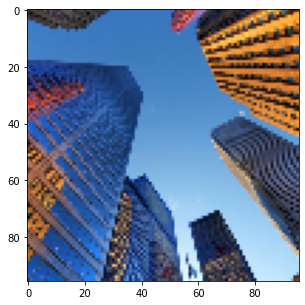

In [295]:
####working code 
# test = data['L'][2].cpu().permute(1,2,0)
# # t_nimg = torch.from_numpy(new_img)
# print(test.shape)
# plt.imshow(test)

from PIL import Image
fig= plt.figure(figsize=(5, 5))
tf = transforms.Compose([transforms.CenterCrop((96,96)),transforms.ToTensor()])
test_dataset_hr = torchvision.datasets.ImageFolder(root='C:/Users/n_babar/Desktop/SR/Project/test_response3/input_HR_scale', transform=tf)
test_loader = DataLoader(test_dataset_hr,batch_size=5 , shuffle=False)
print(test_loader.batch_size)
for idx,(data,labels) in tqdm(enumerate(test_loader)):
    ##print(x)
    data = data.cpu()
    with torch.no_grad():
        model = model.cpu()
        td=model(data)
inpt = data[0] 
print(inpt.shape)
test_d = td[0]
# test_d = test_d[1,:]
print(test_d.shape)
test_d = test_d.permute(1,2,0)
test_d = test_d.cpu().detach().numpy()
    
test_d = test_d.reshape((11,11))
# print(test_d.shape)
test_d = np.clip(test_d, 0, 1)
# print(test_d.shape)
output = (test_d * 255.0).round().astype(np.uint8)
final_img = Image.fromarray(output)
print(final_img.size)
save_path = 'C:/Users/n_babar/Desktop/SR/Project/test_response3/output_kernels'
final_img.save(save_path+'/'+'0.1'+'.png')
# ax[0].imshow(final_img)
plt.imshow(inpt.permute(1,2,0))
    
# 	img  = Image.fromarray(output)
# Saving the image
    # final_img.save(save_path+'/'+
	
    
    # # plt.imshow(t_nimg.permute(1,2,0))
    
    

    




# for idx, (img,label) in tqdm(enumerate(test_loader)):
#     img = img.to(device)
# 	with torch.no_grad():
# 		l = model_1(img)
# 	image = l
# 	image = torch.squeeze(image)
# 	image = image.permute(1,2,0)
# 	image = image.cpu().detach().numpy()
# 	image = np.clip(image, 0, 1)
# 	output = (image * 255.0).round().astype(np.uint8)
# 	img  = Image.fromarray(output)
# 	# Saving the image
# 	img.save(save_path + '/' + img_name[idx])
# # plt.imshow(t_nimg.permute(1,2,0))

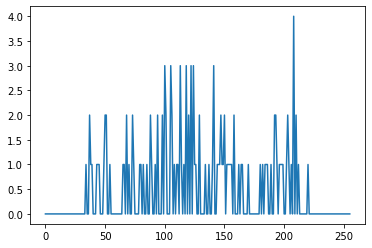

In [294]:
import cv2
k = cv2.imread("C:/Users/n_babar/Desktop/SR/Project/test_response3/output_kernels/0.1.png",0)
# print(k.dtype)
histr = cv2.calcHist([k],[0],None,[256],[0,256])
plt.plot(histr)
plt.show()

In [262]:
import cv2
k = cv2.imread("C:/Users/n_babar/Desktop/SR/Project/test_response3/input_HR_scale/1/001.png",0)
k.shape

(128, 171)

In [19]:
# for data in train_loader:
#     ##print(x)
#     data= data.to('cuda:0')
#     # print(x.shape)
#     break

# # image = image.to('cpu'
# inputs = data
# # print(inputs.shape)
# y = model(inputs)
print(outputs.shape) 
print(train.shape)

torch.Size([16, 121, 1, 1])
torch.Size([16, 3, 96, 96])


In [118]:
#testing images :
from torchvision.io import read_image
import torchvision.transforms as T
import numpy as np

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


model.to(device)
# read a PNG image
img = read_image('C:/Users/n_babar/Desktop/SR/Project/test_response3/response3_LR/001._Set__kernel_label_1.png')
print(img.shape)
img = img.to(device)
# img = T.ToPILImage()(img)
img = img.array(img)

transform = transforms.Compose([transforms.CenterCrop((96,96)),transforms.ToTensor()])
tensork = transform(img)
print(tensork.shape)

# output_test = model(tensork)

torch.Size([3, 128, 171])


AttributeError: 'Tensor' object has no attribute 'array'

## code to copy all the images in one folder 

In [32]:
data_set_1 = DatasetSR()




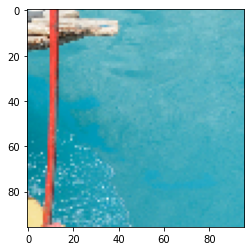

In [138]:
import matplotlib.pyplot as plt 
plt.imshow(data['H'][3].cpu().permute(1,2,0))


In [378]:
#### extracting the labels from the title of the images 


str1 = "0001_Set__kernel_4.png"
str2 = str1[len(str1)-5]
print(str2)

4


In [396]:
plt.imshow(x['L'].cpu().permute(1,2,0))

RuntimeError: number of dims don't match in permute

In [286]:
# data_Set = DatasetSR()
# print(len(data_Set))
# print(len(data_set))

import shutil
from tqdm.auto import tqdm
RootDir1 = r'C:\Users\n_babar\Desktop\SR\Project\train_model\DIV2K_GRND_SCALE'
TargetFolder = r'C:\Users\n_babar\Desktop\SR\Project\train_model\DIV2K_Ensemble_GRND'
for root, dirs, files in tqdm(os.walk((os.path.normpath(RootDir1)), topdown=False)):
        for name in files:
            if name.endswith('.png'):
                #print('found')
                SourceFolder = os.path.join(root,name)
                shutil.copy2(SourceFolder, TargetFolder) #copies csv to new folder

0it [00:00, ?it/s]

### Creating the datasets 

In [382]:
#Set Device to Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = 6
data_set_1 = DatasetSR()

# train_loader = DataLoader(data_set_1[x['L']],batch_size=16, shuffle=False)

# length = len(data_set_1)
# print(length)


cuda:0


In [33]:
###creating of the datasets 

#Set Device to Cuda
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
num_classes = 6

#*********************** A. Data Preparation and Processing State **************************

#converting db images to tensors 
# tf = transforms.Compose([Random_Crop(),transforms.ToTensor()])
tf = transforms.Compose([transforms.CenterCrop((96,96)),transforms.ToTensor()])
# Load data from the root directory and label the data as:
# {'DIV2K_train_Set_1': 0, 'DIV2K_train_Set_2': 1, 'DIV2K_train_Set_3': 2, 'DIV2K_train_Set_4': 3, 'DIV2K_train_Set_5': 4}

train_dataset = torchvision.datasets.ImageFolder(root='C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_LR', transform=tf)
# train_dataset = DatasetSR()
data_set_1 = DatasetSR()
valid_dataset = torchvision.datasets.ImageFolder(root='C:/Users/n_babar/Desktop/SR/Project/valid_model/DIV2K_LR', transform=tf)
grnd_truth_dataset = torchvision.datasets.ImageFolder(root='C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_GRND_SCALE', transform=tf)
###training data -----
# train_dataloader = DataLoader(training_data, batch_size=64, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=False)
valid_loader = DataLoader(valid_dataset, batch_size=16, shuffle= False) 
grnd_loader =  DataLoader(grnd_truth_dataset, batch_size=16, shuffle=False)
#transforms.resize(480,680)

print(train_dataset.class_to_idx) #Uncomment to print the labels of the corresponding dataset
print(grnd_truth_dataset.class_to_idx)

length = len(train_dataset)
print(length)
l_grnd = len(grnd_truth_dataset)
print(l_grnd)


cuda:0
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
{'1': 0, '2': 1, '3': 2, '4': 3, '5': 4, '6': 5}
800
800


In [44]:
for data in train_loader:
    ##print(x)
    x= data
   
    break
    
x = x.to('CUDA')
output = model(x)

AttributeError: 'list' object has no attribute 'to'

In [139]:
# from  matplotlib import pyplot as plt 

# Display image and label.
train_features, train_labels = next(iter(train_loader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[6]
print(f"Label: {label}")

Feature batch shape: torch.Size([16, 3, 96, 96])
Labels batch shape: torch.Size([16])
Label: 0


#### Model 

In [8]:
###Residual block ######

class BasicResidualBlock(nn.Module): 
    def __init__(self,channel_num):
        super(BasicResidualBlock,self).__init__()
        ## 3 * 3 kernel conv 
        #input and output channels == channel_num
        self.conv_block1 = nn.Sequential(nn.Conv2d(channel_num, channel_num ,3, padding=1),
                                         nn.BatchNorm2d(channel_num),nn.ReLU())
        self.conv_block2 = nn.Sequential(nn.Conv2d(channel_num, channel_num, 3, padding=1),
                                         nn.BatchNorm2d(channel_num))
        self.relu = nn.ReLU()
        self.maxpool = torch.nn.MaxPool2d(kernel_size = 3,padding = 1)
		 
              
    def forward(self,x): 
          
            ##forward 
            residual = x
            x = self.conv_block1(x)
            x = self.conv_block2(x)
            x = x + residual 
            x = self.relu(x)
            out = self.maxpool(x)
           
            return out 

In [140]:
##Functional KES net 

class KES_Net(torch.nn.Module):
    def __init__(self):
        super(KES_Net, self).__init__()
        
        ##first block is the convolution ---size of 
        self.block_1 = nn.Sequential(nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1),
                                    nn.ReLU(),nn.BatchNorm2d(64))                   
        
        self.BasicResidualBlock = nn.ModuleList([BasicResidualBlock(channel_num=64) for i in range(8)])
        # self.maxpool = torch.nn.MaxPool2d(kernel_size = 3,padding = 1)
        self.block_3 =  torch.nn.Sequential(torch.nn.Conv2d(in_channels =64,out_channels=256,kernel_size=1),
                                            torch.nn.BatchNorm2d(256),
                                            torch.nn.ReLU(inplace=True)
                                           )
        self.block_4 =  torch.nn.Sequential(torch.nn.Conv2d(in_channels =256,out_channels=128,kernel_size=1),
                                            torch.nn.BatchNorm2d(128),
                                            torch.nn.ReLU(inplace=True)
                                           )
        self.block_5 =  torch.nn.Sequential(torch.nn.Conv2d(in_channels =128,out_channels=121,kernel_size=1),
                                            torch.nn.BatchNorm2d(121),
                                            torch.nn.Sigmoid()
                                           )
        # self.fc2 = nn.Linear(121,1)
        
    def forward(self,x):
        x = self.block_1(x)
        for i, __ in enumerate(self.BasicResidualBlock):
            x = self.BasicResidualBlock[i](x)
       ##global average pooling  
        #x = x.mean(dim=(-2, -1))
            
        x = self.block_3(x)
        x = self.block_4(x)
        x = self.block_5(x)
        # x = self.fc2(x)
        
        return x

In [260]:
model = KES_Net()
model.to(device)

error = nn.CrossEntropyLoss()

learning_rate = 1e-4 
error = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Code to use the Adam Optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
#scheduler = MultiStepLR(optimizer, milestones=[2000 * 200], gamma=0.5) #milestones=[Intended Epoch * Batch Size]
# print(model)





In [289]:
from torch.optim.lr_scheduler import MultiStepLR
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
model = KES_Net()
model.to(device)

# error = nn.L1Loss()

learning_rate = 1e-4 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) # Code to use the Adam Optimizer
#optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
scheduler = MultiStepLR(optimizer, milestones=[100000, 160000, 180000, 192000, 200000], gamma=0.5) #milestones=[Intended Epoch * Batch Size]
# print(model)

cuda:0


In [19]:
import torch.nn.functional as F
num_epochs = 300 #5000 after half divide lr by 2
count = 0
# Lists for visualization of loss and accuracy 
loss_list = []
iteration_list = []
accuracy_list = []

# Lists for knowing classwise accuracy
predictions_list = []
labels_list = []

count = 0 
optimizer = torch.optim.SGD(model.parameters(), lr =0.0001 , momentum =0.5)
# num_epochs = 50
learning_rate = 0.1


def wiener_loss_function(image,kernel,grnd_img):
    transform = transforms.ToTensor()
    rng = np.random.default_rng()
    ##input image for the network
    image = image.to('cpu')
    image = image.detach().numpy()
    image = image[1,:]
    image = image.reshape((96,96,3))
    image = color.rgb2gray(image)
    image += 0.1 * image.std() * rng.standard_normal(image.shape)
    image = image.astype(object)
    ####this is for the kernel ----reshaping from 121,1 to 11,11
    kernel = kernel.to('cpu')
    kernel = kernel.detach().numpy()
    kernel = kernel[1,:]
    kernel = kernel.reshape((11,11))
    kernel = kernel.astype(object)
    # deconv_img = restoration.wiener(image, kernel,0.0001)
    ##deconvoluting the image with the filter ---requiring 
    deconv_img, _ = restoration.unsupervised_wiener(image, kernel)
    deconv_tensor = transform(deconv_img)
    deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)
    deconv_tensor = deconv_tensor.type(torch.DoubleTensor)
    ##ground  image --from the g_inputs 
    grnd_img = grnd_img.to('cpu')
    grnd_img = grnd_img[1,:]
    grnd_img = grnd_img.reshape((96,96,3))
    grnd_img = color.rgb2gray(grnd_img)
    grnd_img_tensor = transform(grnd_img)
    grnd_img_tensor=grnd_img_tensor.type(torch.DoubleTensor)
    # print(grnd_img)
    # plt.imshow(grnd_img)
    mse_loss = nn.MSELoss()
    loss = mse_loss(deconv_tensor,grnd_img_tensor)
    loss = loss.type(torch.DoubleTensor)
    print(loss)
    return loss


for epoch in tqdm(range(num_epochs)):
    running_loss =0.0
    # for i,data in enumerate(train_loader, 0):
    for index, ((img,lab_t),(img1,lab_g)) in tqdm(enumerate(zip(train_loader,grnd_loader))):
        ##getting the inputs; data is a list of [inputs,labels] 
        
        # inputs , labels = data
        # inputs , labels = inputs.cuda(), labels.cuda()
        
        ##input images for the train loader
        images_input = img.to(device)
        train = Variable(images_input)
        
        ##ground loader
        ground = Variable(img1.to(device))        

        # zero the parameter gradients 
        optimizer.zero_grad()
        
        # forward + backward + optimize 
        outputs = model(images_input)
        loss = wiener_loss_function(train,outputs,ground)
        # Initializing a gradient as 0 so there is no mixing of gradient among the batches
        optimizer.zero_grad()
        
        #Propagating the error backward
        # loss.backward()
        
        # Optimizing the parameters
        # optimizer.step()
        scheduler.step()
        count += 1
        loss.backward()
        optimizer.step() 
        
        
        
        count += 1
#         running_loss += loss.item()
#         print ('iteration : {}, No. of Epochs [{}/{}],Learning rate :  Loss: {:.4f}'.format(count,epoch+1, num_epochs,learning_rate,loss.item()))
# print('Finished Training')
        if (count % 800 == 0):
            print("Iteration: {}, Loss: {}%, Learning Rate: {}, epoch: {}".format(count, loss.data,scheduler.get_last_lr(),epoch))
            loss_list.append(loss.data)
            iteration_list.append(count)
        if epoch % 5 == 0 or epoch ==num_epochs - 1 :
            torch.save(model.state_dict(), os.path.join("C:/Computer_Vision/Nashra_486515/Super_resolution_project/KES_Net", 'KES_Net' + str(epoch) + '.pth'))
                                                               


  0%|          | 0/300 [00:00<?, ?it/s]

NameError: name 'train_loader' is not defined

#### loading the inputs to the model and  finding the result 

In [20]:
for idx,(data,labels) in enumerate(train_loader):
    ##print(x)
    data, labels = data.cuda(), labels.cuda()
    # print(x.shape)
    break


inputs = data
# print(inputs.shape)
y = model(inputs)

print(y.shape)
y=y[1,:]
y= y.reshape((11,11))

# print(y)
# labels = torch.argmax(y, 1)
g=read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_1.png')

NameError: name 'train_loader' is not defined

In [152]:
import numpy as np
from skimage import color, data, restoration
import torch.nn as nn
import torch


def wiener_loss_function(image,kernel,grnd_img):
    transform = transforms.ToTensor()
    rng = np.random.default_rng()
    ##input image for the network
    image = image.to('cpu')
    image = image.detach().numpy()
    image = image[1,:]
    image = image.reshape((96,96,3))
    
    image = color.rgb2gray(image)
    print(image.shape)
    image += 0.1 * image.std() * rng.standard_normal(image.shape)
    image = image.astype(object)
    ####this is for the kernel ----reshaping from 121,1 to 11,11
    kernel = kernel.to('cpu')
    kernel = kernel.detach().numpy()
    kernel = kernel[1,:]
    kernel = kernel.reshape((11,11))
    kernel = kernel.astype(object)
    # deconv_img = restoration.wiener(image, kernel,0.0001)
    ##deconvoluting the image with the filter ---requiring 
    deconv_img, _ = restoration.unsupervised_wiener(image, kernel)
    deconv_tensor = transform(deconv_img)
    deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)
        
    ##ground  image --from the g_inputs 
    grnd_img = grnd_img.to('cpu')
    grnd_img = grnd_img[1,:]
    grnd_img = grnd_img.reshape((96,96,3))
    grnd_img = color.rgb2gray(grnd_img)
    grnd_img_tensor = transform(grnd_img)
    # print(grnd_img)
    # plt.imshow(grnd_img)
    mse_loss = nn.MSELoss()
    loss = mse_loss(deconv_tensor,grnd_img_tensor)
    print(loss)
    return loss

In [153]:
from torchvision.utils import save_image
x = model(inputs)
print(inputs.shape)
print(x.shape)
x = x.to('cpu')
x = x[1,:]
# print(x.shape)

x = x.reshape((11,11))
# kernel = kernel.astype(object)
save_image(x, 'img1.png')
print(x.shape)

# print(x.shape)
# plt.imshow(x)
# b = read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_1.png')
# print(b.shape)

torch.Size([4, 3, 96, 96])
torch.Size([4, 121, 1, 1])
torch.Size([11, 11])


## Loss function ####

In [154]:
###defination for the loss function which is ---weiner deconvolution comparing the images and the kernels and sending the deconvolved image and the image is compared iwth the ground truth
import numpy as np
from skimage import color, data, restoration
import torch.nn as nn
import torch


def wiener_loss_function(image,kernel,grnd_img):
    # print(label)
    # kernel = output_label(label)
    transform = transforms.ToTensor()


    rng = np.random.default_rng()
    image = image.to('cpu')
    image = image.detach().numpy()
    # image = color.rgb2gray(image)
    # kernel=model(image)
    image = image[1,:]
    image = image.reshape((96,96,3))
    # image = image[0,:,:]   
    image = color.rgb2gray(image)
    image += 0.1 * image.std() * rng.standard_normal(image.shape)
    #image = color.rgb2gray(image)
    image = image.astype(object)
    print(image.shape)
    # plt.imshow(image)
    #print(kernel.size())

    ##the below kernel psf is just for the testing purpose -------
    # psf = np.ones((5, 5)) / 25
    kernel = kernel.to('cpu')
    kernel = kernel.detach().numpy()
    kernel = kernel[1,:]
    kernel = kernel.reshape((11,11))
    kernel = kernel.astype(object)
    # deconv_img = restoration.wiener(image, kernel,0.0001)
    deconv_img, _ = restoration.unsupervised_wiener(image, kernel)
    deconv_tensor = transform(deconv_img)
    deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)
    # print(deconv_img)
    # plt.imshow(deconv_img)
    
    
    grnd_img = grnd_img.to('cpu')
    grnd_img = grnd_img[1,:]
    grnd_img = grnd_img.reshape((96,96,3))
    grnd_img = color.rgb2gray(grnd_img)
    grnd_img_tensor = transform(grnd_img)
    # print(grnd_img)
    # plt.imshow(grnd_img)
    mse_loss = nn.MSELoss()
    loss = mse_loss(deconv_tensor,grnd_img_tensor)
    print(loss)
    return loss
    # loss = loss_fn(deconv_img,grnd_img)
    # print(loss)
    # return loss
    
    # deconv_img = restoration.wiener(image,psf,0.01)
    #deconvolved, _= restoration.unsupervised_wiener(image.detach().numpy(),kernel.detach().numpy())
    
    # return deconv_img

# def loss_function(image,kernel,grnd_img):
#     d_img = wiener_filter(image,kernel)
#     grnd_img = img.to('cpu')
#     grnd_img = grnd_img[0,:,:]
#     print(grnd_img.shape)
#     loss = torch.mean((d_img - grnd_img)**2)
#     return loss 
    
    



# def output_label(labels):
#         output_mapping = {
#                  1: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_1.png'),
#                  2: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_2.png'),
#                  3: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_3.png'),
#                  4: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_4.png'),
#                  5: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_5.png'), 
#                  0: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_0.png'), 
#                  }
#         input = (labels.item() if type(labels) == torch.Tensor else labels)
#         return output_mapping[input]


In [156]:
# k = read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_4.png')
# k = k .reshape((11,11))
# print(k.shape)

from skimage import color, data, restoration
import torch
demo = g_inputs
demo = demo.to('cpu')
demo = demo[1,:]
demo = demo.reshape((96,96,3))
demo = color.rgb2gray(demo)
transform = transforms.ToTensor()
tensor_1 = transform(demo)
tensor_1 = torch.tensor(tensor_1,requires_grad=True)
# print(demo.shape)
# plt.imshow(demo)


C:\Users\n_babar\AppData\Local\Temp/ipykernel_37316/225340551.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  tensor_1 = torch.tensor(tensor_1,requires_grad=True)


In [157]:
# import matplotlib as plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg



for i,data in enumerate(train_loader):
        ##getting the inputs; data is a list of [inputs,labels] 
        
        t_inputs , t_labels = data
        t_inputs , t_labels = g_inputs.to(device), g_labels.to(device)
        break
        
for i,data in enumerate(grnd_loader):
        ##getting the inputs; data is a list of [inputs,labels] 
        
        g_inputs , g_labels = data
        g_inputs , g_labels = g_inputs.cuda(), g_labels.cuda()
        break
               
    
img_input = t_inputs
# print(img_input.shape)
# image = img_input[1,:]
# image = img_input[0,:,:] 
# image = image.to('cpu')
# image = rgb2gray(image)
img_k = model(img_input)
# print(img_k.shape)
img_2 = g_inputs
# print(img_2.shape)
error = wiener_loss_function(img_input,img_k,img_2)
# print(image.shape)
# plt.imshow(img_2)



##for the ground image 
# c = g_inputs[0]
# plt.imshow(c.cpu().permute(1,2,0))


(96, 96)
tensor(0.2848, dtype=torch.float64, grad_fn=<MseLossBackward0>)


C:\Users\n_babar\AppData\Local\Temp/ipykernel_37316/3315591315.py:40: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  deconv_tensor = torch.tensor(deconv_tensor,requires_grad=True)


In [53]:
for i,data in enumerate(train_loader):
        ##getting the inputs; data is a list of [inputs,labels] 
        
        t_inputs , t_labels = data
        t_inputs , t_labels = g_inputs.to(device), g_labels.to(device)
        break  
        img_1 = t_inputs

# img_1 = img_1[1,:]
# print(img_1.shape)
# img_1 = img_1[None,:]
# print(img_1.shape)

x = model(img_1)

print(x.shape)
img_1 = img_1[1,:]
# ##the working code is down 
img_1 = img_1[0,:,:]
# #img_1 = img_1[:, :, 0]*0.299 + img_1[:, :, 1]*0.587 + img_1[:, :, 2]*0.114
print(img_1.shape)

# img_1 = color.rgb2gray(img_1)
x = x[1,:]
# print(x.shape)

x = x.reshape((11,11))
# print(x.shape)
print(x.shape)
c = g_inputs[0]
 

#print(x.shape)

# kernel = output_label(1)
error = loss_function(img_1,x)
# error = wiener_filter(img_1,x)
plt.imshow(error)
print(error.shape)
#print(error)



NameError: name 'img_1' is not defined

In [49]:
import matplotlib.pyplot as plt

In [ ]:
##criterion = nn.L1Loss()
count = 0 
optimizer = torch.optim.SGD(model.parameters(), lr =0.0001 , momentum =0.5)
num_epochs = 50
learning_rate = 0.1
for epoch in range(num_epochs):
    for idx,((img,lab),(orig,lab1)) in tqdm(enumerate(zip(train_loader,grnd_loader))):
        ##getting the inputs: data is a list of [inputs,labels] 
        images = img.to(device)
        train = Variable(images)
        gt_images = orig.to(device)
        
        # Forward pass -----
        outputs = model(train)
        
        #calculating the loss----- 
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        
        

## testing for the response 3

In [72]:
#test dataset

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)


import numpy as np
import matplotlib.pyplot as plt
import imageio as iio
import cv2
import torch
import torchvision.transforms as transforms
# read an image
#img = iio.imread("baby.bmp")
# img = cv2.imread('C:/Users/n_babar/Desktop/SR/Project/test_response3/response3_LR/001._Set__kernel_label_1.png')
# img = np.array(img)
# #img = cv2. resize(img, dsize=(513, 511), interpolation=cv2.INTER_CUBIC) #
# print(img.shape)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# plt.imshow(img)
# type(img)
# trans = transforms.Compose([
#     transforms.ToTensor()])

# # image = tf.image.convert_image_dtype(img, tf.float32) # equivalent to dividing image pixels by 255
# # image = tf.image.resize(img, (3,96,96)) 
# tensork.reshape((96,96,3))
# # output_test = model(

k = read_image("C:/Users/n_babar/Desktop/SR/Project/test_response3/response3_LR/001._Set__kernel_label_1.png")
print(k.shape)
k =  np.array(k)
# transform = transforms.Compose([transforms.CenterCrop((96,96))])
transform = transforms.Compose([transforms.CenterCrop((96,96)),transforms.ToTensor()])
tensork = transform(k)

tensork.reshape((96,96,3))
print(tensork.shape)
# k = color.rgb2gray(data.astronaut())




cuda:0
torch.Size([3, 128, 171])


TypeError: Unexpected type <class 'numpy.ndarray'>

In [23]:
c = inputs[0]
print(c.size())
plt.imshow(c.cpu().permute(1,2,0))


NameError: name 'inputs' is not defined

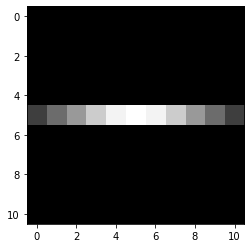

In [590]:


##displaying any tensor  image !! 
import matplotlib.pyplot as plt 
plt.imshow(b.cpu().permute(1,2,0))



In [103]:
import numpy as np 
import matplotlib.pyplot as plt 


from skimage import color , data,restoration 
rng = np.random.default_rng()

In [104]:
import torchvision.transforms as T



In [432]:
###LOSS CALCULATION 


##converting the list of the output to the list of numpy array first ---> 
def output_label(labels):
        output_mapping = {
                 0: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_1.png'),
                 1: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_2.png'),
                 2: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_3.png'),
                 3: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_4.png'),
                 4: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_5.png'), 
                 5: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_6.png'), 
                 }
        
        input = (labels.item() if type(labels) == torch.Tensor else labels)
        return output_mapping[input]

        
class WeinerDeconv(nn.modules.Module):
    def __init__(self):
        super(WeinerDeconv,self).__init__()
        
    def forward(self,output,labels):
        output = output.reshape((11,11))
        input_label = output_label(labels) ###expected labels ---original values of the kernels 
        input_label = input_label.reshape((11,11))
        loss = torch.mean((output - input_label)**2)
        return loss 
# size of the tensor was ([121,1,1]) ---reshaping was required (11,11) same with the original LR images as they were ([1,11,11])

###debugging 

a = outputs[0]
# print(a.size())
c = labels[0]
# print(a.reshape((11,11)))
print(c)
error = WeinerDeconv(a,c)
print(error)


tensor(5, device='cuda:0')


TypeError: __init__() takes 1 positional argument but 3 were given

In [207]:
#outputs 
# import numpy as np 
# import matplotlib.pyplot as plt
# from torchvision.utils import save_image
# # index = output.cpu().data.numpy().argmax()
# ##reshaping the output 
# a = outputs[0]
# b = a.reshape((11,11))
# # C:\Users\n_babar\Desktop\SR\Project\train_model\DIV2K_kernels
# c = labels
# print(b.shape)

# def output_label(labels):
#     output_mapping = {
#                  0: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_1.png'),
#                  1: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_2.png'),
#                  2: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_3.png'),
#                  3: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_4.png'),
#                  4: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_5.png'), 
#                  5: read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_6.png'), 
#                  }
#     input = (labels.item() if type(labels) == torch.Tensor else labels)
#     return output_mapping[input]

# img_out = output_label(0).reshape((11,11))


# def weiner_Deconv_loss(outputs,labels):
#     output=torch.tensor(outputs().reshape((11,11)))
#     input_label = output_label(labels()).reshape((11,11))
#     loss = torch.mean((output - input_label)**2)
#     return loss 

# error= weiner_Deconv_loss(b,img_out)
     

In [49]:
#validation accuracy 

correct = 0 
total = 0 
with torch.no_grad():
    for data in valid_loader:
        images , labels = data 
        images , labels = images.cuda(), labels.cuda()
        outputs = model(images)
        _, predicted = torch.max(outputs.data,1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
print('Accuracy of the network on the test i"mages : %d %%' % (
    100 * correct /total))

Accuracy of the network on the test i"mages : 10 %


In [ ]:
num_epochs =200
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
import gc
total_step = len(train_loader)
error = nn.L1Loss()

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = error(outputs, labels)
        # loss = error(outputs, check)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        del images, labels, outputs
        torch.cuda.empty_cache()
        gc.collect()

    print ('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

In [45]:
torch.save(model.state_dict(), os.path.join("C:/Users/n_babar/Desktop/SR/Project/model", 'KES_Net' + str(200) + '.pth'))

Demo checkin for the wiener color ---deconvolution




In [270]:
#c is the image
from scipy.signal import convolve2d as conv2
c = t_inputs
k = read_image("C:/Users/n_babar/Desktop/SR/Project/kernel_estimation/0064_Set__kernel_label_4.png")
print(k.dtype)
k = k.to('cpu')
transform = transforms.Compose([transforms.CenterCrop((96,96))])
# transform =transforms.Compose([transforms.CenterCrop((96,96)),transforms.ToTensor()])
tensork = transform(c)

# tensork.reshape((96,96,3))
print(tensork.shape)
# k = color.rgb2gray(data.astronaut())
# tensork=tensork[1,:]
# t_inputs = t_inputs[1,:]
# t_inputs = t_inputs.reshape((96,96,3))
# t_inputs = t_inputs[1,:]
# print(c.size())
# c = c.cpu()
# # plt.imshow(c.cpu().permute(1,2,0))
# c = c[1,]
# print(c.shape)
# #k is the k
# k = read_image('C:/Users/n_babar/Desktop/SR/Project/train_model/DIV2K_kernels/kernel_4.png')
# k = k .reshape((11,11))
# k=k.cpu()
# print(k.shape)
# print(t_inputs.shape)
# new_img = conv2(c,k,'same')
# x=model(k)
# print(x.shape)
# g_ipuput = 
# deconvolved, _ = restoration.unsupervised_wiener(t_inputs,x,is_real=True, clip=True)
'''fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(8, 5),
                        sharex=True, sharey=True)

ax[0].imshow(c)
ax[1].imshow(new_img)
ax[2].imshow(x)'''


torch.uint8


TypeError: Tensor is not a torch image.